# Deriving multi-Gaussian approximations to Sersic profiles

This notebook demonstrates how to derive optimal parameters for Gaussian mixture model approximations to the Sersic (1963, 1968) function commonly used to model galaxy radial surface brightness profiles.

The main motivation behind doing this is that a Gaussian convolved with a Gaussian has an analytic solution - namely, another Gaussian - and so Gaussian mixture galaxy models convolved with Gaussian mixture PSF models are simple and fast to evaluate.
There are some other advantages that won't be detailed here. The only serious disadvantage is the introduction of 'wiggles' in the profile and therefore roughly sinusoidal variations in the second derivative.

The approach here is similar to Hogg & Lang (2013), but that paper did not publish weights for entire useful range of Sersic indices 0.5 <= n < 8. In practice we usually only go up to n=6.3 as this is the upper limit supported in GalSim.

For convenience, after this we'll refer to multi-Gaussian approximations (i.e. Gaussian mixture models) as MGAs for short.

In [1]:
# Setup; multiprofit gets imported later for verification plots

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp

In [2]:
%matplotlib inline
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['image.origin'] = 'lower'
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})

## Define useful functions

Here we'll define functions for a unit Sersic profile, and for optimizing the weights in an MGA for a chi-square like objective function.

The fitting functions allow for matching the profile over a limited range after re-normalization - the justification for this will be explained later.

Note that the size unit is always Re, and Re = FWHM/2 ~ 1.17741 sigma; the weight is just a fraction for convenience.

In [3]:
# Surface brightness of a unit flux Sersic profile
def sersic(r, n, re):
    bn = sp.stats.gamma.ppf(0.5, 2*n)
    g_factor = sp.special.gamma(2*n)
    flux = np.power(re, 2)*2*np.pi*n*g_factor*np.exp(bn)/np.power(bn, 2*n)
    ir = np.exp(-bn*(np.power(r/re, 1./n)-1.))
    return ir/flux


# Compute chisq as log difference in 2D binned flux
# i.e. not really chisq since it's a sum of squares but without any error
# Rangefit allows re-normalizing the model to match data normalization within the specified range
# Otherwise, the model and data are normalized from r=0 to infinity
def chisq_sersic(params, x, y, weightsbins, rangefit=None, rdivreslog=None,
                 plotdata=False, plotmodel=False, returnall=False):
    ymodel = np.zeros(len(x))
    weights, res = paramstoweightres(params, rdivreslog)
    for weight, re in zip(weights, res):
        ymodel += weight*sersic(x, 0.5, re)
    if plotdata:
        plt.plot(x, np.log10(y/(weightsbins if weightsbins is not None else 1.)))
    if plotmodel:
        plt.plot(x, np.log10(ymodel))
    if weightsbins is not None:
        ymodel *= weightsbins
        if plotmodel:
            print(np.sum(y), np.sum(ymodel))
    if weightsbins is not None:
        if rangefit is not None:
            ymodel = ymodel[rangefit]
            ymodel *= np.sum(y[rangefit])/np.sum(ymodel)
        chisq = np.log10(np.sum(((y if rangefit is None else y[rangefit])-ymodel)**2))
        if returnall:
            return chisq, ymodel
        return chisq


# Take a parameter vector for fitting and split into sizes and weights
def paramstoweightres(params, rdivreslog=None):
    if rdivreslog is not None:
        paramsnew = np.concatenate([params, rdivreslog])
    else:
        paramsnew = params
    nsplit = (len(paramsnew)+1)//2
    weights = np.zeros(nsplit)
    res = np.zeros(nsplit)
    total = 1.0
    for i in range(nsplit):
        if i < (nsplit-1):
            weight = sp.special.expit(paramsnew[i])
            weights[i] = total*weight
            total *= (1.0-weight)
        res[i] = 10**paramsnew[i+nsplit-1]
    weights[nsplit-1] = 1-np.sum(weights)
    return weights, res


# Take sizes and weights of Gaussians and mash them into a single parameter vector (e.g. for minimization)
def weightrestoparams(weights, res, rdivreslog=None):
    paramweights = []
    paramres = []
    total = 1.0
    for weight, re in zip(weights, res):
        paramweights.append(sp.special.logit(weight/total))
        total -= weight
        if rdivreslog is None:
            paramres.append(np.log10(re))
    return paramweights[:-1] + paramres


# Fit optimals weights for given values of n, given radial bins, the area of each bin, optional sigmas on the bins (i.e. how to weight each bin when fitting)
# Can specify a fitting method, whether and how many of the values to plot, a threshold to add an extra component, the initial weight of the added component,
# whether the added component should be bigger than the biggest or smaller than the smallest current component
# funcrangefit:   A function that takes radii and n and returns a restricted range of radii to fit (that depends on n)
# funcrdivreslog: A function that returns radii for a given n and fixes them so that only the weights are fit (useful for fitting values of n close to 0.5)
def fitweights(nvals, radii, areasq, weightssigmas={}, methods=['BFGS'], plot=True, plotnth=1, plotvals=None, addthreshhold=None,
               weightinit=1e-3, refacinit=1.1, addbig=None, funcrangefit=None, funcrdivreslog=None, sort=True):
    for nvalsi, weightsvars in nvals:
        params = weightrestoparams(weightsvars[0], weightsvars[1], funcrdivreslog) if weightsvars is not None else None
        for i, n in enumerate(nvalsi):
            plotn = plot and (((i+1) % plotnth == 0) or (plotvals is not None and n in plotvals))
            y = sersic(radii, n, 1)*areasq
            paramsbytype = {}
            rangefit = funcrangefit(radii, n) if funcrangefit is not None else None
            rdivreslog = funcrdivreslog(n) if funcrdivreslog is not None else None
            if params is not None:
                paramsbytype['Init'] = params
            if n in weightssigmas:
                weightsvars = weightssigmas[n]
                paramsbytype['Existing'] = weightrestoparams(
                    weightsvars[0][::-1], np.sqrt(weightsvars[1][::-1])*gaussian_sigma_to_re)
            plotdata = plotn
            chisqmin = np.Inf
            for name, paramsi in paramsbytype.items():
                chisq = chisq_sersic(paramsi, radii, y, areasq, rangefit, rdivreslog,
                                     plotdata=plotdata, plotmodel=plotn)
                print(name, ' chisq =', chisq)
                if chisq < chisqmin:
                    params = paramsi
                plotdata = False
            print('ws, re:', paramstoweightres(params, rdivreslog))
            for method in methods:
                fit = sp.optimize.minimize(chisq_sersic, params, args=(radii, y, areasq, rangefit, rdivreslog),
                                           tol=1e-5, options={'disp': True, }, method=method)
                params = fit['x']
            print(fit['fun'], fit['x'])
            chisq = chisq_sersic(params, radii, y, areasq, rangefit, rdivreslog, plotmodel=plotn)
            if plotn:
                plt.xlabel('$r/r_{eff}$')
                plt.ylabel('log10(surface density)')
                plt.tight_layout()
                for axis in ['x', 'y']:
                    plt.autoscale(enable=True, axis=axis, tight=True)
                plt.legend(['Data'] + list(paramsbytype.keys()) + ['Best'])
            weights, res = paramstoweightres(params, rdivreslog)
            if sort:
                idxsort = np.argsort(res)[::-1]
                weights = np.array(weights)[idxsort]
                res = np.array(res)[idxsort]
            print('n={}: ('.format(n))
            for arr, prefix, postfix in [(weights, 'normalize(', ')'), (res, '', '')]:
                print('    ' + prefix + 'np.array([' + ', '.join(
                    ['{:.10e}'.format(x) for x in arr]) + '])' + postfix + ',')
            print('),')
            if addthreshhold is not None and chisq > addthreshhold:
                # Add a small component if n < 1.5; big if n > 1.5 by default
                cond = n > 1.5 if addbig is None else addbig 
                weights *= 1.0-weightinit
                weights = np.insert(weights, 0, weightinit) if cond else np.append(weights, weightinit)
                res = np.insert(res, 0, refacinit*res[0]) if cond else np.append(res, res[-1]/refacinit)
                params = weightrestoparams(weights, res)
                print('new w, r:', weights, res)
            if plotn:
                plt.show()
                

def normalize(array):
    array /= np.sum(array)
    return array

## Define the fit range and plot the Sersic profile for reference

We choose to fit out to R/Re = 12 rather than the more typical limit of R/Re=8 commonly used in SDSS. This allows the fits to better match the n>4 profiles at R/Re > 4. Massive elliptical galaxies often do have very extended outer profiles with large Sersic indices (see papers by Kormendy & co. on Virgo galaxies), so we do want to reproduce the shape at large radii. Eventually, the MGA profile will truncate more quickly than a Sersic profile as only the outer Gaussian contributes to the flux, but that's fine - we don't really trust the extrapolation at such large radii unless there's very deep data to constrain it.

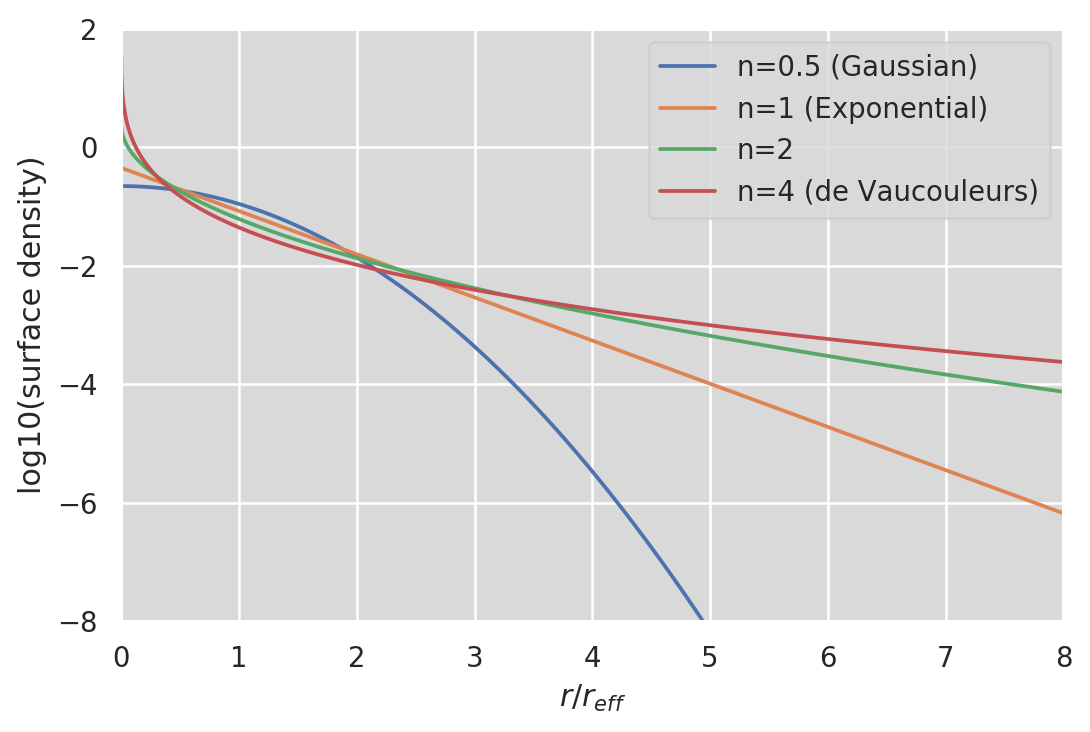

In [4]:
order = 8

nbinsperre = 2000
remax = 12
redge = np.linspace(0, remax, nbinsperre*remax+1)
rmid = (redge[1:] + redge[:-1])/2.
rsq = redge**2
areasq = np.pi*(rsq[1:] - rsq[:-1])

idxsplot = range(8*nbinsperre)

for n in [0.5, 1, 2, 4]:
    sns.lineplot(rmid[idxsplot], np.log10(sersic(rmid[idxsplot], n, 1)))
plt.xlim([0, 8])
plt.ylim([-8, 2])
plt.tight_layout()
#for axis in ['x', 'y']:
#    plt.autoscale(enable=True, axis=axis, tight=True)
plt.xlabel('$r/r_{eff}$')
plt.ylabel('log10(surface density)')
plt.legend(['n=0.5 (Gaussian)', 'n=1 (Exponential)', 'n=2', 'n=4 (de Vaucouleurs)' ])
plt.show()

## Carefully fit MGA weights/sizes for n < 1

This section begins fitting the optimal weights and sizes of the MGA.

The trickiest part of this problem is finding optimal weights for an MGA with N components as n -> 0.5. Of course, you only need a single component to reproduce n=0.5 exactly, and for n=0.5 + a small epsilon, you need only two Gaussians - one slightly smaller and one slightly larger - for a good approximation. As n grows, the minimal N for a good fit grows too. There are essentially two options, then - either grow N gradually with increasing n, or keep N fixed and hope that the weights change smoothly down to n=0.5. Unfortunately, the latter option is practically quite difficult as many of the best-fit weights asymptote to zero but are very noisy, which is a problem if we want to smoothly interpolate the weights for any value of N (see below). That leaves the first option of gradually adding components.

After some experimentation, two things are apparent. First, as n->0.5, the best-fit model tends to two components of (weight, size) = (1-delta, 1+eps), (delta, 0.716). Why that specifical value of 0.716, I'm not sure.

Secondly, adding components while maintaining a smooth variation in the weights and sizes becomes tricky, because the best-fit solutions for an MGA with N and N-1 components can be significantly different. The solution here is to ensure delta n is large enough when incrementing N such that the weights still change smoothly. However, it turns out that the weights derived here through a combination of working from n=0.5 up and from n=1 down (meeting in the middle) don't change smoothly enough to be useable for interpolation and fitting - see the plots further below.

Thirdly, there were only two things, but there's no legend in the plots so it should be mentioned that blue is true profile, orange is the initial guess, and green is the final best fit.

Note that it's impossible to fit n < 0.5 profiles with an MGA without spatially offsetting the components. Note that as n <= 0, the Sersic profile approaches a step function. This isn't a very useful approximation for most 'normal' galaxies, but it can be a useful approximation of parts of barred/ring galaxies, so we will revisit this issue later.

1.0000000144581254 1.000000014229467
Init  chisq = -7.588745391812752
ws, re: (array([0.98, 0.02]), array([1.01, 0.9 ]))
         Current function value: -12.124435
         Iterations: 21
         Function evaluations: 612
         Gradient evaluations: 120
-12.1244350827063 [ 5.63857896e+00  5.35362016e-04 -1.45058260e-01]
1.0000000144581254 1.0000000144537895
n=0.501: (
    normalize(np.array([9.9645469317e-01, 3.5453068336e-03])),
    np.array([1.0012334767e+00, 7.1604734662e-01]),
),


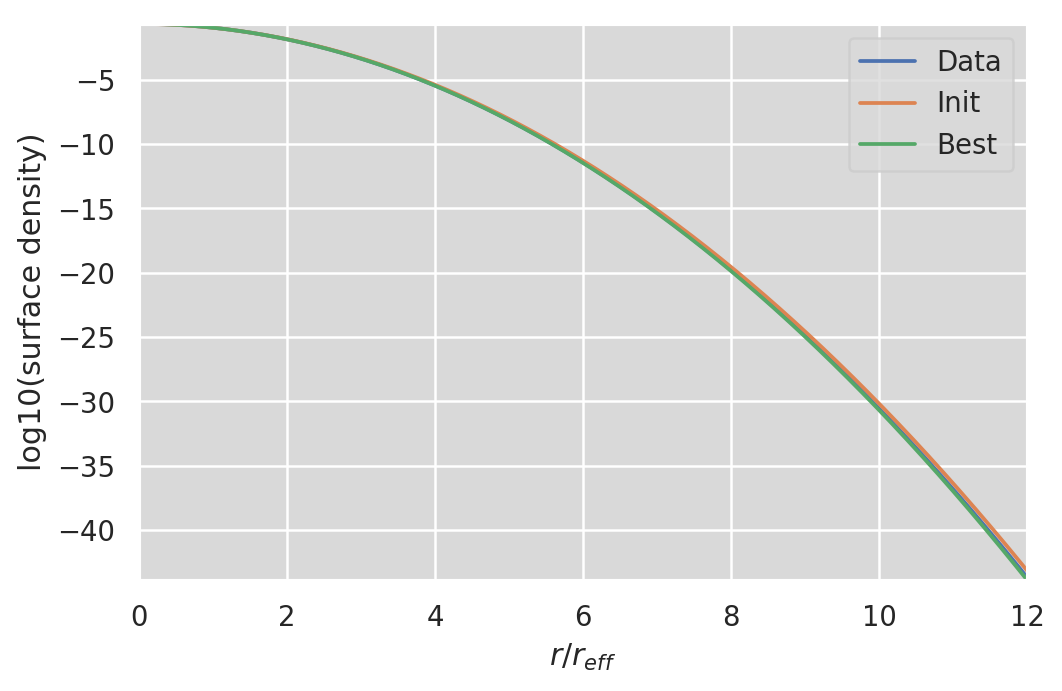

1.0000000145642924 1.0000000147654382
Init  chisq = -7.7362581434074595
ws, re: (array([0.87013735, 0.12619086, 0.00367179]), array([1.03392488, 0.81955231, 0.42170644]))
         Current function value: -11.998273
         Iterations: 207
         Function evaluations: 2336
         Gradient evaluations: 332
-11.99827306304458 [-2.89964115e+00  6.66790914e+00 -8.51519166e-02  5.29272520e-03
 -3.75584400e-01]
1.0000000145642924 1.0000000145537353
n=0.507: (
    normalize(np.array([9.4662548327e-01, 5.2171305034e-02, 1.2032116992e-03])),
    np.array([1.0122615136e+00, 8.2195507899e-01, 4.2112943705e-01]),
),


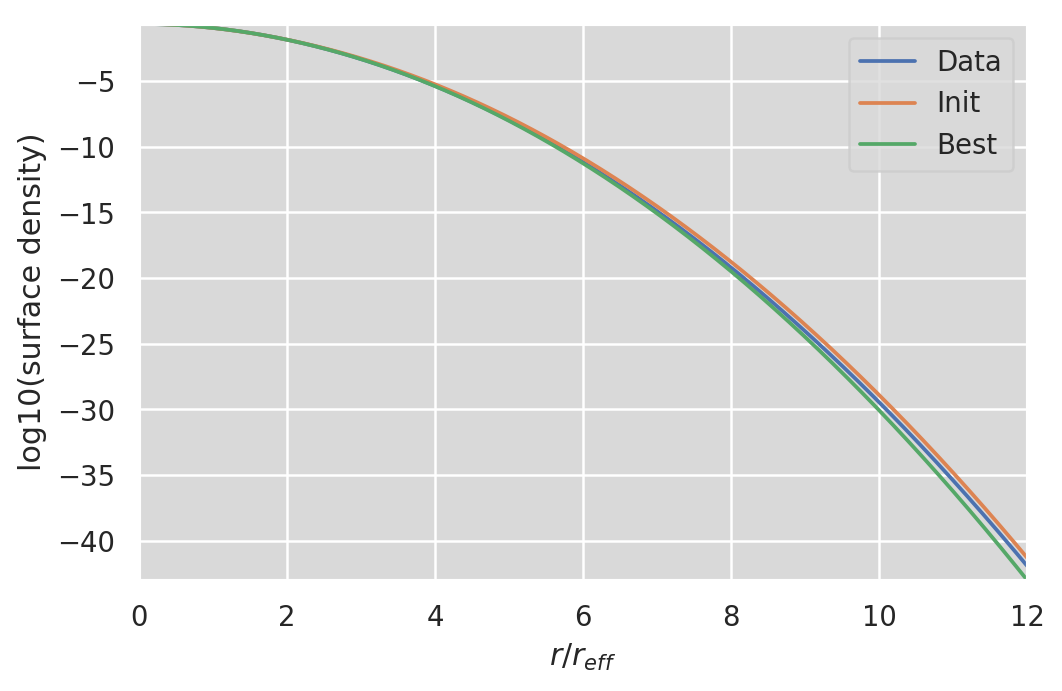

Init  chisq = -7.117390029086779
ws, re: (array([0.07790019, 0.31264016, 0.33937179, 0.1839253 , 0.06541804,
       0.01709507, 0.00326612, 0.00038332]), array([2.17045661, 1.47679133, 0.99494464, 0.65054022, 0.40699848,
       0.23877605, 0.12631553, 0.05405815]))
         Current function value: -11.155304
         Iterations: 52
         Function evaluations: 2035
         Gradient evaluations: 119
-11.15530445544733 [-2.42262005 -0.59808414  0.30058746  0.82079262  1.1970379   1.5809865
  2.17308776  0.31341845  0.15498436 -0.01022075 -0.1900277  -0.38993527
 -0.6181705  -0.89132524 -1.2559645 ]
n=0.95: (
    normalize(np.array([8.1463988478e-02, 3.2588016643e-01, 3.4053182287e-01, 1.7507607194e-01, 5.9172627261e-02, 1.4824795210e-02, 2.7387840554e-03, 3.1174375934e-04])),
    np.array([2.0578724478e+00, 1.4288424938e+00, 9.7674061971e-01, 6.4561304442e-01, 4.0744100447e-01, 2.4089595025e-01, 1.2843244753e-01, 5.5467104900e-02]),
),
1.0000000242164144 1.0000000264952646
Init  chisq

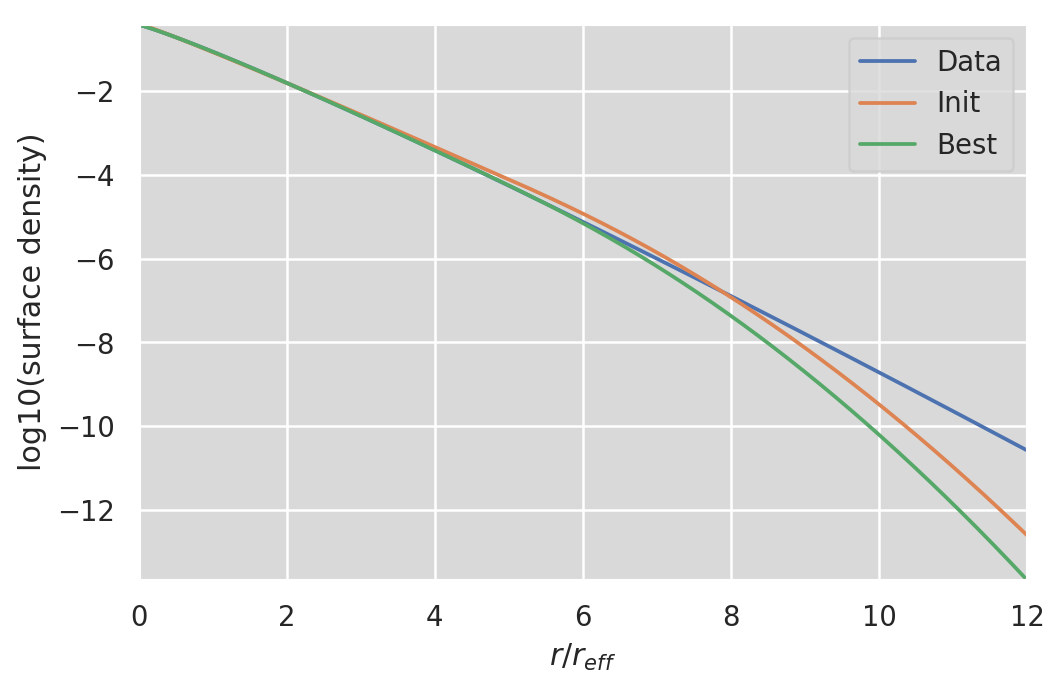

Init  chisq = -7.02552013403142
ws, re: (array([8.29449271e-02, 3.37371657e-01, 3.42939773e-01, 1.67551154e-01,
       5.37364254e-02, 1.28983283e-02, 2.30324447e-03, 2.54490187e-04]), array([1.95369467, 1.38804896, 0.96460162, 0.64520876, 0.41099448,
       0.24500806, 0.13172635, 0.05747899]))
         Current function value: -11.694331
         Iterations: 90
         Function evaluations: 2833
         Gradient evaluations: 166
-11.69433132400764 [-2.32226401 -0.44187223  0.4681851   0.96304997  1.30273284  1.65849114
  2.23790881  0.26461024  0.12594596 -0.02514642 -0.19482256 -0.38686318
 -0.60809025 -0.8740841  -1.23021408]
n=0.85: (
    normalize(np.array([8.9295774481e-02, 3.5635395908e-01, 3.4089997162e-01, 1.5448081819e-01, 4.6367378483e-02, 1.0586207953e-02, 1.8215633357e-03, 1.9432685769e-04])),
    np.array([1.8391207336e+00, 1.3364292193e+00, 9.4374264293e-01, 6.3852430856e-01, 4.1033335262e-01, 2.4655269337e-01, 1.3363367181e-01, 5.8855346344e-02]),
),
1.000000021676465

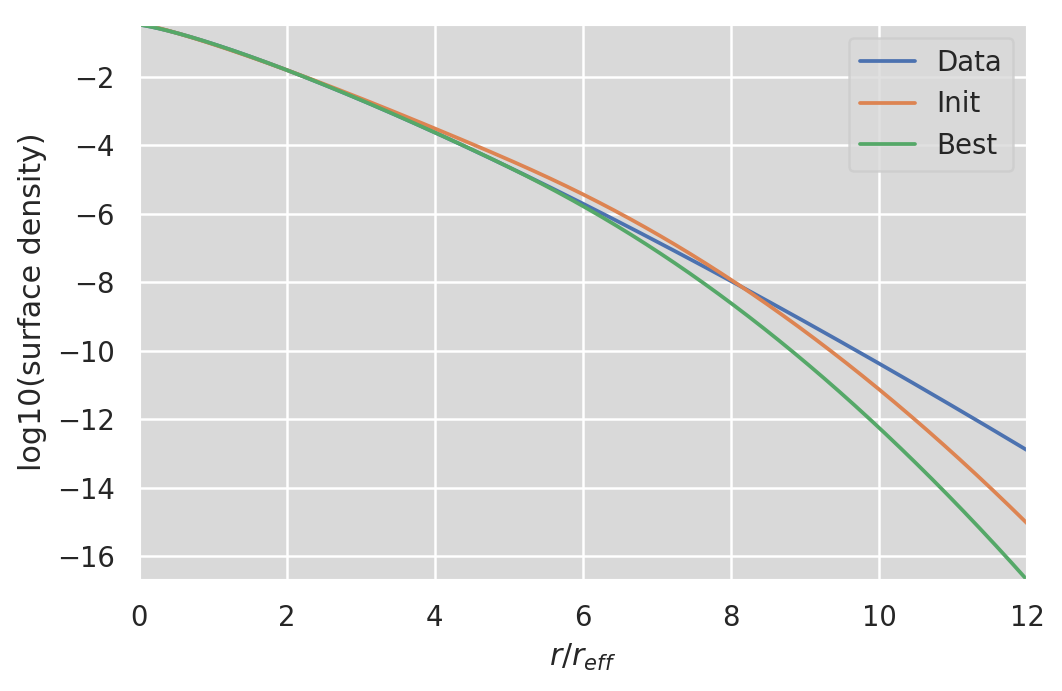

Init  chisq = -6.921481313230024
ws, re: (array([9.73594083e-02, 3.76326328e-01, 3.36086098e-01, 1.40674951e-01,
       3.94391161e-02, 8.55248272e-03, 1.41568155e-03, 1.45933879e-04]), array([1.72513705, 1.28585566, 0.92536514, 0.63459678, 0.41183005,
       0.24949254, 0.13638471, 0.06072822]))
         Current function value: -12.377141
         Iterations: 114
         Function evaluations: 3038
         Gradient evaluations: 178
-12.377141103157182 [-2.25211141 -0.27404148  0.66694483  1.1294116   1.42115378  1.74346593
  2.30884375  0.21213991  0.09788909 -0.03532965 -0.19276266 -0.37599953
 -0.58974059 -0.84797218 -1.19414293]
n=0.75: (
    normalize(np.array([9.5167494628e-02, 3.9081090139e-01, 3.3967509760e-01, 1.3175893673e-01, 3.4305106271e-02, 7.0494262755e-03, 1.1215789620e-03, 1.1145813102e-04])),
    np.array([1.6298210027e+00, 1.2528211963e+00, 9.2187141234e-01, 6.4156009607e-01, 4.2072708303e-01, 2.5719315745e-01, 1.4191484230e-01, 6.3952433382e-02]),
),
1.000000018785

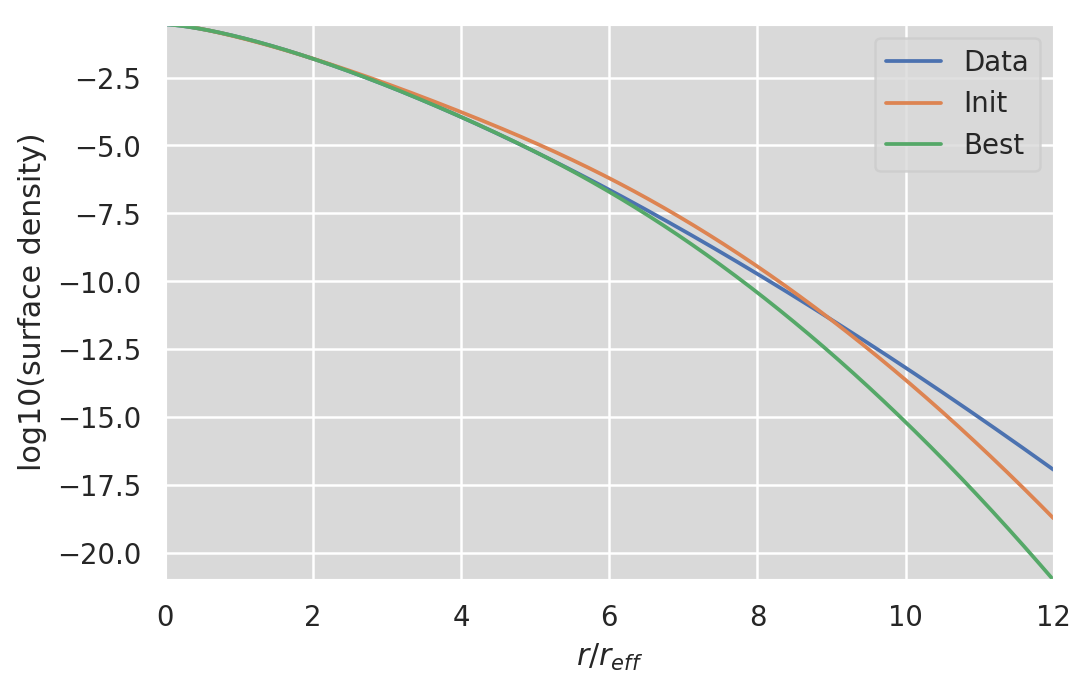

1.000000017532151 1.0000000182584923
Init  chisq = -6.812053504566393
ws, re: (array([0.11587736, 0.44937374, 0.31933869, 0.09418614, 0.01847811,
       0.00274596]), array([1.50858404, 1.18270647, 0.87020347, 0.5908365 , 0.36842091,
       0.2062253 ]))
         Current function value: -11.749242
         Iterations: 143
         Function evaluations: 2612
         Gradient evaluations: 200
-11.749242425948415 [-1.03647729  0.8126692   1.57987729  1.93635539  2.45160893  0.12351295
  0.01643889 -0.13169752 -0.32689105 -0.57317194 -0.90712598]
1.000000017532151 1.0000000174458115
n=0.65: (
    normalize(np.array([2.6183027504e-01, 5.1131393105e-01, 1.8810590649e-01, 3.3865510527e-02, 4.4969433749e-03, 3.8743351832e-04])),
    np.array([1.3289631973e+00, 1.0385774455e+00, 7.3841834696e-01, 4.7109549871e-01, 2.6719483672e-01, 1.2384372936e-01]),
),


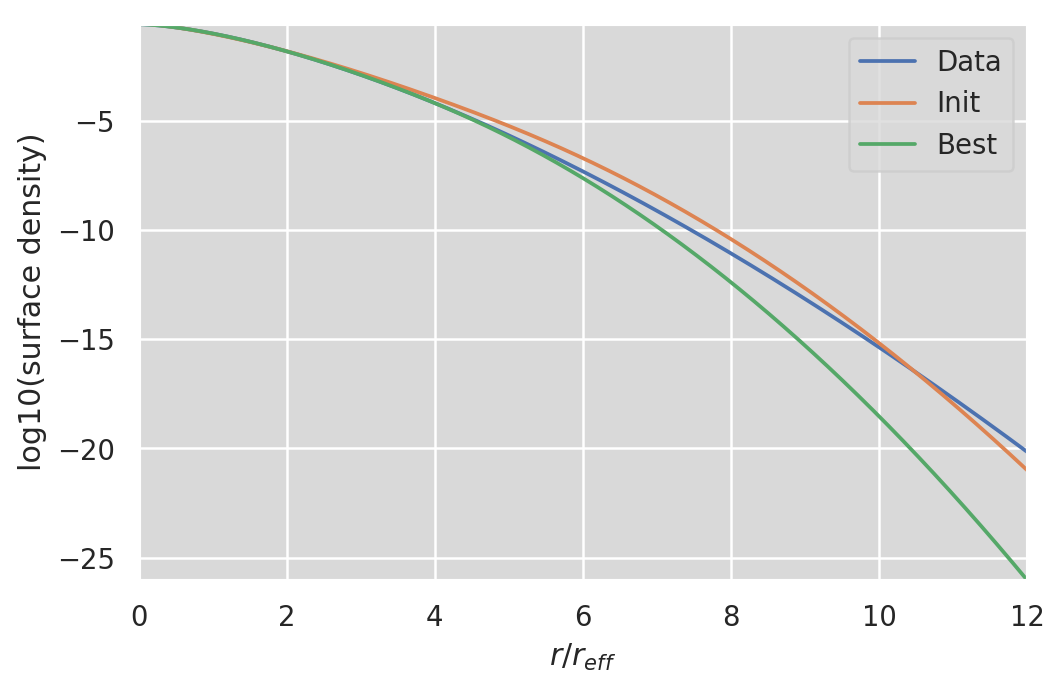

Init  chisq = -7.6095141772703165
ws, re: (array([0.40998043, 0.48679061, 0.09050881, 0.01203523, 0.00068493]), array([1.195 , 0.9656, 0.67  , 0.45  , 0.208 ]))
         Current function value: -11.443792
         Iterations: 47
         Function evaluations: 1211
         Gradient evaluations: 109
-11.443792062155998 [-0.34143151  1.51220842  2.13986148  2.59408027  0.08122373 -0.02055728
 -0.18595349 -0.42055999 -0.74691955]
n=0.6: (
    normalize(np.array([4.1546178873e-01, 4.7896375027e-01, 9.4459324448e-02, 1.0342408068e-02, 7.7272848509e-04])),
    np.array([1.2056568803e+00, 9.5376794968e-01, 6.5169818599e-01, 3.7969948423e-01, 1.7909375620e-01]),
),
1.0000000159710858 1.00000001632613
Init  chisq = -7.481980375282093
ws, re: (array([0.41546179, 0.47896375, 0.09445932, 0.01034241, 0.00077273]), array([1.20565688, 0.95376795, 0.65169819, 0.37969948, 0.17909376]))
         Current function value: -11.763399
         Iterations: 81
         Function evaluations: 1584
         Gradi

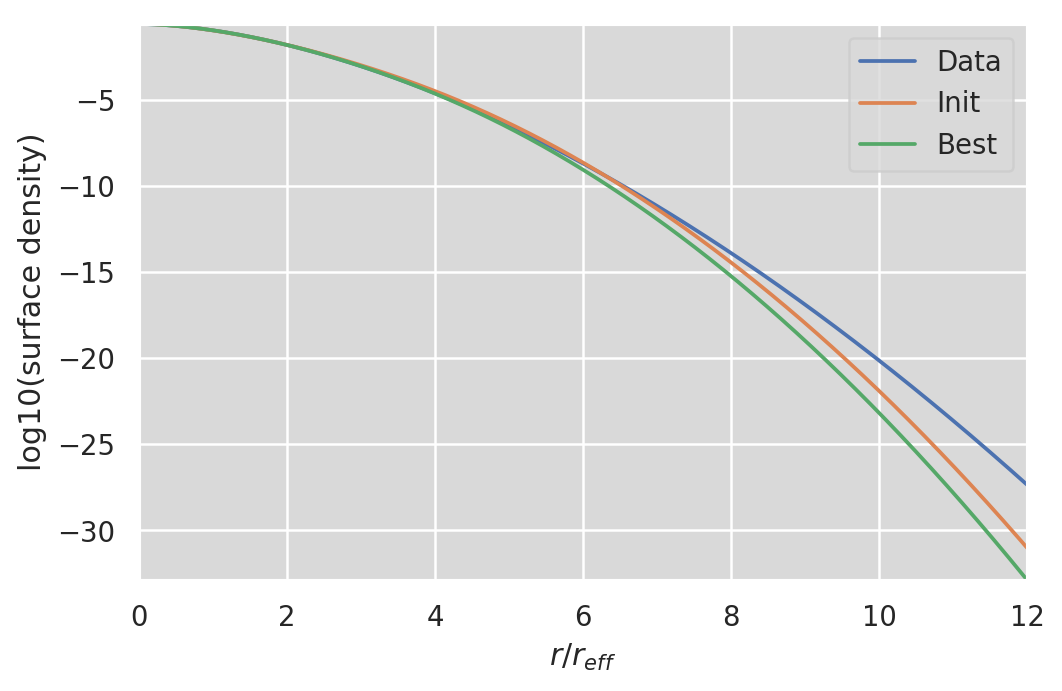

Init  chisq = -7.452188946154672
ws, re: (array([0.45627441, 0.4580142 , 0.07727318, 0.00786766, 0.00057055]), array([1.16834676, 0.94363227, 0.65093086, 0.38085302, 0.18069825]))
         Current function value: -12.151353
         Iterations: 97
         Function evaluations: 2013
         Gradient evaluations: 182
-12.151352723716515 [ 0.05535496  1.89423432  2.30636739  2.66082724  0.05289775 -0.03031657
 -0.18894567 -0.42170119 -0.74379745]
n=0.56: (
    normalize(np.array([5.1383520859e-01, 4.2259270295e-01, 5.7812648759e-02, 5.3832054183e-03, 3.7623428159e-04])),
    np.array([1.1295299365e+00, 9.3257427802e-01, 6.4722357532e-01, 3.7870305436e-01, 1.8038588490e-01]),
),
Init  chisq = -6.391817710965432
ws, re: (array([0.31176674, 0.50952197, 0.15184782, 0.02387212, 0.00299134]), array([1.26358302, 1.00696536, 0.72107801, 0.46050732, 0.26211134]))
         Current function value: -12.387044
         Iterations: 232
         Function evaluations: 3752
         Gradient evaluations

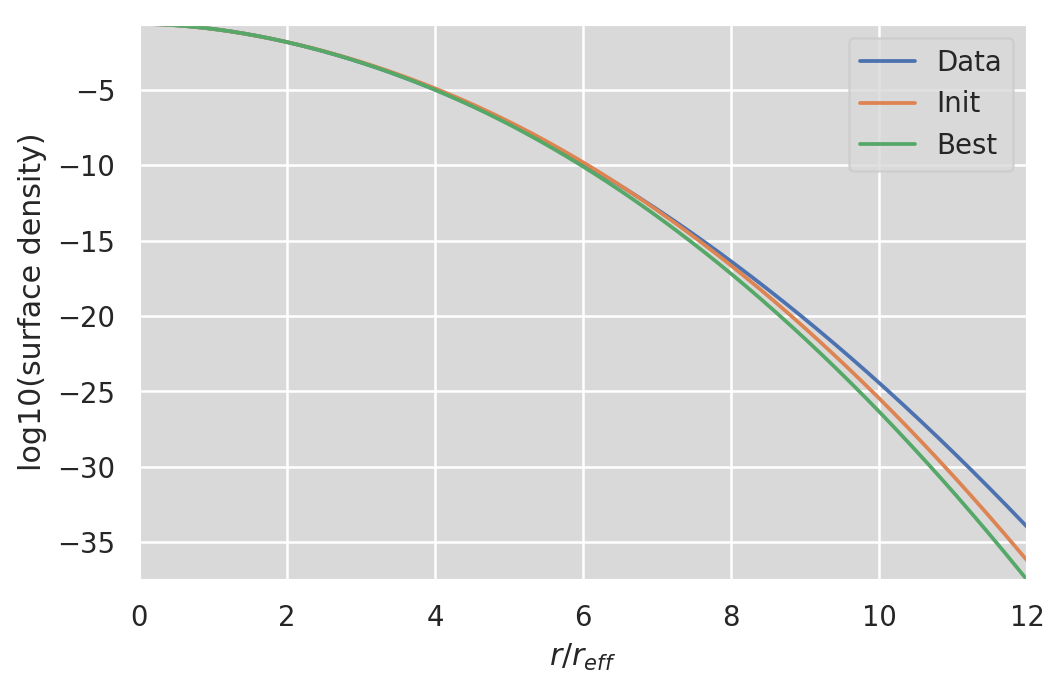

Init  chisq = -8.605663213534255
ws, re: (array([5.99198291e-01, 3.59488014e-01, 3.77713613e-02, 3.31450699e-03,
       2.27827024e-04]), array([1.08885318, 0.92149653, 0.64439709, 0.379284  , 0.18209937]))
         Current function value: -12.821095
         Iterations: 72
         Function evaluations: 2267
         Gradient evaluations: 205
-12.821095163184612 [ 0.53124641  2.25566855  2.3862771   2.68376608  0.03266247 -0.03731978
 -0.19304865 -0.42346368 -0.74166593]
n=0.535: (
    normalize(np.array([6.2977376980e-01, 3.3510596744e-01, 3.2162253723e-02, 2.7688795476e-03, 1.8912949458e-04])),
    np.array([1.0781085002e+00, 9.1765666119e-01, 6.4113774567e-01, 3.7716928873e-01, 1.8127339665e-01]),
),
1.000000014984337 1.0000000150648582
Init  chisq = -8.597601421155877
ws, re: (array([6.29773770e-01, 3.35105967e-01, 3.21622537e-02, 2.76887955e-03,
       1.89129495e-04]), array([1.0781085 , 0.91765666, 0.64113775, 0.37716929, 0.1812734 ]))
         Current function value: -12.99704

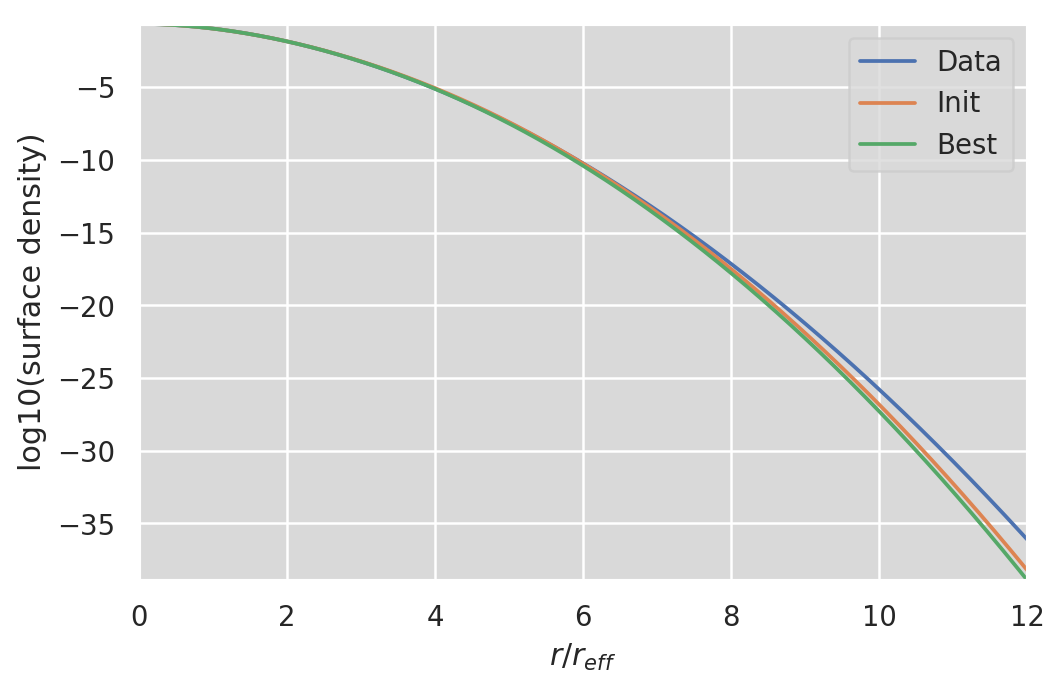

Init  chisq = -8.034436622248457
ws, re: (array([0.59933484, 0.35956993, 0.03777997, 0.00331526]), array([1.08885318, 0.92149653, 0.64439709, 0.379284  ]))
         Current function value: -11.866127
         Iterations: 73
         Function evaluations: 1191
         Gradient evaluations: 131
-11.86612675237935 [ 1.03949797  2.74177944  2.94245234  0.0252867  -0.05665531 -0.25646952
 -0.57025258]
n=0.53: (
    normalize(np.array([7.3875312820e-01, 2.4542769471e-01, 1.5026724116e-02, 7.9245297099e-04])),
    np.array([1.0599532357e+00, 8.7769714840e-01, 5.5402642897e-01, 2.6899699021e-01]),
),
1.000000014891245 1.0000000149610702
Init  chisq = -8.58937138783239
ws, re: (array([0.73875313, 0.24542769, 0.01502672, 0.00079245]), array([1.05995324, 0.87769715, 0.55402643, 0.26899699]))
         Current function value: -12.063909
         Iterations: 50
         Function evaluations: 1254
         Gradient evaluations: 138
-12.063908737481464 [ 1.20455043  2.8321562   2.95494346  0.02134281

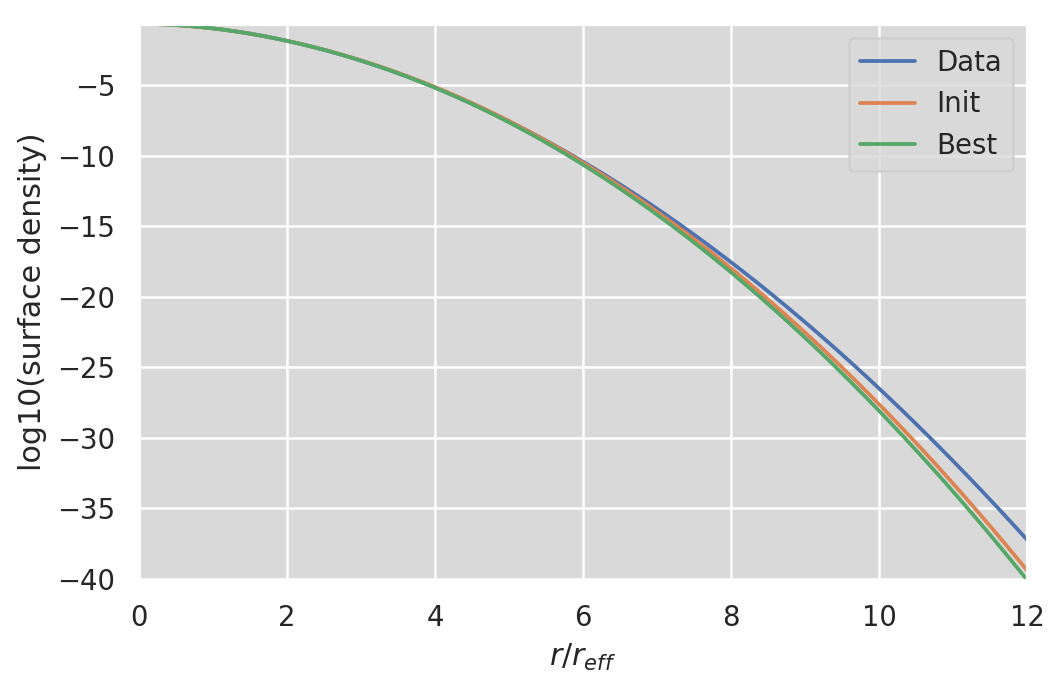

Init  chisq = -8.581147263182615
ws, re: (array([7.69333291e-01, 2.17839091e-01, 1.21926071e-02, 6.35010550e-04]), array([1.05037121, 0.87604763, 0.55238713, 0.26838442]))
         Current function value: -12.298731
         Iterations: 48
         Function evaluations: 992
         Gradient evaluations: 109
-12.29873135983647 [ 1.40175766  2.92573599  2.96500193  0.0173523  -0.05789957 -0.25827789
 -0.57114444]
n=0.52: (
    normalize(np.array([8.0246265385e-01, 1.8748350391e-01, 9.5608797516e-03, 4.9296249415e-04])),
    np.array([1.0407640924e+00, 8.7518613346e-01, 5.5172430276e-01, 2.6844514757e-01]),
),
1.0000000147080328 1.0000000147850436
Init  chisq = -8.572849964440458
ws, re: (array([8.02462654e-01, 1.87483504e-01, 9.56087975e-03, 4.92962494e-04]), array([1.04076409, 0.87518613, 0.5517243 , 0.26844515]))
         Current function value: -12.591653
         Iterations: 62
         Function evaluations: 1569
         Gradient evaluations: 173
-12.591653387057086 [ 1.66793065  3

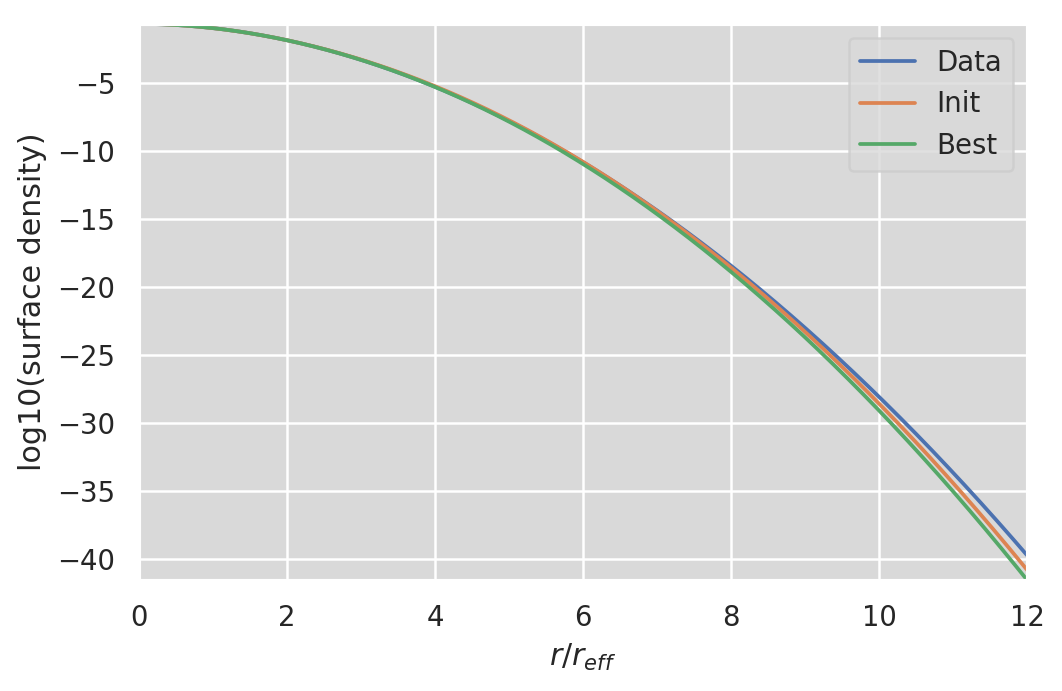

In [5]:
# np.round(10**np.linspace(np.log10(0.5005), np.log10(6.3), num=200), 4)
# First attempt to manually finagle a smooth spline with free weights and radii while gradually removing components
# It does not work very well

# These initial parameters are not terribly important
nvals = [
    (
        np.array([0.501]),
        (normalize(np.array([0.98, 0.02])), np.array([1.01, 0.9])),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'])
nvals = [
    (
        np.array([0.507]),
        (
    normalize(np.array([8.7013734755e-01, 1.2619085952e-01, 3.6717929279e-03])),
    np.array([1.0339248832e+00, 8.1955230658e-01, 4.2170643991e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'])
# The rest of these required working backwards and repeatedly re-starting guesses to produce a smooth spline
nvals = [
    (
        np.array([0.95, 0.9, 0.85, 0.8, 0.75]),
        (
	normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01, 6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
	np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=2)
nvals = [
    (
        np.array([0.70]),
        (
    normalize(np.array([1.0845562525e-01, 4.0294151495e-01, 3.2729844440e-01, 1.2246687144e-01, 3.1333936150e-02, 6.3893051250e-03, 1.0137209694e-03])),
    np.array([1.6116987996e+00, 1.2333069456e+00, 9.0359039048e-01, 6.2645430811e-01, 4.0957694795e-01, 2.5288574221e-01, 1.3272691536e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'])
nvals = [
    (
        np.array([0.65]),
        (
    normalize(np.array([1.1584759935e-01, 4.4925832966e-01, 3.1925666847e-01, 9.4161947089e-02, 1.8473365773e-02, 2.7452558180e-03])),
    np.array([1.5085840400e+00, 1.1827064676e+00, 8.7020346704e-01, 5.9083650141e-01, 3.6842090584e-01, 2.0622530253e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'])
nvals = [
    (
        np.array([0.6, 0.58, 0.56]),
        (
            normalize(np.array([4.19e-01        , 4.975e-01       , 9.25e-02        , 1.23e-02        , 7.0e-04])),
            np.array([1.195e+00       , 9.656e-01       , 6.7e-01       , 4.5e-01       , 2.08e-01        ]),
        )
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=2)
nvals = [
    (
        np.array([0.55, 0.54, 0.535, 0.53]),
        (
    normalize(np.array([3.1168895061e-01, 5.0939483801e-01, 1.5180993252e-01, 2.3866167881e-02, 2.9905915132e-03])),
    np.array([1.2635830241e+00, 1.0069653570e+00, 7.2107800516e-01, 4.6050732036e-01, 2.6211133918e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=2)
nvals = [
    (
        np.array([0.53, 0.525, 0.52, 0.515]),
        (
    normalize(np.array([5.9919829101e-01, 3.5948801370e-01, 3.7771361281e-02, 3.3145069862e-03])),
    np.array([1.0888531764e+00, 9.2149653125e-01, 6.4439708848e-01, 3.7928399702e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=2)

## Why can't you just fit N components down to n=0.5?

You can try, but it doesn't work well below n=0.6 as the smallest component(s) gradually reduce their weights to near-zero values. Once this happens, it becomes very difficult to ensure smooth changes in the best-fit weight even given small changes in n - the best-fit weights are essentially 'noisy'.

Init  chisq = -10.92882749800659
ws, re: (array([0.07790019, 0.31264016, 0.33937179, 0.1839253 , 0.06541804,
       0.01709507, 0.00326612, 0.00038332]), array([2.17045661, 1.47679133, 0.99494464, 0.65054022, 0.40699848,
       0.23877605, 0.12631553, 0.05405815]))
         Current function value: -10.928831
         Iterations: 11
         Function evaluations: 1185
         Gradient evaluations: 69
-10.928831306589267 [-2.47095375e+00 -6.67489981e-01  2.28175095e-01  7.58180742e-01
  1.14859215e+00  1.54422292e+00  2.14252775e+00  3.36535868e-01
  1.69305642e-01 -2.20048990e-03 -1.86707161e-01 -3.90387752e-01
 -6.21998233e-01 -8.98532198e-01 -1.26716661e+00]
n=1.0: (
    normalize(np.array([7.7919682300e-02, 3.1263972612e-01, 3.3933503571e-01, 1.8393070736e-01, 6.5428570239e-02, 1.7096546835e-02, 3.2663945086e-03, 3.8333692824e-04])),
    np.array([2.1703804472e+00, 1.4767454532e+00, 9.9494599942e-01, 6.5056821172e-01, 4.0701671809e-01, 2.3878209990e-01, 1.2631874480e-01, 5.405469062

         Current function value: -11.108129
         Iterations: 31
         Function evaluations: 2154
         Gradient evaluations: 126
-11.108129091164827 [-2.43454043 -0.61376267  0.28474401  0.80742294  1.18696884  1.57348645
  2.16692768  0.31820997  0.15800816 -0.00845507 -0.18919264 -0.38984782
 -0.61876171 -0.89260239 -1.25807169]
n=0.96: (
    normalize(np.array([8.0576453325e-02, 3.2290280030e-01, 3.4043969613e-01, 1.7709543098e-01, 6.0518663358e-02, 1.5295811356e-02, 2.8452778659e-03, 3.2586667691e-04])),
    np.array([2.0807024304e+00, 1.4388256059e+00, 9.8071976898e-01, 6.4685562505e-01, 4.0752304916e-01, 2.4056824190e-01, 1.2805531444e-01, 5.5198631668e-02]),
),
1.0000000187578688 1.0000000268654716
Init  chisq = -9.098197918508665
ws, re: (array([8.05764533e-02, 3.22902800e-01, 3.40439696e-01, 1.77095431e-01,
       6.05186634e-02, 1.52958114e-02, 2.84527787e-03, 3.25866677e-04]), array([2.08070243, 1.43882561, 0.98071977, 0.64685563, 0.40752305,
       0.24056824, 0.1

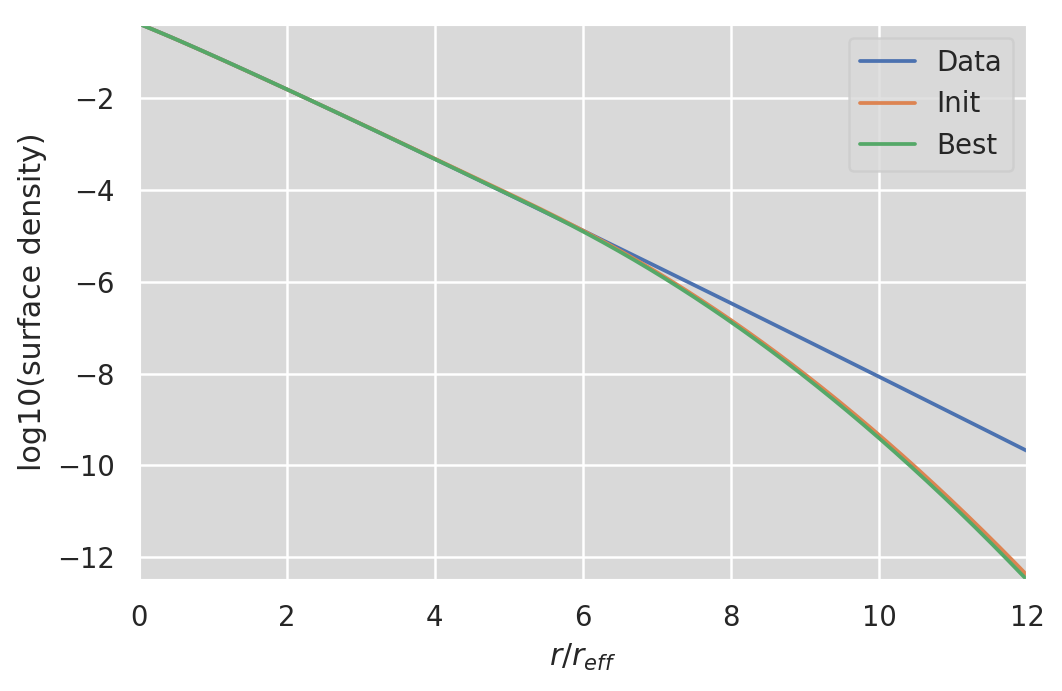

Init  chisq = -9.094011485824725
ws, re: (array([8.10409668e-02, 3.24410655e-01, 3.40470606e-01, 1.76071171e-01,
       5.98381330e-02, 1.50580952e-02, 2.79159137e-03, 3.18782319e-04]), array([2.06920039, 1.43376271, 0.97867808, 0.64620078, 0.40746272,
       0.24072384, 0.128242  , 0.0553357 ]))
         Current function value: -11.155314
         Iterations: 36
         Function evaluations: 2069
         Gradient evaluations: 121
-11.155313881284531 [-2.42280348 -0.5982304   0.30047885  0.82073382  1.19703641  1.58101362
  2.17312395  0.31342707  0.1549982  -0.01020124 -0.19000346 -0.3899095
 -0.61814701 -0.89130535 -1.2559478 ]
n=0.95: (
    normalize(np.array([8.1450263763e-02, 3.2585428363e-01, 3.4053884485e-01, 1.7509555332e-01, 5.9182670718e-02, 1.4827402200e-02, 2.7392015200e-03, 3.1177999432e-04])),
    np.array([2.0579132805e+00, 1.4288880244e+00, 9.7678450884e-01, 6.4564909129e-01, 4.0746517450e-01, 2.4090898319e-01, 1.2843833062e-01, 5.5469238331e-02]),
),
Init  chisq = -9

         Current function value: -11.355373
         Iterations: 35
         Function evaluations: 2188
         Gradient evaluations: 128
-11.355372996771438 [-2.3809131  -0.53767461  0.36408476  0.87524761  1.23877439  1.61182703
  2.19764446  0.29424459  0.14331286 -0.01653578 -0.19244547 -0.38932121
 -0.61489168 -0.88525939 -1.2464123 ]
n=0.91: (
    normalize(np.array([8.4639795367e-02, 3.3751957246e-01, 3.4094265997e-01, 1.6721122181e-01, 5.4031664252e-02, 1.3051095694e-02, 2.3436897899e-03, 2.6030065902e-04])),
    np.array([1.9689949080e+00, 1.3909543026e+00, 9.6264069091e-01, 6.4202882897e-01, 4.0801749857e-01, 2.4272153789e-01, 1.3023886593e-01, 5.6700605787e-02]),
),
1.0000000241722848 1.0000000250549903
Init  chisq = -9.05457269094394
ws, re: (array([8.46397954e-02, 3.37519572e-01, 3.40942660e-01, 1.67211222e-01,
       5.40316643e-02, 1.30510957e-02, 2.34368979e-03, 2.60300659e-04]), array([1.96899491, 1.3909543 , 0.96264069, 0.64202883, 0.4080175 ,
       0.24272154, 0.13

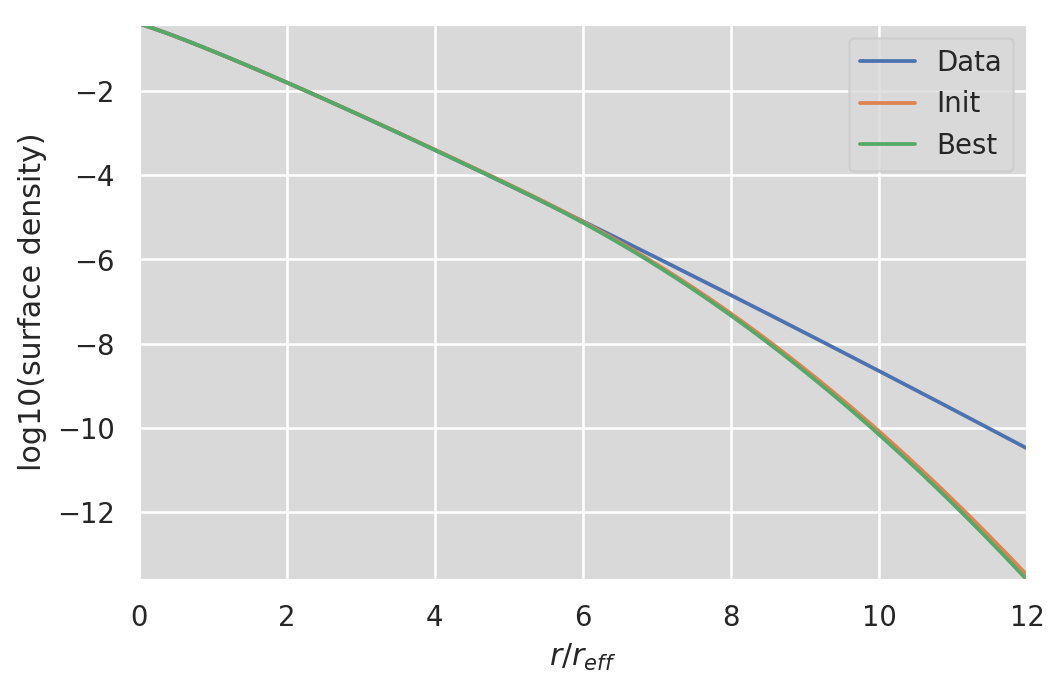

Init  chisq = -9.050220838922645
ws, re: (array([8.48825460e-02, 3.38782501e-01, 3.41070160e-01, 1.66367064e-01,
       5.34734248e-02, 1.28663795e-02, 2.30305236e-03, 2.54873067e-04]), array([1.95842511, 1.38672691, 0.96135347, 0.64197487, 0.40840316,
       0.24318357, 0.13059145, 0.05689129]))
         Current function value: -11.408332
         Iterations: 34
         Function evaluations: 2358
         Gradient evaluations: 138
-11.408331965529769 [-2.36726083 -0.52114209  0.38029982  0.88888783  1.24906014  1.6189666
  2.20384114  0.28921237  0.14023105 -0.0181681  -0.19300413 -0.38906154
 -0.61390307 -0.88347903 -1.24394659]
n=0.9: (
    normalize(np.array([8.5703533382e-02, 3.4065334348e-01, 3.4071270247e-01, 1.6506861300e-01, 5.2737930095e-02, 1.2623183173e-02, 2.2521101669e-03, 2.4858423528e-04])),
    np.array([1.9463115926e+00, 1.3811188552e+00, 9.5902935245e-01, 6.4120347915e-01, 4.0826152697e-01, 2.4327469001e-01, 1.3077386669e-01, 5.7023439004e-02]),
),
Init  chisq = -9.

         Current function value: -11.631710
         Iterations: 36
         Function evaluations: 2596
         Gradient evaluations: 152
-11.63171005411431 [-2.29072559 -0.4321667   0.46552082  0.9558258   1.29545723  1.65208373
  2.23098538  0.26789852  0.12634012 -0.02699432 -0.198317   -0.3915797
 -0.6137924  -0.88066932 -1.237653  ]
n=0.86: (
    normalize(np.array([9.1893982144e-02, 3.5743875849e-01, 3.3828758883e-01, 1.5339871037e-01, 4.6304149921e-02, 1.0638030221e-02, 1.8410136879e-03, 1.9776634136e-04])),
    np.array([1.8530985676e+00, 1.3376427022e+00, 9.3973559093e-01, 6.3340721094e-01, 4.0590116707e-01, 2.4333669448e-01, 1.3162266643e-01, 5.7855812756e-02]),
),
1.000000023415158 1.0000000233647142
Init  chisq = -9.007458595963694
ws, re: (array([9.18939821e-02, 3.57438758e-01, 3.38287589e-01, 1.53398710e-01,
       4.63041499e-02, 1.06380302e-02, 1.84101369e-03, 1.97766341e-04]), array([1.85309857, 1.3376427 , 0.93973559, 0.63340721, 0.40590117,
       0.24333669, 0.1316

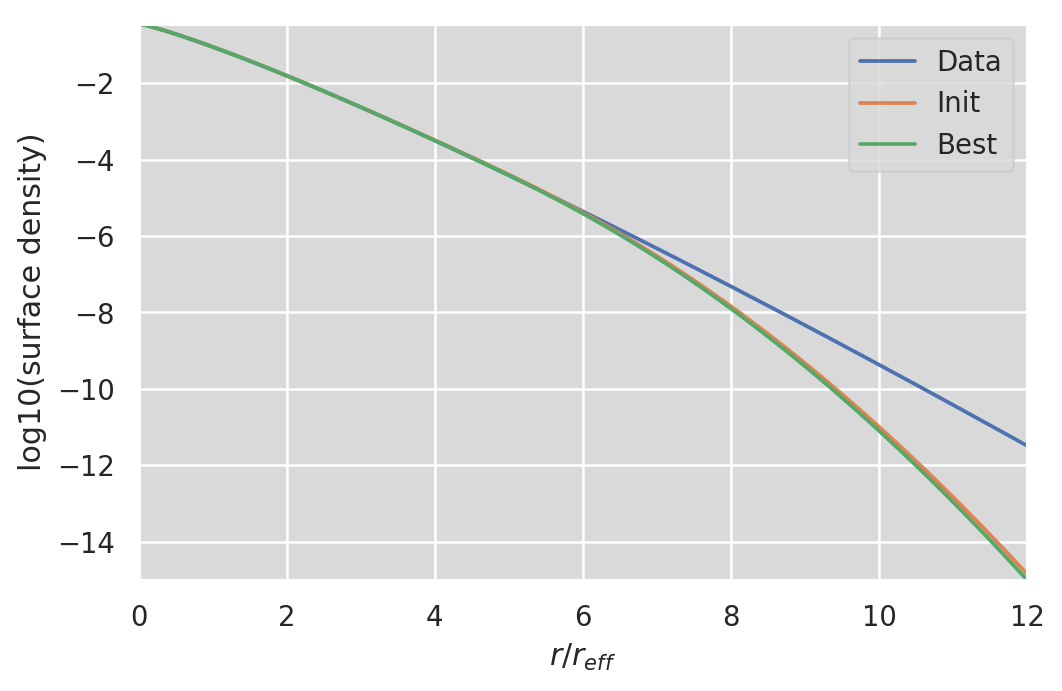

Init  chisq = -9.002496180511976
ws, re: (array([9.29922775e-02, 3.59909913e-01, 3.37655304e-01, 1.51657100e-01,
       4.54234003e-02, 1.03803189e-02, 1.79003204e-03, 1.91653352e-04]), array([1.84099463, 1.33172697, 0.93692248, 0.63212526, 0.40539697,
       0.24322592, 0.13167802, 0.05793807]))
         Current function value: -11.691210
         Iterations: 35
         Function evaluations: 1865
         Gradient evaluations: 109
-11.691210330589094 [-2.27101818 -0.40943102  0.4873195   0.97291372  1.30711573  1.65997052
  2.23758479  0.26247311  0.1228866  -0.02908315 -0.19947444 -0.3920163
 -0.61354004 -0.87966614 -1.23575612]
n=0.85: (
    normalize(np.array([9.3551835240e-02, 3.6171683549e-01, 3.3744731541e-01, 1.5042598438e-01, 4.4748981349e-02, 1.0174434506e-02, 1.7480670208e-03, 1.8654660696e-04])),
    np.array([1.8300927975e+00, 1.3270479040e+00, 9.3522659525e-01, 6.3172135114e-01, 4.0549331641e-01, 2.4347813221e-01, 1.3192705300e-01, 5.8109063390e-02]),
),
Init  chisq = -8

         Current function value: -11.951039
         Iterations: 56
         Function evaluations: 2851
         Gradient evaluations: 167
-11.951039086868507 [-2.27166644 -0.36794953  0.54890236  1.03222718  1.3532923   1.69446433
  2.26613687  0.24347969  0.11376002 -0.0309467  -0.19644045 -0.38562144
 -0.60438076 -0.86763966 -1.21999116]
n=0.81: (
    normalize(np.array([9.3496877139e-02, 3.7079293837e-01, 3.3957644974e-01, 1.4461870966e-01, 4.0937308901e-02, 8.9361642321e-03, 1.4873009162e-03, 1.5425104311e-04])),
    np.array([1.7517805029e+00, 1.2994513277e+00, 9.3122215357e-01, 6.3615002551e-01, 4.1150826647e-01, 2.4866762093e-01, 1.3563143012e-01, 6.0257185067e-02]),
),
1.000000021834481 1.0000000217850566
Init  chisq = -8.956537516071345
ws, re: (array([9.34968771e-02, 3.70792938e-01, 3.39576450e-01, 1.44618710e-01,
       4.09373089e-02, 8.93616423e-03, 1.48730092e-03, 1.54251043e-04]), array([1.7517805 , 1.29945133, 0.93122215, 0.63615003, 0.41150827,
       0.24866762, 0.13

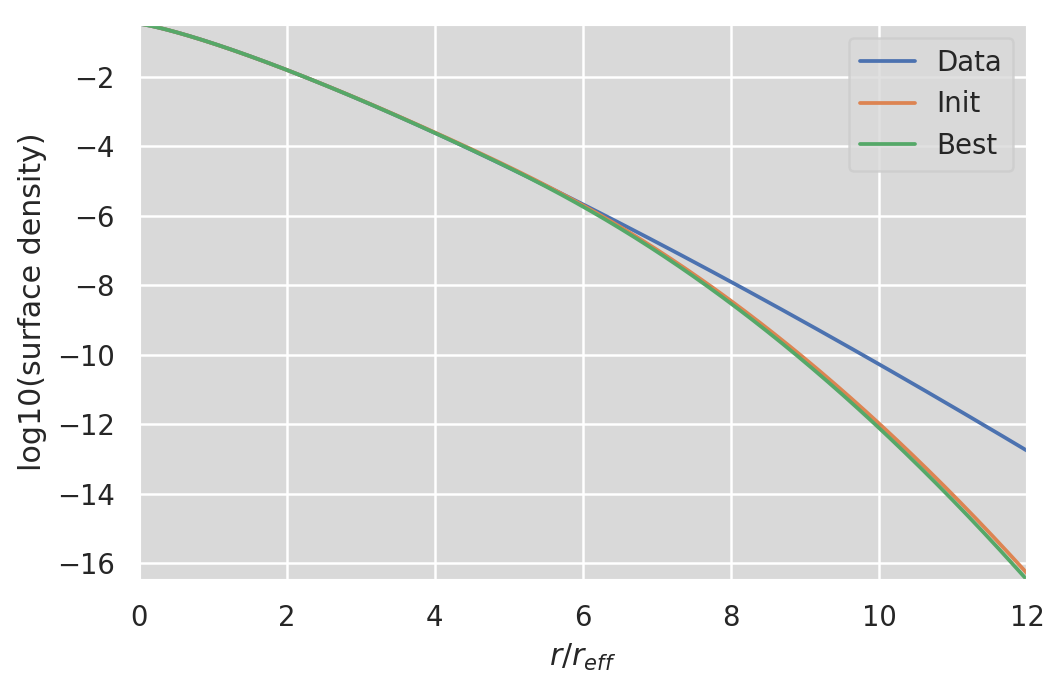

Init  chisq = -8.95132660663413
ws, re: (array([9.49841759e-02, 3.73822160e-01, 3.38408673e-01, 1.42508036e-01,
       4.00037145e-02, 8.68389195e-03, 1.44034094e-03, 1.49007403e-04]), array([1.73928693, 1.2930701 , 0.92809677, 0.63472325, 0.41093966,
       0.24853669, 0.13569676, 0.06036247]))
         Current function value: -12.020693
         Iterations: 50
         Function evaluations: 2732
         Gradient evaluations: 160
-12.020693366756822 [-2.23288269 -0.3321071   0.57748593  1.05039779  1.36361735  1.70110129
  2.27181277  0.2371165   0.10927256 -0.03412604 -0.19861661 -0.38687714
 -0.60473491 -0.86707062 -1.21846627]
n=0.8: (
    normalize(np.array([9.6836231121e-02, 3.7727681530e-01, 3.3682465858e-01, 1.4006704302e-01, 3.9017221139e-02, 8.4382063067e-03, 1.3958748554e-03, 1.4394968957e-04])),
    np.array([1.7263009193e+00, 1.2860935640e+00, 9.2442985663e-01, 6.3297037972e-01, 4.1032016071e-01, 2.4846492746e-01, 1.3580925809e-01, 6.0469131878e-02]),
),
Init  chisq = -8.

         Current function value: -12.318817
         Iterations: 54
         Function evaluations: 1915
         Gradient evaluations: 112
-12.31881722485979 [-2.12743313 -0.21962662  0.67843606  1.1235789   1.4113273   1.73296171
  2.29893098  0.21318176  0.09445779 -0.04232644 -0.20222665 -0.38708284
 -0.60187284 -0.86088041 -1.20770384]
n=0.76: (
    normalize(np.array([1.0645891953e-01, 3.9790545178e-01, 3.2879949786e-01, 1.2590321348e-01, 3.2909050804e-02, 6.8186084872e-03, 1.0953246246e-03, 1.0993343910e-04])),
    np.array([1.6337355608e+00, 1.2429618207e+00, 9.0713841819e-01, 6.2773067633e-01, 4.1012586135e-01, 2.5010775541e-01, 1.3775887552e-01, 6.1986363244e-02]),
),
1.0000000203099735 1.0000000203250463
Init  chisq = -8.902219532033492
ws, re: (array([1.06458920e-01, 3.97905452e-01, 3.28799498e-01, 1.25903213e-01,
       3.29090508e-02, 6.81860849e-03, 1.09532462e-03, 1.09933439e-04]), array([1.63373556, 1.24296182, 0.90713842, 0.62773068, 0.41012586,
       0.25010776, 0.13

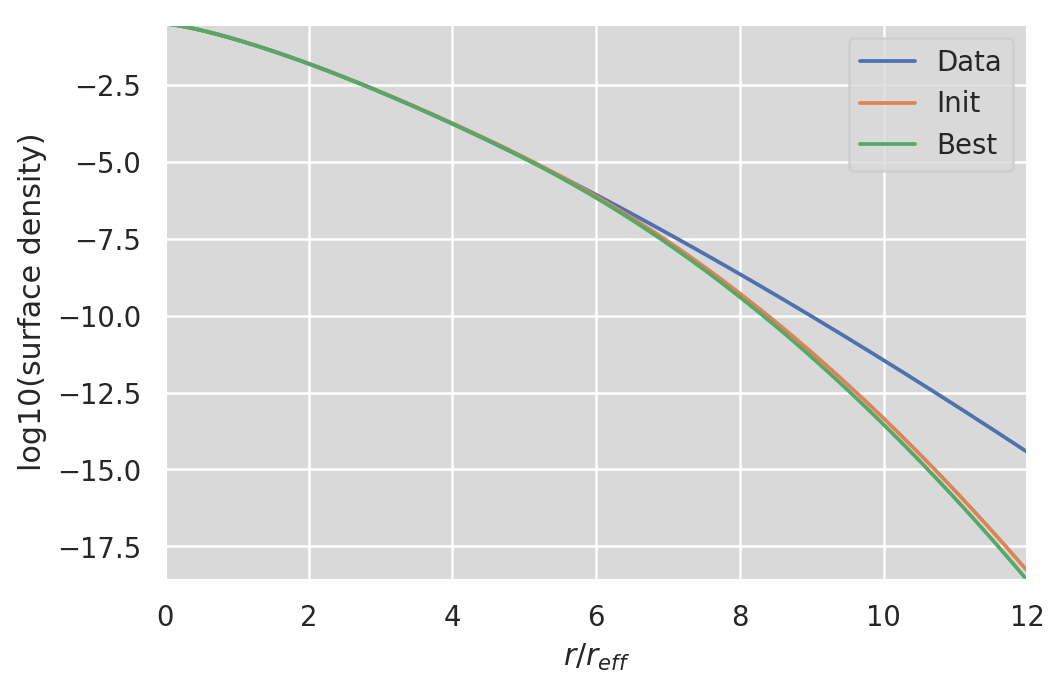

Init  chisq = -8.896438028194853
ws, re: (array([1.11658504e-01, 4.04366102e-01, 3.23898887e-01, 1.21227627e-01,
       3.12910710e-02, 6.42830460e-03, 1.02668432e-03, 1.02819824e-04]), array([1.61727712, 1.23188183, 0.89941757, 0.62251999, 0.40679579,
       0.24806596, 0.13670966, 0.06156035]))
         Current function value: -12.387657
         Iterations: 55
         Function evaluations: 2460
         Gradient evaluations: 144
-12.387656716441676 [-2.01010529 -0.12911216  0.74217964  1.16147795  1.43269608  1.7468172
  2.30969177  0.20408124  0.08604556 -0.05096599 -0.21148494 -0.39684264
 -0.6118431  -0.87078184 -1.21748689]
n=0.75: (
    normalize(np.array([1.1814600743e-01, 4.1250195292e-01, 3.1797300530e-01, 1.1529044862e-01, 2.9135074884e-02, 5.9212684740e-03, 9.3900666303e-04, 9.3235710220e-05])),
    np.array([1.5998572704e+00, 1.2191174793e+00, 8.8927075077e-01, 6.1449033889e-01, 4.0101199477e-01, 2.4443134582e-01, 1.3465365850e-01, 6.0605648890e-02]),
),
Init  chisq = -8

         Current function value: -12.752434
         Iterations: 49
         Function evaluations: 1745
         Gradient evaluations: 102
-12.752433509694324 [-1.96415885 -0.0469067   0.833851    1.23509372  1.48604074  1.78171178
  2.32919937  0.18137319  0.07502223 -0.05315671 -0.20789073 -0.38959465
 -0.60177919 -0.85696803 -1.19800219]
n=0.71: (
    normalize(np.array([1.2301766942e-01, 4.2820896393e-01, 3.1287069411e-01, 1.0528500320e-01, 2.4968196974e-02, 4.8354291996e-03, 7.4181036586e-04, 7.2232802591e-05])),
    np.array([1.5183545428e+00, 1.1885630512e+00, 8.8479628683e-01, 6.1959695114e-01, 4.0776068481e-01, 2.5016169561e-01, 1.3900549496e-01, 6.3386651622e-02]),
),
1.000000018917862 1.0000000189775258
Init  chisq = -8.84334234993595
ws, re: (array([1.23017669e-01, 4.28208964e-01, 3.12870694e-01, 1.05285003e-01,
       2.49681970e-02, 4.83542920e-03, 7.41810366e-04, 7.22328026e-05]), array([1.51835454, 1.18856305, 0.88479629, 0.61959695, 0.40776068,
       0.2501617 , 0.139

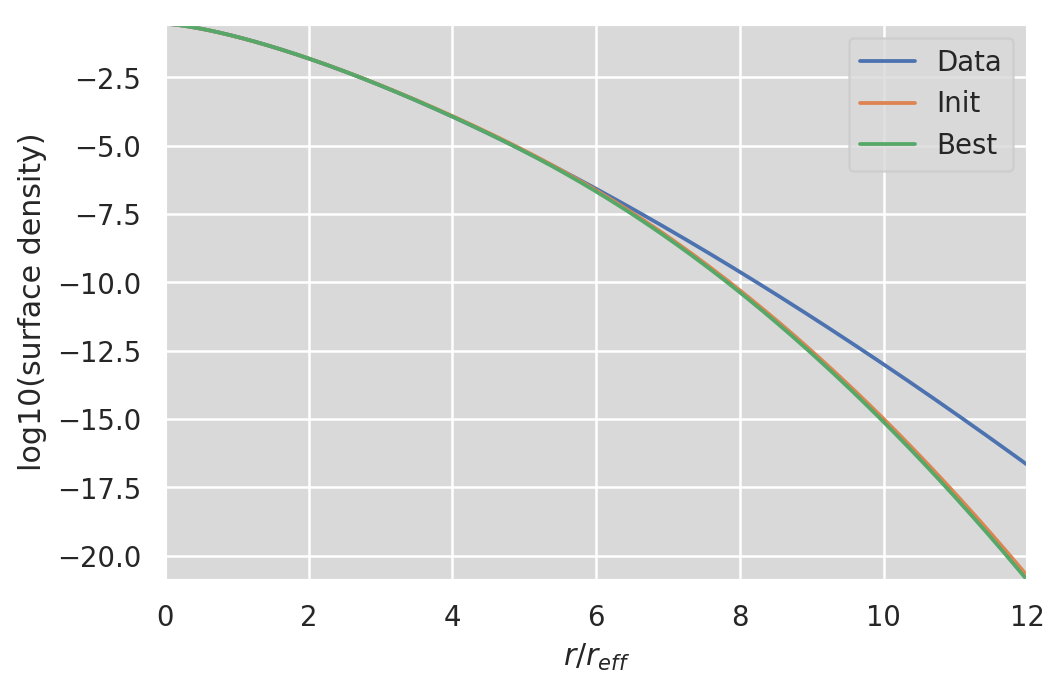

Init  chisq = -8.837035796514835
ws, re: (array([1.18860070e-01, 4.24992239e-01, 3.17095387e-01, 1.07598393e-01,
       2.56017877e-02, 5.00563923e-03, 7.72343699e-04, 7.41403853e-05]), array([1.51242006, 1.19092339, 0.89156264, 0.62727144, 0.41473984,
       0.25572401, 0.14235321, 0.0648052 ]))
         Current function value: -12.836196
         Iterations: 55
         Function evaluations: 2885
         Gradient evaluations: 169
-12.836195926284544 [-2.02634642 -0.06510956  0.84653004  1.25470345  1.4953514   1.78959463
  2.34956749  0.1776053   0.07539544 -0.04957865 -0.20252672 -0.38304653
 -0.59386627 -0.84831711 -1.18944792]
n=0.7: (
    normalize(np.array([1.1646435020e-01, 4.2739124945e-01, 3.1922751878e-01, 1.0653680383e-01, 2.4816881868e-02, 4.7669777519e-03, 7.2686739303e-04, 6.9350722705e-05])),
    np.array([1.5052384522e+00, 1.1895849021e+00, 8.9211604870e-01, 6.2729710480e-01, 4.1395531956e-01, 2.5476146085e-01, 1.4180217436e-01, 6.4647551382e-02]),
),
Init  chisq = -8

         Current function value: -13.206225
         Iterations: 89
         Function evaluations: 2766
         Gradient evaluations: 162
-13.20622459115982 [-1.5508858   0.30695544  1.07955717  1.35601181  1.53598182  1.81541249
  2.3779018   0.1420052   0.0458011  -0.07722513 -0.22942512 -0.40791523
 -0.61580383 -0.86681761 -1.20371666]
n=0.6599999999999999: (
    normalize(np.array([1.7495836805e-01, 4.7534109054e-01, 2.6102004180e-01, 7.0510818366e-02, 1.4951464412e-02, 2.7677139481e-03, 4.1226717645e-04, 3.8235707351e-05])),
    np.array([1.3867724247e+00, 1.1112226979e+00, 8.3709524056e-01, 5.8962362730e-01, 3.9091719053e-01, 2.4221228746e-01, 1.3588840170e-01, 6.2558069060e-02]),
),
1.000000017652129 1.0000000177381159
Init  chisq = -8.779955891631069
ws, re: (array([1.74958368e-01, 4.75341091e-01, 2.61020042e-01, 7.05108184e-02,
       1.49514644e-02, 2.76771395e-03, 4.12267176e-04, 3.82357074e-05]), array([1.38677242, 1.1112227 , 0.83709524, 0.58962363, 0.39091719,
       0.2

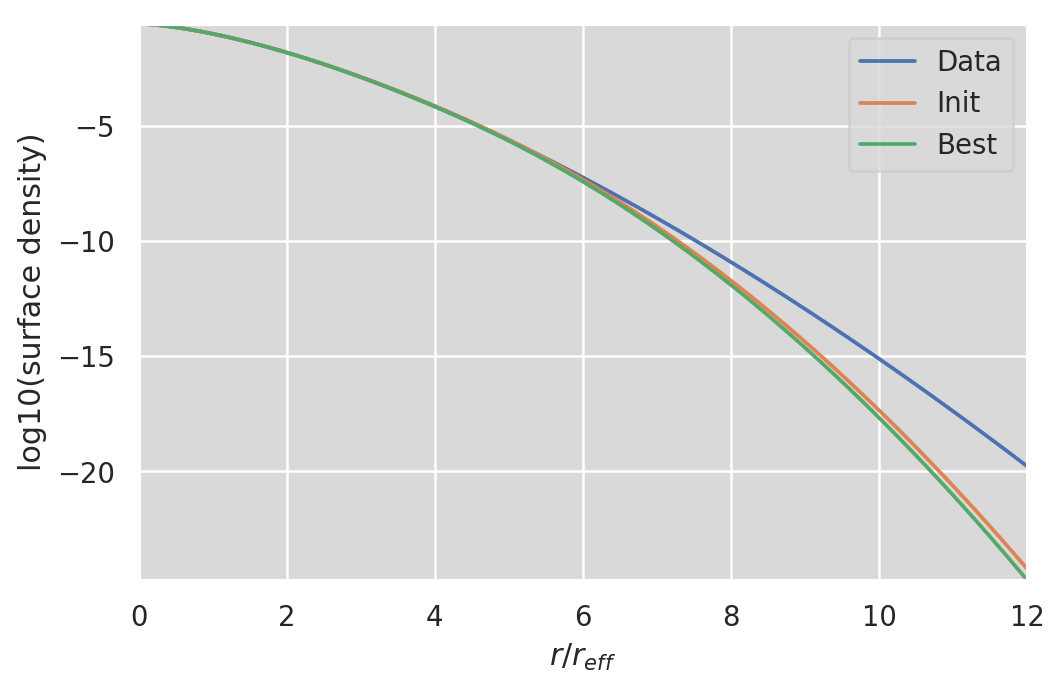

Init  chisq = -8.773501785470717
ws, re: (array([1.87668122e-01, 4.81358044e-01, 2.49080062e-01, 6.51043455e-02,
       1.37914859e-02, 2.57707689e-03, 3.85180738e-04, 3.56825943e-05]), array([1.37084587, 1.09904803, 0.82715391, 0.58296331, 0.38776358,
       0.24108486, 0.13554294, 0.06249595]))
         Current function value: -13.272247
         Iterations: 81
         Function evaluations: 3072
         Gradient evaluations: 180
-13.272247126782096 [-1.45624527  0.38719533  1.12524614  1.37724392  1.57349117  1.86166418
  2.40406768  0.13390675  0.03988754 -0.08194931 -0.23318908 -0.41174118
 -0.62228299 -0.875992   -1.21318523]
n=0.6499999999999999: (
    normalize(np.array([1.8904227379e-01, 4.8301238206e-01, 2.4758578905e-01, 6.4170961711e-02, 1.3408699996e-02, 2.4059721654e-03, 3.4293697420e-04, 3.0984249648e-05])),
    np.array([1.3611523811e+00, 1.0961942930e+00, 8.2803881014e-01, 5.8453553420e-01, 3.8748850016e-01, 2.3862558896e-01, 1.3304789179e-01, 6.1208927233e-02]),
),
I

         Current function value: -13.323834
         Iterations: 65
         Function evaluations: 3106
         Gradient evaluations: 182
-13.32383416346454 [-1.11980227  0.55026678  0.88409934  1.15352843  1.56766214  1.89580424
  2.41776162  0.10241459  0.02246999 -0.07756041 -0.19233005 -0.34670447
 -0.54742993 -0.79425599 -1.12357515]
n=0.61: (
    normalize(np.array([2.4604796254e-01, 4.7815448567e-01, 1.9517392496e-01, 6.1286437591e-02, 1.6000558642e-02, 2.9009197390e-03, 4.0005739938e-04, 3.5653467776e-05])),
    np.array([1.2659442814e+00, 1.0531009082e+00, 8.3644923299e-01, 6.4219947336e-01, 4.5008602954e-01, 2.8351110386e-01, 1.6059943274e-01, 7.5235853648e-02]),
),
1.0000000165037684 1.0000000165940384
Init  chisq = -8.711412399367008
ws, re: (array([2.46047963e-01, 4.78154486e-01, 1.95173925e-01, 6.12864376e-02,
       1.60005586e-02, 2.90091974e-03, 4.00057399e-04, 3.56534678e-05]), array([1.26594428, 1.05310091, 0.83644923, 0.64219947, 0.45008603,
       0.2835111 , 0.16

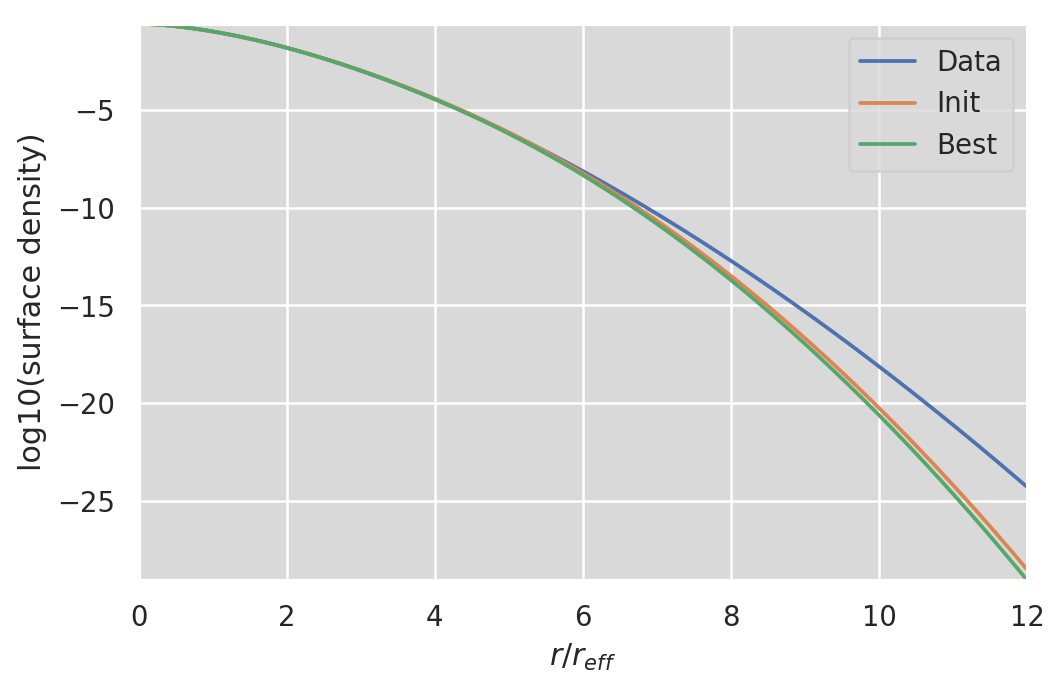

Init  chisq = -8.704602440324418
ws, re: (array([2.62812368e-01, 4.91320457e-01, 1.76263482e-01, 4.98746985e-02,
       1.62146527e-02, 3.05372015e-03, 4.23131353e-04, 3.74909725e-05]), array([1.25252719, 1.04027206, 0.81694834, 0.63834068, 0.46073084,
       0.29250349, 0.16634023, 0.07805292]))
         Current function value: -13.314514
         Iterations: 68
         Function evaluations: 2119
         Gradient evaluations: 124
-13.3145143851152 [-0.92503462  0.76017994  0.80060602  0.96055294  1.60326537  1.93526038
  2.46775205  0.09265747  0.01251231 -0.08953194 -0.1878924  -0.33373598
 -0.53527382 -0.78400709 -1.11535231]
n=0.6: (
    normalize(np.array([2.8393316813e-01, 4.8792278362e-01, 1.5744314284e-01, 5.1133192474e-02, 1.6289617552e-02, 2.8644997963e-03, 3.8127307631e-04, 3.2322507218e-05])),
    np.array([1.2378199346e+00, 1.0292297064e+00, 8.1370700944e-01, 6.4879515676e-01, 4.6372874806e-01, 2.9155881505e-01, 1.6443448874e-01, 7.6673924623e-02]),
),
Init  chisq = -8.6

         Current function value: -13.997654
         Iterations: 128
         Function evaluations: 3871
         Gradient evaluations: 227
-13.997653728033303 [-0.41982671  1.37865184  1.77611357  1.79943311 -3.34945534  2.23873814
 -2.52492168  0.05951307 -0.00816775 -0.12591887 -0.29080416 -0.65221898
 -0.49082896 -1.09857467 -0.75884684]
n=0.56: (
    normalize(np.array([3.9655821838e-01, 4.8201384245e-01, 1.0384715374e-01, 1.5085718848e-02, 2.1782638592e-03, 8.4615203855e-05, 2.1497558451e-04, 1.7211930637e-05])),
    np.array([1.1468670458e+00, 9.8136880184e-01, 7.4830927350e-01, 5.1191262993e-01, 3.2297658600e-01, 2.2273117852e-01, 1.7424212510e-01, 7.9693945263e-02]),
),
1.0000000154648756 1.0000000155580189
Init  chisq = -8.637113099620908
ws, re: (array([3.96558218e-01, 4.82013842e-01, 1.03847154e-01, 1.50857188e-02,
       8.46152039e-05, 2.17826386e-03, 1.72119306e-05, 2.14975585e-04]), array([1.14686705, 0.9813688 , 0.74830927, 0.51191263, 0.22273118,
       0.32297659, 0.

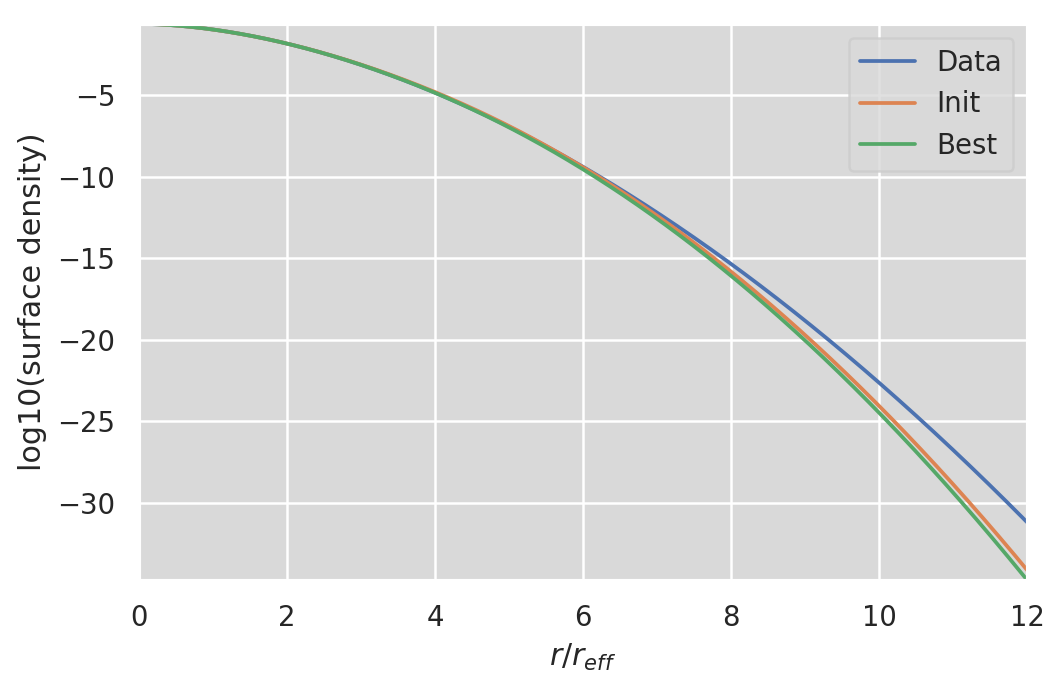

Init  chisq = -8.62940280686461
ws, re: (array([4.11969745e-01, 4.74849775e-01, 9.68162902e-02, 1.24316630e-02,
       1.80520226e-05, 1.67799624e-03, 2.26254081e-04, 2.01022437e-03]), array([1.1359447 , 0.97800421, 0.74897283, 0.52308456, 0.08447186,
       0.31288105, 0.180586  , 0.44528923]))
         Current function value: -14.078702
         Iterations: 61
         Function evaluations: 2035
         Gradient evaluations: 119
-14.078702313254603 [-0.35893284  1.37451379  1.6687159   0.73051983 -5.41876431 -0.35522989
 -2.33997386  0.05190344 -0.00783394 -0.11326747 -0.26421209 -1.0030933
 -0.45251339 -0.6926451  -0.25418597]
n=0.55: (
    normalize(np.array([4.1121792013e-01, 4.6991195001e-01, 1.0001786726e-01, 3.2717868717e-03, 1.2723756532e-02, 2.5145020013e-03, 3.1517174128e-04, 2.7045460025e-05])),
    np.array([1.1269468595e+00, 9.8212341020e-01, 7.7042883854e-01, 5.5694720876e-01, 5.4423680890e-01, 3.5276591319e-01, 2.0293403978e-01, 9.9290272210e-02]),
),
Init  chisq = -8.

         Current function value: -13.682105
         Iterations: 58
         Function evaluations: 2035
         Gradient evaluations: 119
-13.682104906917216 [-0.56033082  0.88334653  1.42234514 -0.93790762 -2.86201348 -5.59471499
 -4.01868516 -0.0072435   0.01782421 -0.00609208 -0.15659886 -0.35660381
 -0.66612952  0.05164681 -0.09077504]
n=0.51: (
    normalize(np.array([4.3264815660e-04, 4.5035401475e-01, 1.5000233020e-01, 3.6347091893e-01, 2.4067315231e-02, 1.0176229430e-02, 1.4054656989e-03, 9.1077601888e-05])),
    np.array([1.1262811428e+00, 1.0418956199e+00, 9.8607040420e-01, 9.8345954249e-01, 8.1138123326e-01, 6.9727025294e-01, 4.3994277657e-01, 2.1571009938e-01]),
),
1.0000000145287486 1.0000000146135983
Init  chisq = -8.555900959888467
ws, re: (array([3.63470919e-01, 4.50354015e-01, 1.50002330e-01, 1.01762294e-02,
       1.40546570e-03, 9.10776019e-05, 4.32648157e-04, 2.40673152e-02]), array([0.98345954, 1.04189562, 0.9860704 , 0.69727025, 0.43994278,
       0.2157101 , 1.1

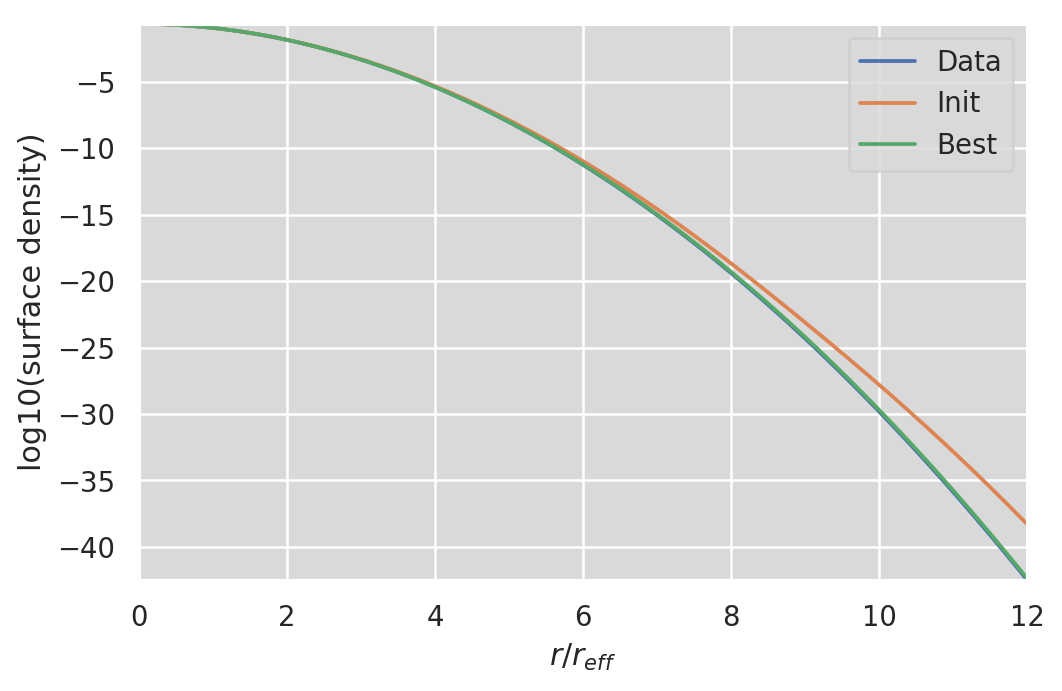

In [6]:
# Now try to work backwards in finely-spaced bins from n=1 with eight components and see where it breaks down
nspaced = np.linspace(1, 0.5, num=100, endpoint=False)
nvals = [
    (
        nspaced,
        (
	normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01, 6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
	np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
        ),
    )
]
fitweights(nvals, rmid, areasq, plotnth=10)

## Fitting weights with fixed, linearly-extrapolated sizes for n < 1

In the plots at the end of this notebook, it's clear that the best-fit *sizes* change nearly linearly from about n=1 to n=0.7. With appropriate choices for the slope of r vs n for each Gaussian, it's possible to fit smoothly-varying weights even for N=8.

[ 1.02610583  0.60634281  0.30585517  0.10200563 -0.0475183  -0.18168242
 -0.32424482 -0.50154897]
[ 1.11799858  0.60634281  0.30585517  0.10200563  0.         -0.18168242
 -0.32424482 -0.50154897]
1 [2.17045661 1.47679133 0.99494464 0.65054022 0.40699848 0.23877605
 0.12631553 0.05405815]
0.75 [1.57351098 1.20743015 0.89964332 0.6141669  0.40699848 0.25291729
 0.14172035 0.06424279]
0.5 [1.         0.9090717  0.78061774 0.56632816 0.40699848 0.27428166
 0.16667433 0.08193683]
0.9999999914677243 1.0000000283694637
Init  chisq = -10.92882749800659
ws, re: (array([0.07790019, 0.31264016, 0.33937179, 0.1839253 , 0.06541804,
       0.01709507, 0.00326612, 0.00038332]), array([2.17045661, 1.47679133, 0.99494464, 0.65054022, 0.40699848,
       0.23877605, 0.12631553, 0.05405815]))
Optimization terminated successfully.
         Current function value: -10.928828
         Iterations: 10
         Function evaluations: 144
         Gradient evaluations: 16
-10.92882763671094 [-2.47122091 -0.6675

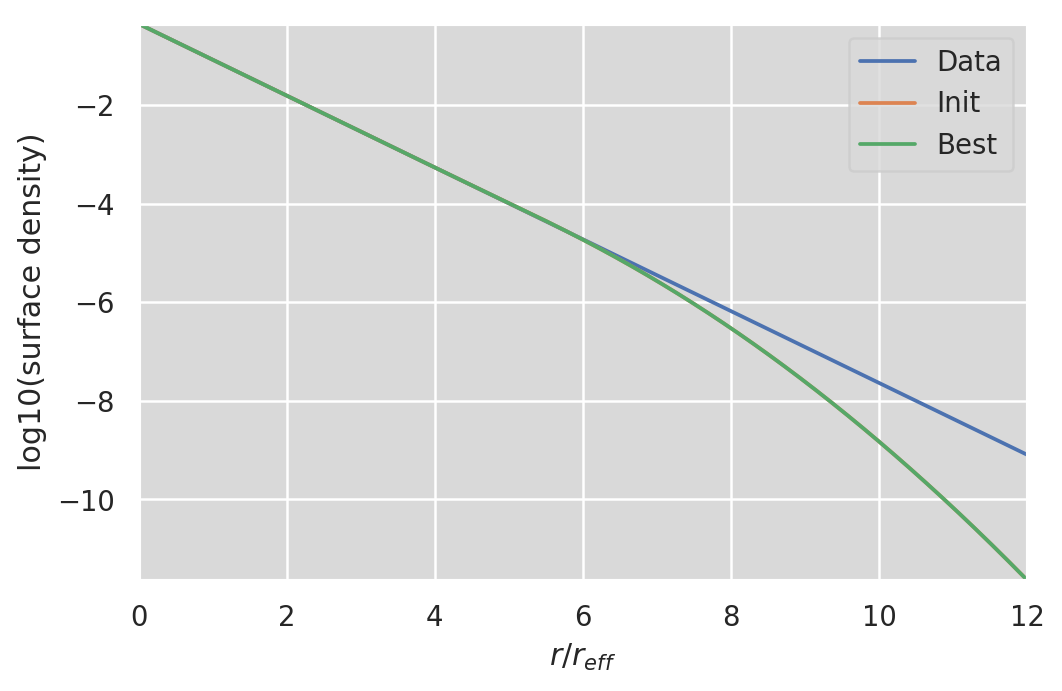

Init  chisq = -7.50778093682488
ws, re: (array([0.07790049, 0.31263986, 0.33937166, 0.18392552, 0.06541794,
       0.01709506, 0.00326616, 0.00038331]), array([2.10988257, 1.4508495 , 0.98616715, 0.6472545 , 0.40699848,
       0.23998818, 0.12760124, 0.0548856 ]))
         Current function value: -11.008447
         Iterations: 27
         Function evaluations: 1028
         Gradient evaluations: 113
-11.008446783209555 [-2.43075681 -0.63706594  0.26400012  0.79478856  1.16254076  1.56379083
  2.14681466]
n=0.975: (
    normalize(np.array([8.0857203429e-02, 3.1794076520e-01, 3.4005150474e-01, 1.7989578654e-01, 6.1899379840e-02, 1.6004882352e-02, 2.9999198800e-03, 3.5055801062e-04])),
    np.array([2.1098825713e+00, 1.4508494976e+00, 9.8616715342e-01, 6.4725449979e-01, 4.0699848261e-01, 2.3998817614e-01, 1.2760123754e-01, 5.4885596884e-02]),
),
Init  chisq = -7.46596606451809
ws, re: (array([0.0808572 , 0.31794077, 0.3400515 , 0.17989579, 0.06189938,
       0.01600488, 0.00299992, 0.000

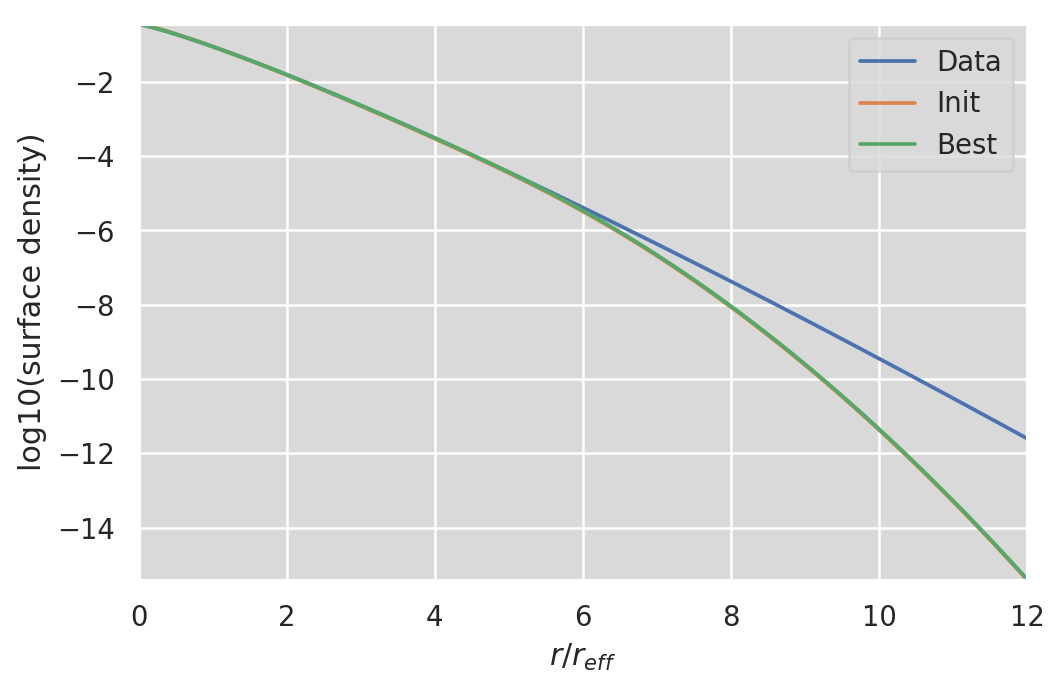

Init  chisq = -7.224662166013487
ws, re: (array([1.03265580e-01, 3.50568293e-01, 3.37271669e-01, 1.52992498e-01,
       4.31614268e-02, 1.07385401e-02, 1.79171994e-03, 2.10273310e-04]), array([1.75043804, 1.29073444, 0.9301603 , 0.62598647, 0.40699848,
       0.24814183, 0.13641909, 0.06067207]))
         Current function value: -10.812917
         Iterations: 24
         Function evaluations: 1180
         Gradient evaluations: 130
-10.812917210019089 [-2.08972676 -0.39356559  0.53150045  1.05613808  1.22755538  1.70757478
  2.13459003]
n=0.825: (
    normalize(np.array([1.1009934273e-01, 3.5850471394e-01, 3.3469070109e-01, 1.4594581545e-01, 3.9256854522e-02, 9.7371742451e-03, 1.5786541629e-03, 1.8674385878e-04])),
    np.array([1.7504380364e+00, 1.2907344353e+00, 9.3016030047e-01, 6.2598646774e-01, 4.0699848261e-01, 2.4814182879e-01, 1.3641909160e-01, 6.0672067129e-02]),
),
Init  chisq = -7.168516651363683
ws, re: (array([1.10099343e-01, 3.58504714e-01, 3.34690701e-01, 1.45945815e-01

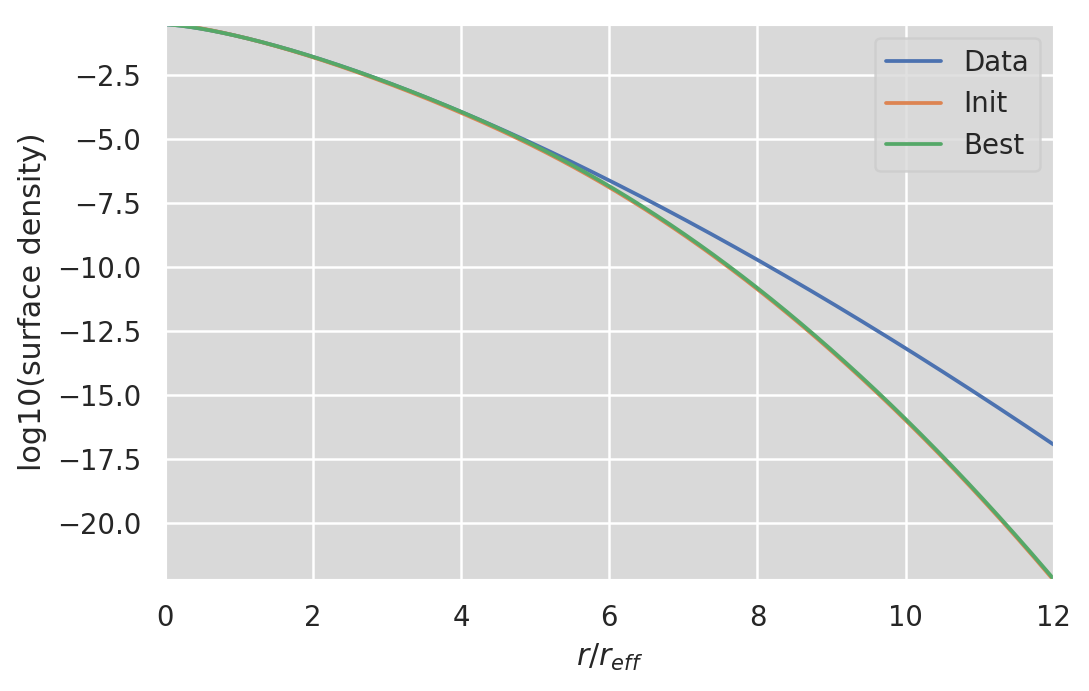

Init  chisq = -6.829754818808521
ws, re: (array([1.71265945e-01, 4.04046911e-01, 2.99098018e-01, 9.95838641e-02,
       2.01094946e-02, 5.11146898e-03, 6.94859783e-04, 8.94385697e-05]), array([1.39866262, 1.12158392, 0.86707215, 0.60136052, 0.40699848,
       0.25830334, 0.14782069, 0.0684351 ]))
Optimization terminated successfully.
         Current function value: -11.151753
         Iterations: 26
         Function evaluations: 414
         Gradient evaluations: 46
-11.151752648587197 [-1.4266364   0.04739449  0.9556834   1.40611126  1.21848853  1.90963908
  2.02868921]
n=0.675: (
    normalize(np.array([1.9362331316e-01, 4.1274100861e-01, 2.8430601328e-01, 8.7808324085e-02, 1.6610115988e-02, 4.2775717437e-03, 5.6000775566e-04, 7.3645380633e-05])),
    np.array([1.3986626227e+00, 1.1215839185e+00, 8.6707215232e-01, 6.0136051589e-01, 4.0699848261e-01, 2.5830333518e-01, 1.4782068946e-01, 6.8435098592e-02]),
),
Init  chisq = -6.746346824011424
ws, re: (array([1.93623313e-01, 4.12741009

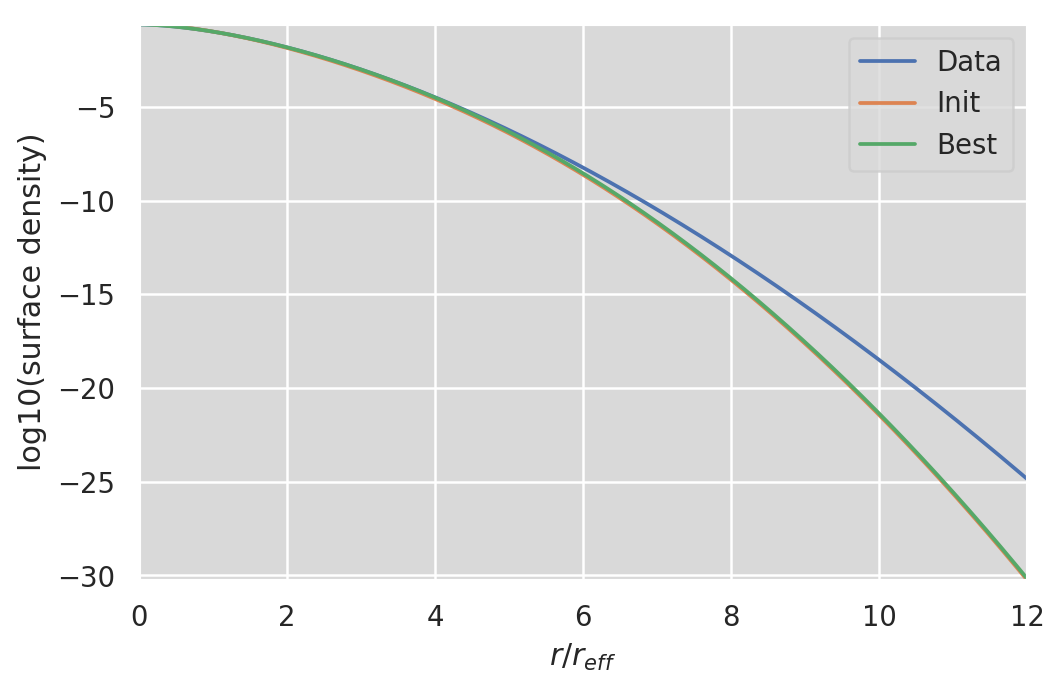

Init  chisq = -7.265314662967117
ws, re: (array([3.13723293e-01, 4.18388927e-01, 2.09942653e-01, 4.79911214e-02,
       7.66280744e-03, 2.00821324e-03, 2.50127088e-04, 3.28585160e-05]), array([1.20327248, 1.02074096, 0.82717447, 0.585389  , 0.40699848,
       0.26535078, 0.15599689, 0.07419078]))
         Current function value: -11.939089
         Iterations: 24
         Function evaluations: 882
         Gradient evaluations: 97
-11.939088844957453 [-0.66115399  0.5168265   1.34184435  1.58547392  1.21553107  1.94887991
  2.05103952]
n=0.59: (
    normalize(np.array([3.4048043140e-01, 4.1312661743e-01, 1.9533862662e-01, 4.2373984655e-02, 6.6949390946e-03, 1.7378698767e-03, 2.1932542340e-04, 2.8205501710e-05])),
    np.array([1.2032724773e+00, 1.0207409564e+00, 8.2717446997e-01, 5.8538900026e-01, 4.0699848261e-01, 2.6535077843e-01, 1.5599688562e-01, 7.4190782895e-02]),
),
Init  chisq = -7.218008815630325
ws, re: (array([3.40480431e-01, 4.13126617e-01, 1.95338627e-01, 4.23739847e-02,
 

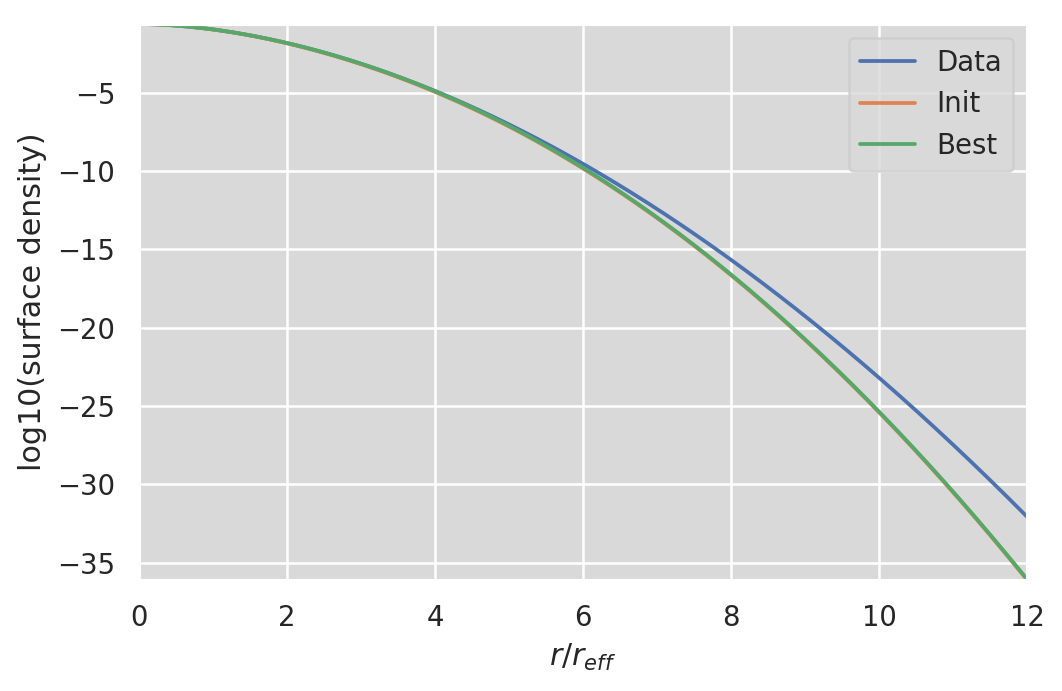

Init  chisq = -7.611958418443189
ws, re: (array([5.01861426e-01, 3.51311694e-01, 1.22063072e-01, 2.04692171e-02,
       3.39772467e-03, 7.69026053e-04, 1.15866686e-04, 1.19730599e-05]), array([1.10114059, 0.96559873, 0.80452157, 0.57617373, 0.40699848,
       0.26959477, 0.16102679, 0.07780782]))
         Current function value: -12.225509
         Iterations: 19
         Function evaluations: 1056
         Gradient evaluations: 116
-12.22550884515654 [0.12494242 0.92769481 1.6316444  1.54481913 1.36241237 1.75527174
 2.32050595]
n=0.545: (
    normalize(np.array([5.3119503339e-01, 3.3594909797e-01, 1.1111995514e-01, 1.7913961609e-02, 3.0428527023e-03, 6.6427281862e-04, 1.0455643613e-04, 1.0269938465e-05])),
    np.array([1.1011405919e+00, 9.6559872645e-01, 8.0452157205e-01, 5.7617373328e-01, 4.0699848261e-01, 2.6959477312e-01, 1.6102678861e-01, 7.7807822162e-02]),
),
Init  chisq = -7.581091347752085
ws, re: (array([5.31195033e-01, 3.35949098e-01, 1.11119955e-01, 1.79139616e-02,
      

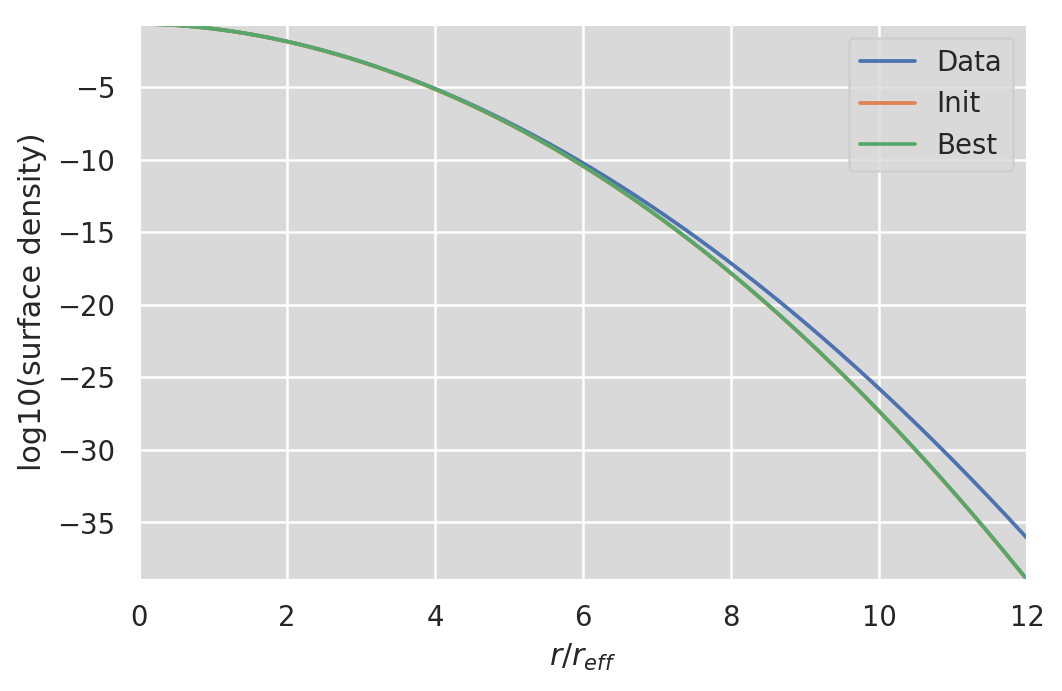

Init  chisq = -7.481665722747167
ws, re: (array([6.38755073e-01, 2.71989144e-01, 7.60330648e-02, 1.07371374e-02,
       2.02839227e-03, 3.80041364e-04, 7.14178866e-05, 5.72886946e-06]), array([1.05606247, 0.9406556 , 0.79406248, 0.57188146, 0.40699848,
       0.27161823, 0.16345304, 0.07957297]))
         Current function value: -12.462641
         Iterations: 20
         Function evaluations: 1065
         Gradient evaluations: 117
-12.462640665040627 [0.76659108 1.18473379 1.79144781 1.42265659 1.5475832  1.52255516
 2.61152303]
n=0.525: (
    normalize(np.array([6.8278301465e-01, 2.4292409615e-01, 6.3676783770e-02, 8.5539752337e-03, 1.7003591408e-03, 2.9698308173e-04, 6.0356445549e-05, 4.4315291824e-06])),
    np.array([1.0560624656e+00, 9.4065559947e-01, 7.9406247663e-01, 5.7188145825e-01, 4.0699848261e-01, 2.7161822553e-01, 1.6345304341e-01, 7.9572971987e-02]),
),
1.000000014799145 1.0000000151457247
Init  chisq = -7.445916721893174
ws, re: (array([6.82783015e-01, 2.42924096e-01, 

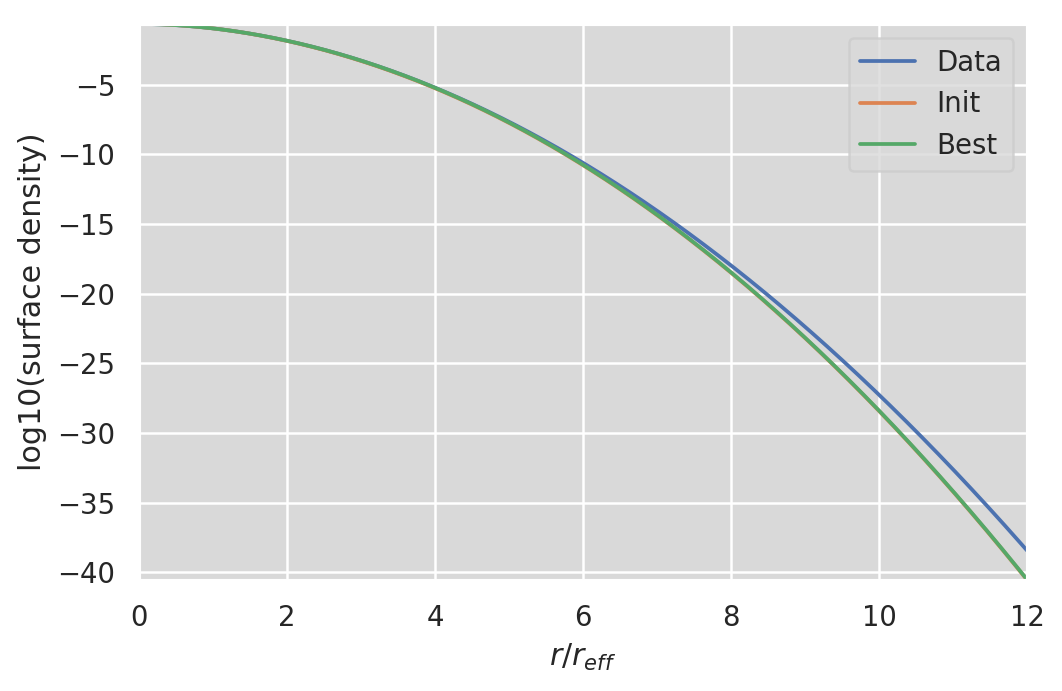

Init  chisq = -8.20980101105586
ws, re: (array([7.31969192e-01, 2.08814072e-01, 5.10685745e-02, 6.50181061e-03,
       1.37323057e-03, 2.20728731e-04, 4.91389941e-05, 3.25234621e-06]), array([1.04033255, 0.93185849, 0.79034068, 0.57034824, 0.40699848,
       0.27234839, 0.16433302, 0.08021643]))
         Current function value: -12.649720
         Iterations: 22
         Function evaluations: 1055
         Gradient evaluations: 116
-12.649719831590726 [1.11612984 1.29200457 1.85345081 1.3511648  1.64495227 1.40073138
 2.76008758]
n=0.518: (
    normalize(np.array([7.5327013658e-01, 1.9355619523e-01, 4.5970324903e-02, 5.7217595931e-03, 1.2418748103e-03, 1.9231841549e-04, 4.4569809178e-05, 2.8206549857e-06])),
    np.array([1.0403325471e+00, 9.3185848607e-01, 7.9034067523e-01, 5.7034824193e-01, 4.0699848261e-01, 2.7234839259e-01, 1.6433301709e-01, 8.0216425408e-02]),
),
Init  chisq = -8.194461717783273
ws, re: (array([7.53270137e-01, 1.93556195e-01, 4.59703249e-02, 5.72175959e-03,
      

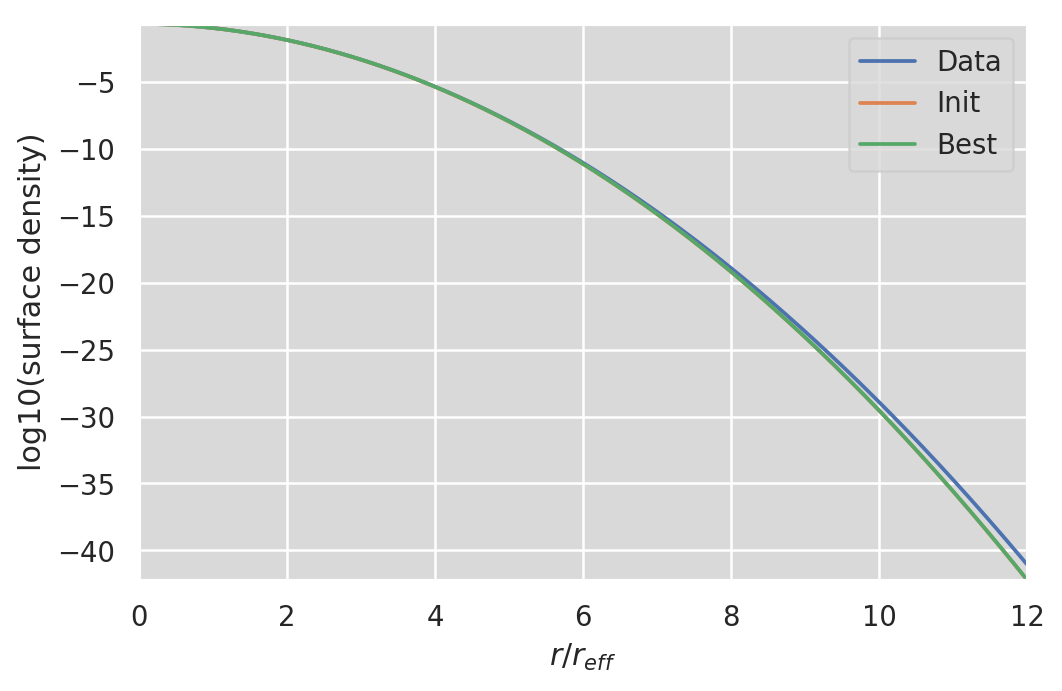

Init  chisq = -8.734062561841988
ws, re: (array([8.49344696e-01, 1.21547901e-01, 2.54143624e-02, 2.86636459e-03,
       7.07906653e-04, 9.17660848e-05, 2.56897555e-05, 1.31280852e-06]), array([1.02014524, 0.92049531, 0.78550715, 0.56835242, 0.40699848,
       0.27330477, 0.16548919, 0.08106446]))
         Current function value: -13.126773
         Iterations: 26
         Function evaluations: 1791
         Gradient evaluations: 197
-13.12677328266745 [1.83814428 1.44775809 1.93868674 1.22749941 1.80538672 1.19716985
 3.00540426]
n=0.509: (
    normalize(np.array([8.6272908630e-01, 1.1114182942e-01, 2.2842249206e-02, 2.5419745249e-03, 6.3968876885e-04, 8.0774130388e-05, 2.3246514064e-05, 1.1511378976e-06])),
    np.array([1.0201452361e+00, 9.2049531053e-01, 7.8550714830e-01, 5.6835241762e-01, 4.0699848261e-01, 2.7330477022e-01, 1.6548918599e-01, 8.1064459535e-02]),
),
Init  chisq = -8.725693009703239
ws, re: (array([8.62729086e-01, 1.11141829e-01, 2.28422492e-02, 2.54197452e-03,
      

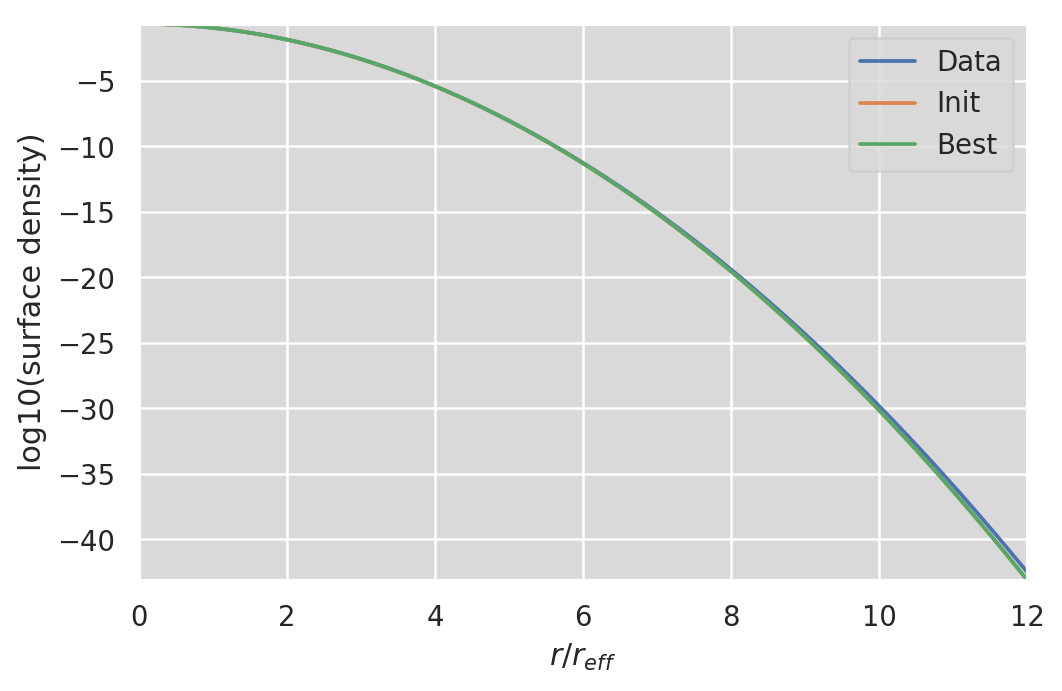

Init  chisq = -8.691366693699027
ws, re: (array([9.19786638e-01, 6.58750092e-02, 1.25968897e-02, 1.32529559e-03,
       3.61627793e-04, 4.07771714e-05, 1.31840221e-05, 5.78449867e-07]), array([1.0089482 , 0.91415641, 0.78279782, 0.5672314 , 0.40699848,
       0.2738449 , 0.16614394, 0.08154603]))
         Current function value: -13.762795
         Iterations: 25
         Function evaluations: 1649
         Gradient evaluations: 181
-13.762794519693669 [2.66604912 1.54491512 1.989114   1.13887611 1.91653772 1.05225908
 3.18351902]
n=0.504: (
    normalize(np.array([9.3499330605e-01, 5.3577093716e-02, 1.0054040662e-02, 1.0419495572e-03, 2.9082514962e-04, 3.1712507187e-05, 1.0631785117e-05, 4.4057661952e-07])),
    np.array([1.0089482026e+00, 9.1415640864e-01, 7.8279781637e-01, 5.6723139821e-01, 4.0699848261e-01, 2.7384490244e-01, 1.6614394491e-01, 8.1546033092e-02]),
),
Init  chisq = -8.682564022034384
ws, re: (array([9.34993306e-01, 5.35770937e-02, 1.00540407e-02, 1.04194956e-03,
     

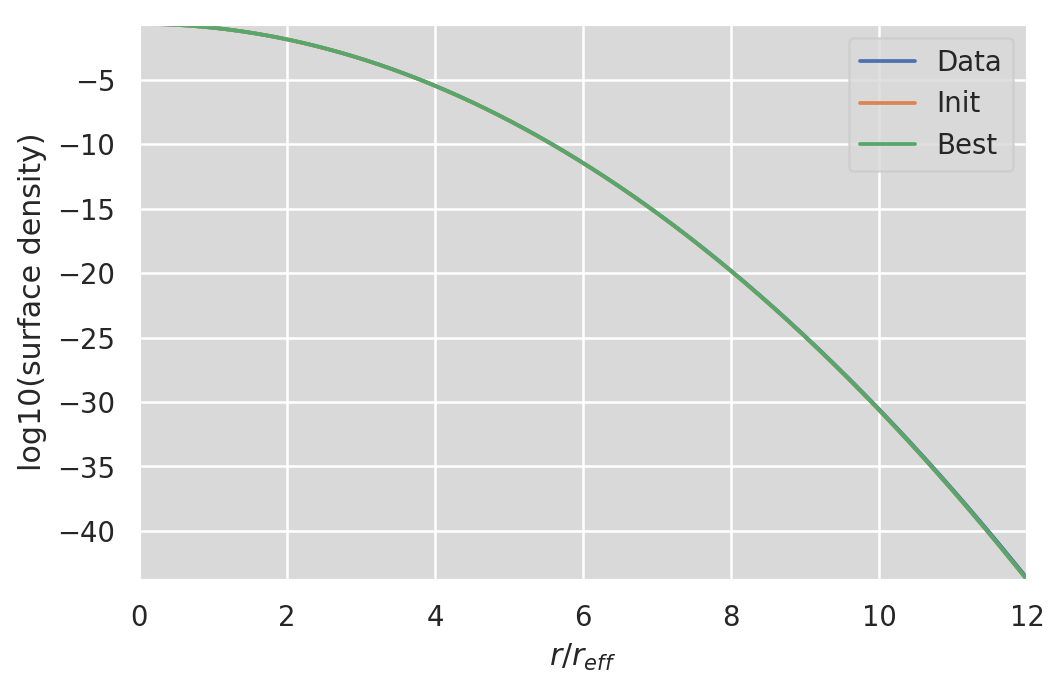

Init  chisq = -8.655592621527944
ws, re: (array([9.83090811e-01, 1.40870092e-02, 2.49164062e-03, 2.46680237e-04,
       7.37458995e-05, 7.32330759e-06, 2.68288872e-06, 1.07192278e-07]), array([1.        , 0.9090717 , 0.78061774, 0.56632816, 0.40699848,
       0.27428166, 0.16667433, 0.08193683]))
Optimization terminated successfully.
         Current function value: -20.617227
         Iterations: 3
         Function evaluations: 81
         Gradient evaluations: 9
-20.617227474775095 [21.99479348  5.50479353  2.79756248  1.13800524  1.9774401   0.96115125
  3.21977231]
n=0.5: (
    normalize(np.array([9.9999999972e-01, 2.7926719072e-10, 1.0705823480e-12, 4.9423063822e-14, 1.3912223774e-14, 1.3930126655e-15, 5.1228779701e-16, 1.1102230246e-16])),
    np.array([1.0000000023e+00, 9.0907169503e-01, 7.8061774471e-01, 5.6632815891e-01, 4.0699848261e-01, 2.7428165889e-01, 1.6667433497e-01, 8.1936830104e-02]),
),


In [7]:
# Let's try one more approach. From n=0.7 to n=1, log(n) vs log(rdivre) for the sigmaspline is nearly linear, so just fix those and only fit the weights
x100 = np.log10(np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01,
                          4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02]))
x70 = np.log10(np.array([1.5052384522e+00, 1.1895849021e+00, 8.9211604870e-01, 6.2729710480e-01,
                         4.1395531956e-01, 2.5476146085e-01, 1.4180217436e-01, 6.4647551382e-02]))
w70 =     normalize(np.array([1.1646435020e-01, 4.2739124945e-01, 3.1922751878e-01, 1.0653680383e-01,
                              2.4816881868e-02, 4.7669777519e-03, 7.2686739303e-04, 6.9350722705e-05])),
slopes = (x100-x70)/-np.log10(0.7)
print(slopes)
# That did not actually work well below n<0.7, which was the whole point, so let's try again
x50 = np.array([0])
slopes[:len(x50)] = (x100[:len(x50)]-x50)/-np.log10(0.5/1.0)
slopes[4] = 0
print(slopes)

class RadiusExtrapolator:
    # Straight n=0.7 slopes
    # delta = np.array([1.11799858, 0.89465879, 0.49097738,  0.21019219, 0.19796296, -0.07311309, -0.49345005, -0.88741601])
    # Adjusted slopes
    # delta = np.array([1.21540882, 1.20028606, 0.68721482, 0.66704026, 0.45818359, 0.19252795, -0.67281483, -1.29645156])
    delta = np.array([1.11799858, 0.7, 0.35, 0.2, 0., -0.2, -0.4, -0.6])
    #xref = np.log10(np.array([1.5052384522e+00, 1.1895849021e+00, 8.9211604870e-01, 6.2729710480e-01, 4.1395531956e-01, 2.5476146085e-01, 1.4180217436e-01, 6.4647551382e-02]))
    xref = np.log10(np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02]))
    nref = 1.0
    @staticmethod
    def r(nsersic):
        return(RadiusExtrapolator.xref + RadiusExtrapolator.delta*np.log10(nsersic/RadiusExtrapolator.nref))

for n in [1, 0.75, 0.5]:
    print(n, 10**RadiusExtrapolator.r(n))

nvals = [
    (
        np.array([
            1.0, 0.975, 0.95, 0.925, 0.9, 0.875, 0.85, 0.825, 0.8,
            0.775, 0.75, 0.725, 0.7, 0.675, 0.65, 0.625, 0.6, 0.59,
            0.58, 0.57, 0.56, 0.55, 0.545, 0.54, 0.535, 0.53, 0.525,
            0.52, 0.518, 0.516, 0.514, 0.512, 0.51, 0.509, 0.508,
            0.507, 0.506, 0.505, 0.504, 0.503, 0.502, 0.501, 0.5
        ]),
        (
	normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01, 6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
	np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
        ),
    )
]
fitweights(nvals, rmid, areasq, funcrdivreslog=RadiusExtrapolator.r, plotnth=np.Inf, plotvals=[1., 0.85, 0.7, 0.6, 0.55, 0.53, 0.52, 0.51, 0.505, 0.501])

## Fitting large n profiles

Up to n=2.5, we continue from the exponential solution. Beyond n=2.5, it becomes very difficult to fit the outer profile because more of the Gaussian components trend to tiny sizes. By masking the inner bins, we can limit this issue and ensure a nearly constant central surface brightness. In the real universe, most massive nearby ellipticals don't have the steep cusp of an n>4 profile - only the outer part is well-approximated by an n>4 profile. Kormendy & co. discuss this at length in a number of papers, hypothesizing that the shallow inner cores are due to massive black holes scattering stars and scouring the inner regions of stars. It could be possible that higher-redshift ellipticals and/or recent merger remnants do have very cuspy centers, but these are probably merger-induced and distinct enough from the rest of the galaxy that they should be considered a separate component.

[0, 24000]
0.9999999914677243 1.0000000283694637
Init  chisq = -10.928842290897967
ws, re: (array([0.07790019, 0.31264016, 0.33937179, 0.1839253 , 0.06541804,
       0.01709507, 0.00326612, 0.00038332]), array([2.17045661, 1.47679133, 0.99494464, 0.65054022, 0.40699848,
       0.23877605, 0.12631553, 0.05405815]))
         Current function value: -10.928845
         Iterations: 11
         Function evaluations: 1440
         Gradient evaluations: 84
-10.928845491478475 [-2.47097404e+00 -6.67480465e-01  2.28191308e-01  7.58177529e-01
  1.14859079e+00  1.54422359e+00  2.14252636e+00  3.36537132e-01
  1.69306081e-01 -2.20183867e-03 -1.86709012e-01 -3.90388717e-01
 -6.21999543e-01 -8.98532521e-01 -1.26716408e+00]
0.9999999914677243 1.0000000283697712
n=1.0: (
    normalize(np.array([7.7918224454e-02, 3.1264218663e-01, 3.3933691570e-01, 1.8392855585e-01, 6.5427993720e-02, 1.7096421442e-02, 3.2663678777e-03, 3.8333433416e-04])),
    np.array([2.1703867615e+00, 1.4767469440e+00, 9.9494290945e

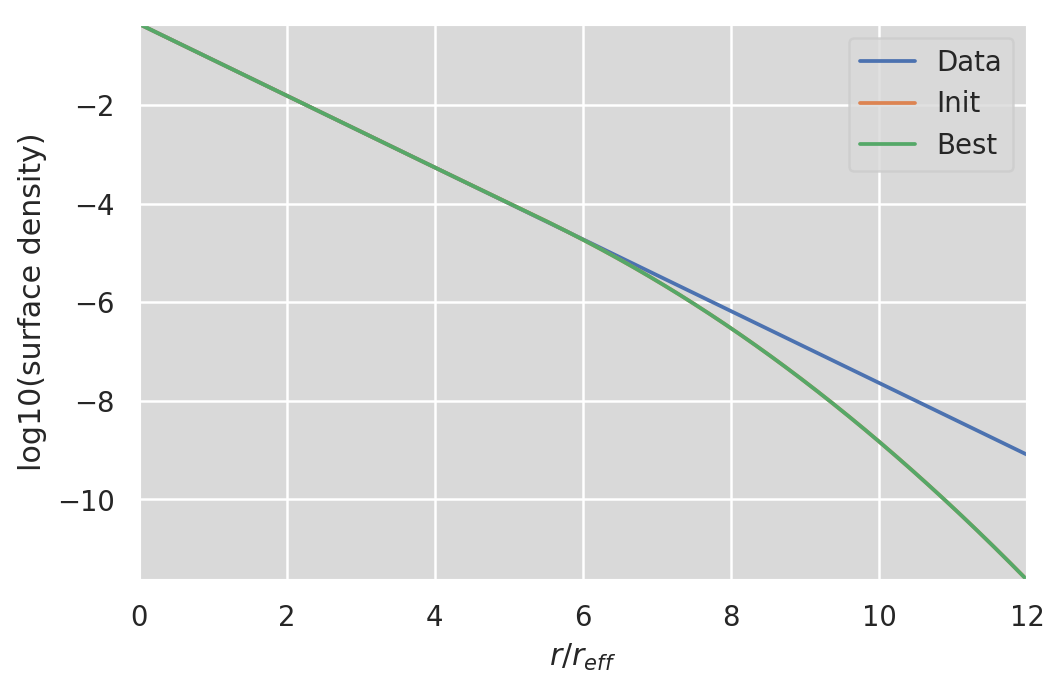

[0, 24000]
Init  chisq = -7.751041409870326
ws, re: (array([0.07791822, 0.31264219, 0.33933692, 0.18392856, 0.06542799,
       0.01709642, 0.00326637, 0.00038333]), array([2.17038676, 1.47674694, 0.99494291, 0.65056544, 0.40701581,
       0.23878138, 0.12631865, 0.05405501]))
         Current function value: -10.823923
         Iterations: 51
         Function evaluations: 2273
         Gradient evaluations: 133
-10.823922863790685 [-2.48448711e+00 -6.95157227e-01  1.96637621e-01  7.29817123e-01
  1.12601037e+00  1.52700568e+00  2.12852120e+00  3.47251861e-01
  1.75727228e-01  1.17515822e-03 -1.85621494e-01 -3.91173004e-01
 -6.24475872e-01 -9.02739798e-01 -1.27335021e+00]
n=1.025: (
    normalize(np.array([7.6952872212e-02, 3.0727021030e-01, 3.3806252163e-01, 1.8739199324e-01, 6.8202615579e-02, 1.8172904487e-02, 3.5271100413e-03, 4.1977251196e-04])),
    np.array([2.2245996320e+00, 1.4987432070e+00, 1.0027095661e+00, 6.5219656293e-01, 4.0628145229e-01, 2.3742373239e-01, 1.2510083328e-0

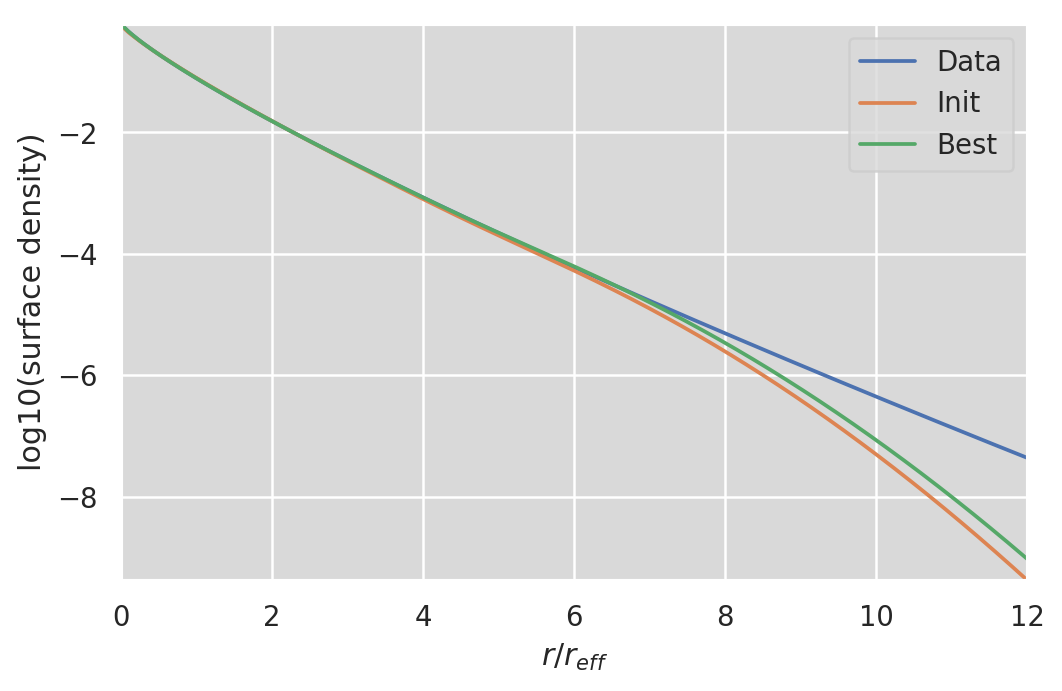

[1, 24000]
Init  chisq = -7.898892993909739
ws, re: (array([0.07304994, 0.27922744, 0.32777389, 0.2042455 , 0.08437587,
       0.02521904, 0.00540314, 0.00070517]), array([2.60181444, 1.64523995, 1.05173256, 0.66033266, 0.3994122 ,
       0.22729073, 0.11665862, 0.04824479]))
         Current function value: -10.136294
         Iterations: 39
         Function evaluations: 2460
         Gradient evaluations: 144
-10.136294262614923 [-2.54254803 -0.85633034  0.00500144  0.54949304  0.97431484  1.40411112
  2.0244051   0.42396293  0.22128913  0.0243583  -0.179851   -0.39995296
 -0.64639198 -0.93762984 -1.32283687]
n=1.225: (
    normalize(np.array([7.2928712957e-02, 2.7636608139e-01, 3.2616621671e-01, 2.0576354900e-01, 8.6228439698e-02, 2.6129885634e-02, 5.6684666689e-03, 7.4864793937e-04])),
    np.array([2.6543790115e+00, 1.6645204355e+00, 1.0576897704e+00, 6.6092015366e-01, 3.9815029687e-01, 2.2573973776e-01, 1.1544367838e-01, 4.7551380379e-02]),
),
[1, 24000]
Init  chisq = -7.9150689

         Current function value: -9.545536
         Iterations: 29
         Function evaluations: 1933
         Gradient evaluations: 113
-9.54553597624725 [-2.51415011 -0.95288164 -0.1343605   0.40548972  0.84237659  1.28865912
  1.92171459  0.49728835  0.26271902  0.04275241 -0.18006919 -0.41627436
 -0.67748377 -0.98318758 -1.38408479]
n=1.467: (
    normalize(np.array([7.4872139384e-02, 2.5746832915e-01, 3.1143667726e-01, 2.1373581700e-01, 9.9593525641e-02, 3.3625087816e-02, 8.0851195594e-03, 1.1833041896e-03])),
    np.array([3.1425944921e+00, 1.8311293230e+00, 1.1034493765e+00, 6.6058819749e-01, 3.8346492249e-01, 2.1014363221e-01, 1.0394711086e-01, 4.1296687153e-02]),
),
[4, 24000]
0.9999074016233933 0.9999969985448085
Init  chisq = -7.813860016740509
ws, re: (array([0.07487214, 0.25746833, 0.31143668, 0.21373582, 0.09959353,
       0.03362509, 0.00808512, 0.0011833 ]), array([3.14259449, 1.83112932, 1.10344938, 0.6605882 , 0.38346492,
       0.21014363, 0.10394711, 0.04129669]))


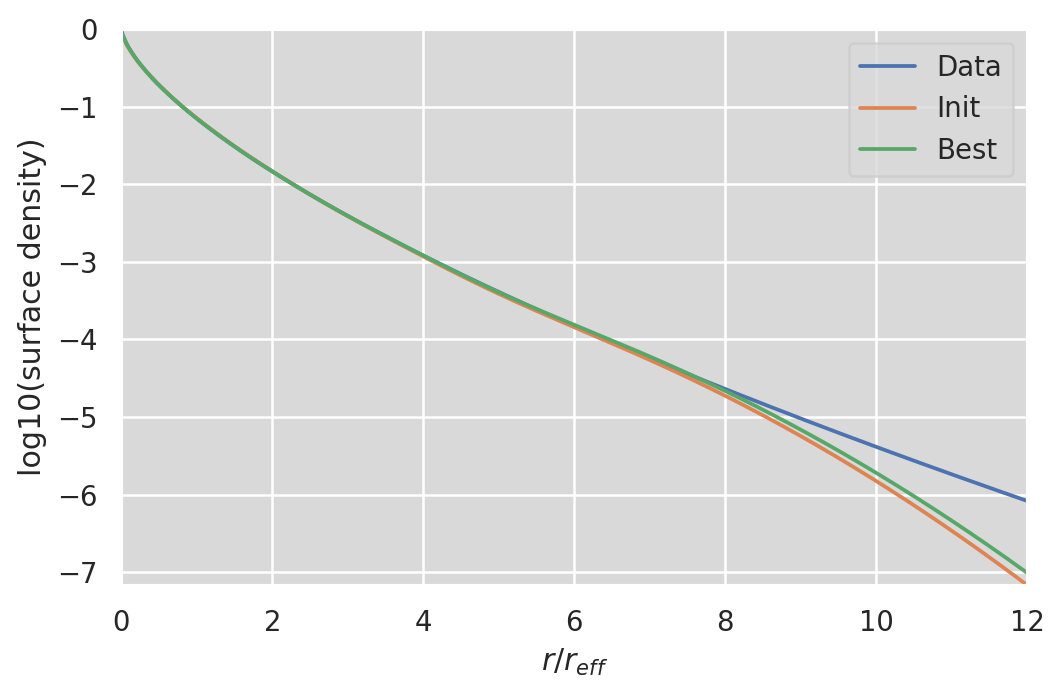

[5, 24000]
Init  chisq = -7.478903696385744
ws, re: (array([0.07547132, 0.25579952, 0.30959878, 0.21414986, 0.10088375,
       0.03446706, 0.00838693, 0.00124277]), array([3.20572861, 1.85102106, 1.1081043 , 0.65978932, 0.38118314,
       0.20797594, 0.10243304, 0.04050775]))
         Current function value: -9.384169
         Iterations: 32
         Function evaluations: 1865
         Gradient evaluations: 109
-9.38416939868937 [-2.49084469 -0.97164523 -0.1681368   0.36805557  0.80620221  1.25541564
  1.89096301  0.51843804  0.27412878  0.04708875 -0.18155639 -0.42288622
 -0.6888391  -0.99917643 -1.40498057]
n=1.55: (
    normalize(np.array([7.6502498479e-02, 2.5354872765e-01, 3.0687978075e-01, 2.1456980051e-01, 1.0265743656e-01, 3.5675701527e-02, 8.8329319439e-03, 1.3331225834e-03])),
    np.array([3.2994233123e+00, 1.8798741630e+00, 1.1145222762e+00, 6.5832994552e-01, 3.7767111973e-01, 2.0472029597e-01, 1.0018981396e-01, 3.9356768492e-02]),
),
[6, 24000]
Init  chisq = -7.50274105173

         Current function value: -8.835670
         Iterations: 33
         Function evaluations: 2187
         Gradient evaluations: 128
-8.835670438038889 [-2.33756215 -1.01321473 -0.28162257  0.2295433   0.66180423  1.11083786
  1.7414705   0.59791623  0.31428085  0.05858405 -0.19386756 -0.45613935
 -0.74109356 -1.06882349 -1.48879474]
n=1.95: (
    normalize(np.array([8.8059490056e-02, 2.4289644458e-01, 2.8772643188e-01, 2.1244546632e-01, 1.1139915392e-01, 4.3236101897e-02, 1.2113814150e-02, 2.1230971980e-03])),
    np.array([3.9620160875e+00, 2.0619629285e+00, 1.1444163438e+00, 6.3992994883e-01, 3.4983289641e-01, 1.8151245748e-01, 8.5344690276e-02, 3.2449294525e-02]),
),
[16, 24000]
0.998691724858366 0.9998475828372719
Init  chisq = -7.651325096914837
ws, re: (array([0.08805949, 0.24289644, 0.28772643, 0.21244547, 0.11139915,
       0.0432361 , 0.01211381, 0.0021231 ]), array([3.96201609, 2.06196293, 1.14441634, 0.63992995, 0.3498329 ,
       0.18151246, 0.08534469, 0.03244929]))


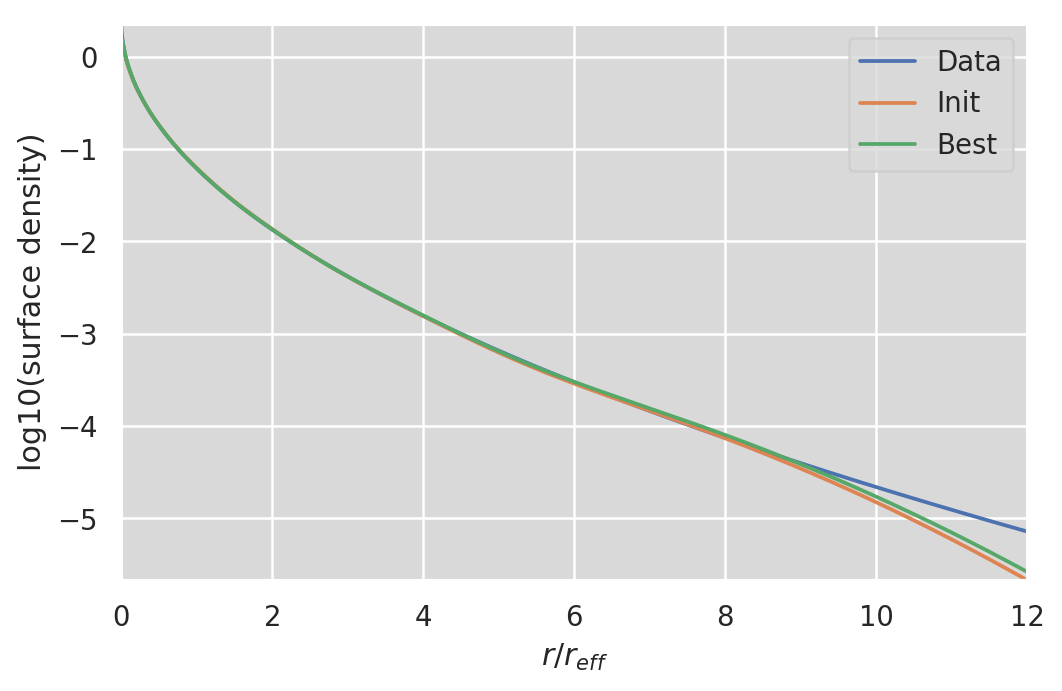

[18, 24000]
Init  chisq = -7.66641554294581
ws, re: (array([0.08978655, 0.24210087, 0.28558287, 0.2117723 , 0.11202987,
       0.04399071, 0.01250264, 0.0022342 ]), array([4.03333536, 2.07920604, 1.146022  , 0.63713774, 0.34655749,
       0.17902175, 0.08386894, 0.03184098]))
         Current function value: -8.748569
         Iterations: 29
         Function evaluations: 2086
         Gradient evaluations: 122
-8.748568758882248 [-2.297731   -1.0191851  -0.30493691  0.19880838  0.62719529  1.07265661
  1.69682075  0.61334571  0.3217635   0.06033473 -0.1968365  -0.46312833
 -0.75143777 -1.08155822 -1.50112835]
n=2.05: (
    normalize(np.array([9.1311053153e-02, 2.4097173563e-01, 2.8334650653e-01, 2.1122670585e-01, 1.1286447502e-01, 4.4914381823e-02, 1.2985374205e-02, 2.3797677884e-03])),
    np.array([4.1053076191e+00, 2.0977972032e+00, 1.1490388919e+00, 6.3557015970e-01, 3.4424819592e-01, 1.7724019997e-01, 8.2878481238e-02, 3.1540723588e-02]),
),
[19, 24000]
Init  chisq = -7.678947010

         Current function value: -8.553898
         Iterations: 24
         Function evaluations: 1763
         Gradient evaluations: 103
-8.55389796337675 [-2.16417739 -1.05466801 -0.4055215   0.06647451  0.47284379  0.89350455
  1.47787368  0.66471931  0.34841971  0.06986072 -0.20081963 -0.47752234
 -0.77244695 -1.10258457 -1.50349833]
n=2.45: (
    normalize(np.array([1.0301381181e-01, 2.3171819387e-01, 2.6609819340e-01, 2.0621611304e-01, 1.1887039716e-01, 5.2570455687e-02, 1.7516851707e-02, 3.9959833419e-03])),
    np.array([4.6208227573e+00, 2.2305897891e+00, 1.1745208099e+00, 6.2976767881e-01, 3.3302563275e-01, 1.6887021095e-01, 7.8961506797e-02, 3.1369071976e-02]),
),
[35, 24000]
0.9950931358505836 0.9990391601264504
Init  chisq = -7.77896993073643
ws, re: (array([0.10301381, 0.23171819, 0.26609819, 0.20621611, 0.1188704 ,
       0.05257046, 0.01751685, 0.00399598]), array([4.62082276, 2.23058979, 1.17452081, 0.62976768, 0.33302563,
       0.16887021, 0.07896151, 0.03136907]))
 

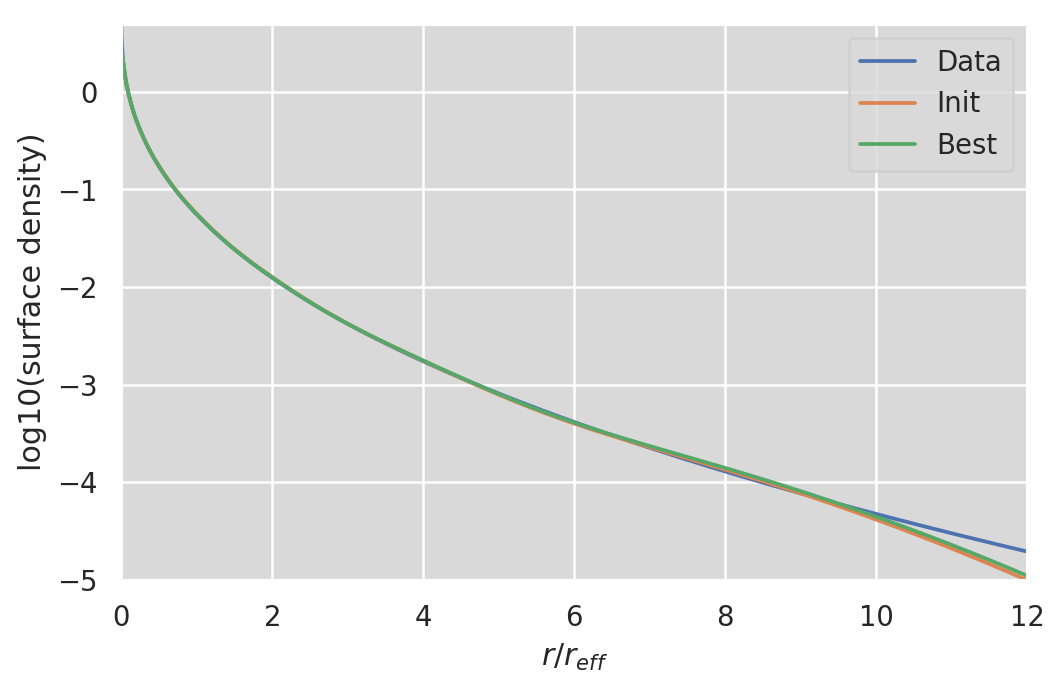

[37, 24000]
Init  chisq = -7.790791215863488
ws, re: (array([0.10434668, 0.23046411, 0.26400142, 0.20555926, 0.11958933,
       0.0535882 , 0.01818345, 0.00426754]), array([4.67911345, 2.24611917, 1.17833977, 0.63006658, 0.33256311,
       0.16852945, 0.07892723, 0.03158843]))
         Current function value: -8.530579
         Iterations: 25
         Function evaluations: 1286
         Gradient evaluations: 75
-8.530579360296889 [-2.13585269 -1.06532519 -0.43136061  0.03264486  0.43287664  0.84661746
  1.42144485  0.67541259  0.35436493  0.07269217 -0.20031447 -0.47855996
 -0.7739549  -1.10263975 -1.49710271]
n=2.55: (
    normalize(np.array([1.0566065506e-01, 2.2921302115e-01, 2.6192772847e-01, 2.0488959617e-01, 1.2028638048e-01, 5.4604683332e-02, 1.8864664948e-02, 4.5532703911e-03])),
    np.array([4.7360097467e+00, 2.2613351170e+00, 1.1822033202e+00, 6.3050063632e-01, 3.3223091618e-01, 1.6828488073e-01, 7.8951474830e-02, 3.1834445606e-02]),
),
[40, 24000]
Init  chisq = -7.806777227

         Current function value: -8.527657
         Iterations: 23
         Function evaluations: 1575
         Gradient evaluations: 92
-8.527656882336524 [-2.04799265 -1.1218012  -0.54436262 -0.1113707   0.26414735  0.65133641
  1.19568933  0.71336935  0.37840919  0.08863714 -0.1896879  -0.47010192
 -0.76306662 -1.08115204 -1.44592062]
n=2.95: (
    normalize(np.array([1.1425537007e-01, 2.1760737734e-01, 2.4532216669e-01, 1.9964739261e-01, 1.2623603905e-01, 6.3714296513e-02, 2.5502860651e-02, 7.7144970706e-03])),
    np.array([5.1685574335e+00, 2.3900621016e+00, 1.2264141079e+00, 6.4611838282e-01, 3.3876464329e-01, 1.7255731761e-01, 8.2956029531e-02, 3.5816189767e-02]),
),
[60, 24000]
0.989136215414153 0.997276273279563
Init  chisq = -7.9213177077077255
ws, re: (array([0.11425537, 0.21760738, 0.24532217, 0.19964739, 0.12623604,
       0.0637143 , 0.02550286, 0.0077145 ]), array([5.16855743, 2.3900621 , 1.22641411, 0.64611838, 0.33876464,
       0.17255732, 0.08295603, 0.03581619]))
O

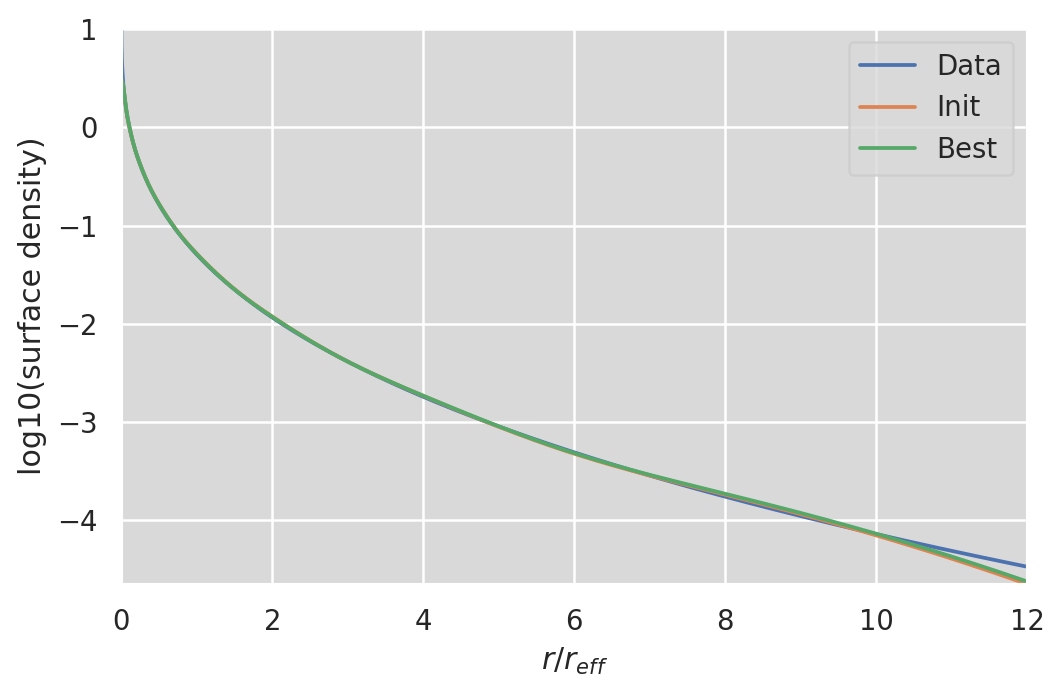

[63, 24000]
Init  chisq = -7.938583835387494
ws, re: (array([0.11512005, 0.21602259, 0.24325646, 0.19897829, 0.12698319,
       0.06494095, 0.02647061, 0.00822787]), array([5.22027446, 2.40709107, 1.23351362, 0.64945365, 0.3406001 ,
       0.17376728, 0.08386363, 0.03652747]))
         Current function value: -8.544913
         Iterations: 24
         Function evaluations: 1440
         Gradient evaluations: 84
-8.544912650347673 [-2.03110044 -1.13844765 -0.57417758 -0.14850713  0.22124574  0.60280899
  1.14224424  0.72188814  0.38450949  0.09363498 -0.18519332 -0.46535992
 -0.75694021 -1.07167353 -1.42896856]
n=3.05: (
    normalize(np.array([1.1597605077e-01, 2.1446906204e-01, 2.4122283646e-01, 1.9829259656e-01, 1.2769189001e-01, 6.6147097255e-02, 2.7443264283e-02, 8.7572026236e-03])),
    np.array([5.2709408302e+00, 2.4238709552e+00, 1.2406091474e+00, 6.5283988827e-01, 3.4248383479e-01, 1.7500876132e-01, 8.4786452941e-02, 3.7241866593e-02]),
),
[66, 24000]
Init  chisq = -7.956178041

         Current function value: -8.625535
         Iterations: 22
         Function evaluations: 1558
         Gradient evaluations: 91
-8.62553524675657 [-1.96695066 -1.19735026 -0.68142429 -0.28203722  0.06850441  0.43408097
  0.96451645  0.75105966  0.40584573  0.11196864 -0.16791681 -0.4466339
 -0.73296209 -1.03610436 -1.36968146]
n=3.45: (
    normalize(np.array([1.2271679306e-01, 2.0348314226e-01, 2.2635874485e-01, 1.9237936250e-01, 1.3189748865e-01, 7.4742079878e-02, 3.5059027862e-02, 1.3363360946e-02])),
    np.array([5.6371509443e+00, 2.5459257132e+00, 1.2941024011e+00, 6.7933374757e-01, 3.5757414131e-01, 1.8494300582e-01, 9.2022842495e-02, 4.2689251017e-02]),
),
[89, 24000]
0.9814905865621665 0.9946939880178524
Init  chisq = -8.102946132876424
ws, re: (array([0.12271679, 0.20348314, 0.22635874, 0.19237936, 0.13189749,
       0.07474208, 0.03505903, 0.01336336]), array([5.63715094, 2.54592571, 1.2941024 , 0.67933375, 0.35757414,
       0.18494301, 0.09202284, 0.04268925]))
  

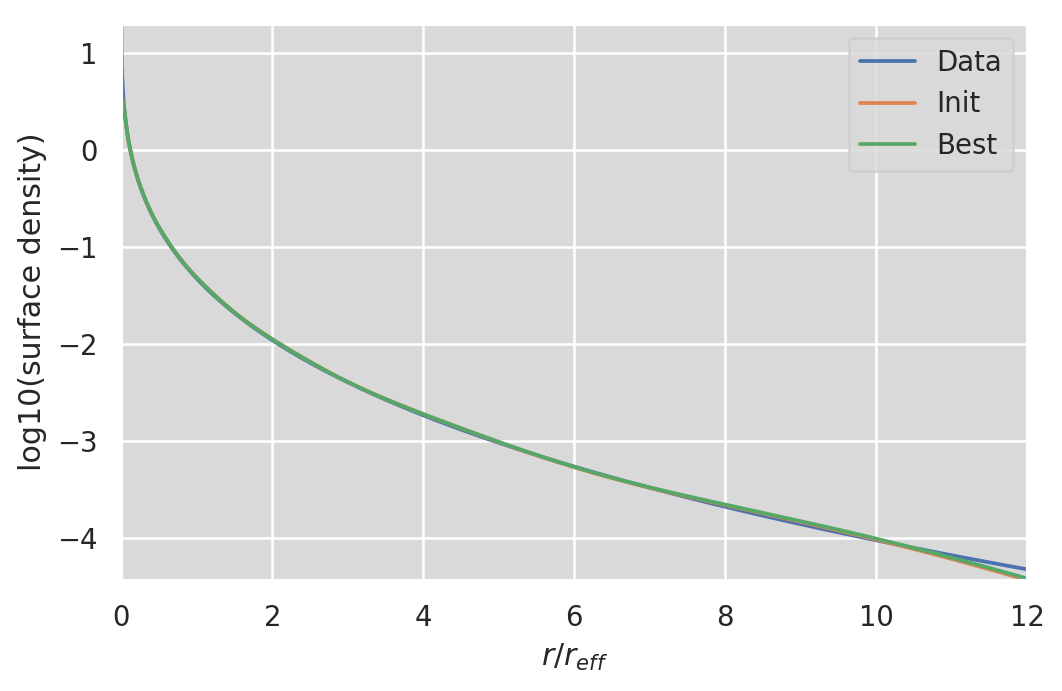

[92, 24000]
Init  chisq = -8.12284595392618
ws, re: (array([0.12348422, 0.20219008, 0.22461937, 0.191619  , 0.1323144 ,
       0.07574608, 0.03602429, 0.01400256]), array([5.67976649, 2.56070775, 1.30105192, 0.68300709, 0.3597468 ,
       0.18636987, 0.09302904, 0.04341385]))
         Current function value: -8.651334
         Iterations: 21
         Function evaluations: 1474
         Gradient evaluations: 86
-8.651333638511435 [-1.9528521  -1.21153183 -0.706727   -0.31325037  0.03326965  0.39604906
  0.92600506  0.75751851  0.41082552  0.11659882 -0.16323539 -0.44136538
 -0.72628426 -1.02668711 -1.3551852 ]
n=3.55: (
    normalize(np.array([1.2424269824e-01, 2.0092510605e-01, 2.2291222831e-01, 1.9085554555e-01, 1.3270339084e-01, 7.6726270591e-02, 3.6984125051e-02, 1.4650635372e-02])),
    np.array([5.7216133501e+00, 2.5752863124e+00, 1.3079731213e+00, 6.8669613925e-01, 3.6193836223e-01, 1.8780871255e-01, 9.4040057594e-02, 4.4138218593e-02]),
),
[95, 24000]
Init  chisq = -8.1429455133

         Current function value: -8.770131
         Iterations: 21
         Function evaluations: 1508
         Gradient evaluations: 88
-8.770130688173447 [-1.90254364 -1.26538093 -0.80160857 -0.42932461 -0.09616579  0.25910868
  0.79153262  0.78076174  0.42953482  0.13507386 -0.14365899 -0.41886848
 -0.69804495 -0.98824525 -1.29916314]
n=3.95: (
    normalize(np.array([1.2982085534e-01, 1.9148203802e-01, 2.1017996245e-01, 1.8473050976e-01, 1.3507592855e-01, 8.3934876296e-02, 4.4576155591e-02, 2.0199673979e-02])),
    np.array([6.0361738369e+00, 2.6886534107e+00, 1.3648152416e+00, 7.1835812288e-01, 3.8118124005e-01, 2.0042645906e-01, 1.0274359418e-01, 5.0215392010e-02]),
),
[120, 24000]
0.9728357135388462 0.9916129032293254
Init  chisq = -8.313421689210942
ws, re: (array([0.12982086, 0.19148204, 0.21017996, 0.18473051, 0.13507593,
       0.08393488, 0.04457616, 0.02019967]), array([6.03617384, 2.68865341, 1.36481524, 0.71835812, 0.38118124,
       0.20042646, 0.10274359, 0.05021539]))

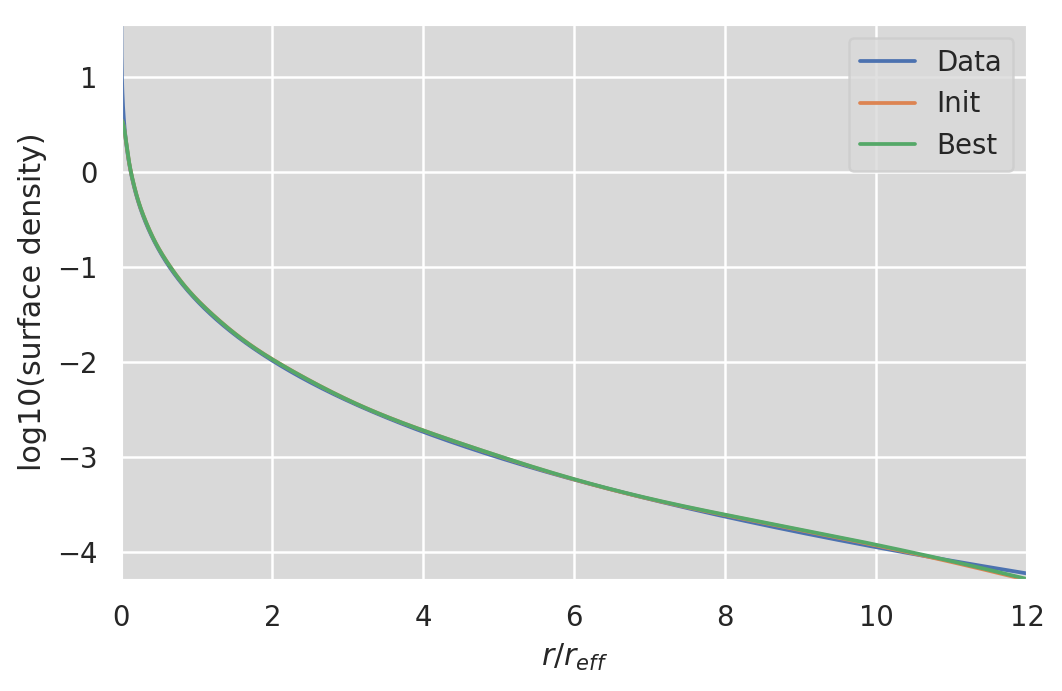

[126, 24000]
Init  chisq = -7.87754034948971
ws, re: (array([0.13050468, 0.19044951, 0.20874611, 0.18397333, 0.13525664,
       0.08470887, 0.04546194, 0.02089892]), array([6.0721046 , 2.70160619, 1.37145454, 0.72211814, 0.38348405,
       0.20193609, 0.10377948, 0.0509335 ]))
         Current function value: -8.814211
         Iterations: 25
         Function evaluations: 1422
         Gradient evaluations: 83
-8.814211006079042 [-1.88471486 -1.28281117 -0.83296849 -0.46765337 -0.13849431  0.21516969
  0.74966097  0.78833091  0.43569124  0.14133467 -0.13688909 -0.41104235
 -0.68830863 -0.97528337 -1.2809355 ]
n=4.1: (
    normalize(np.array([1.3184825326e-01, 1.8845150516e-01, 2.0596124832e-01, 1.8247090558e-01, 1.3556538948e-01, 8.6194808862e-02, 4.7203142808e-02, 2.2304746523e-02])),
    np.array([6.1422983252e+00, 2.7270383257e+00, 1.3846329804e+00, 7.2964381891e-01, 3.8811251476e-01, 2.0497050317e-01, 1.0585627962e-01, 5.2367820579e-02]),
),
[133, 24000]
Init  chisq = -7.929680061

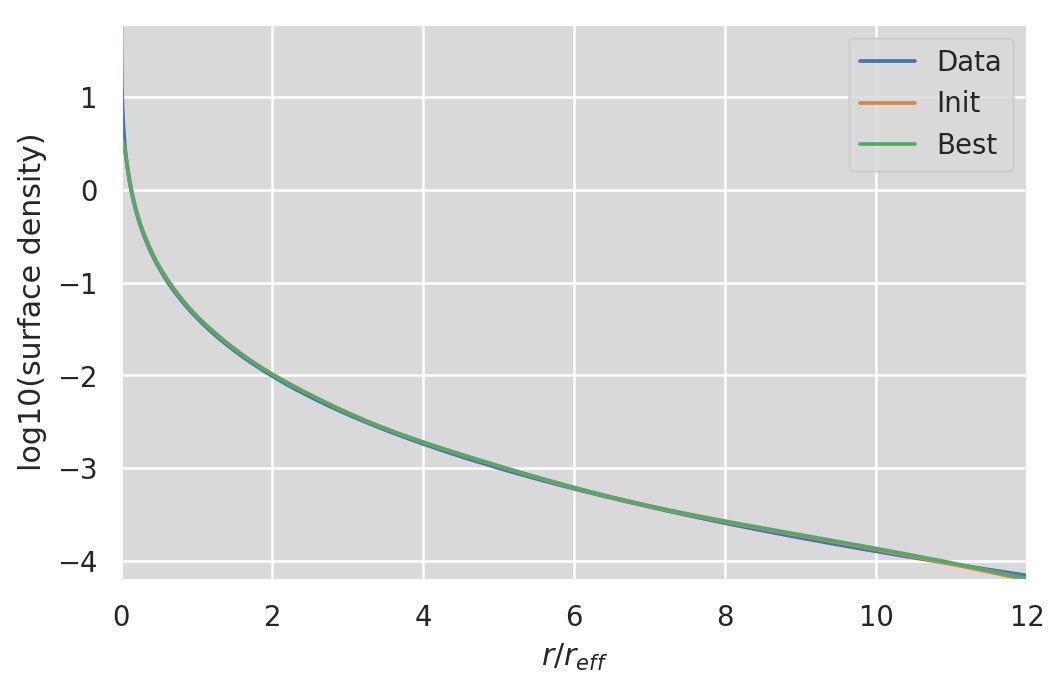

[157, 24000]
Init  chisq = -8.119978532157601
ws, re: (array([0.13679595, 0.18107789, 0.19569084, 0.17664236, 0.13629838,
       0.09152076, 0.05389147, 0.02808236]), array([6.40714725, 2.82602581, 1.43833816, 0.76135081, 0.40793349,
       0.2179747 , 0.11466727, 0.05836164]))
         Current function value: -8.972610
         Iterations: 24
         Function evaluations: 1710
         Gradient evaluations: 100
-8.972610157944853 [-1.83199246 -1.33574337 -0.92783735 -0.58273455 -0.26404933  0.08721181
  0.63083147  0.81075718  0.45463919  0.16162021 -0.11416758 -0.38442678
 -0.65547514 -0.93270994 -1.22344093]
n=4.6: (
    normalize(np.array([1.3800108550e-01, 1.7947759703e-01, 1.9340174843e-01, 1.7525331033e-01, 1.3633363296e-01, 9.2634596733e-02, 5.5411073464e-02, 2.9486955550e-02])),
    np.array([6.4678088446e+00, 2.8486506589e+00, 1.4508422920e+00, 7.6883371839e-01, 4.1264180362e-01, 2.2106747922e-01, 1.1675891742e-01, 5.9780435479e-02]),
),
[163, 24000]
Init  chisq = -8.1679314

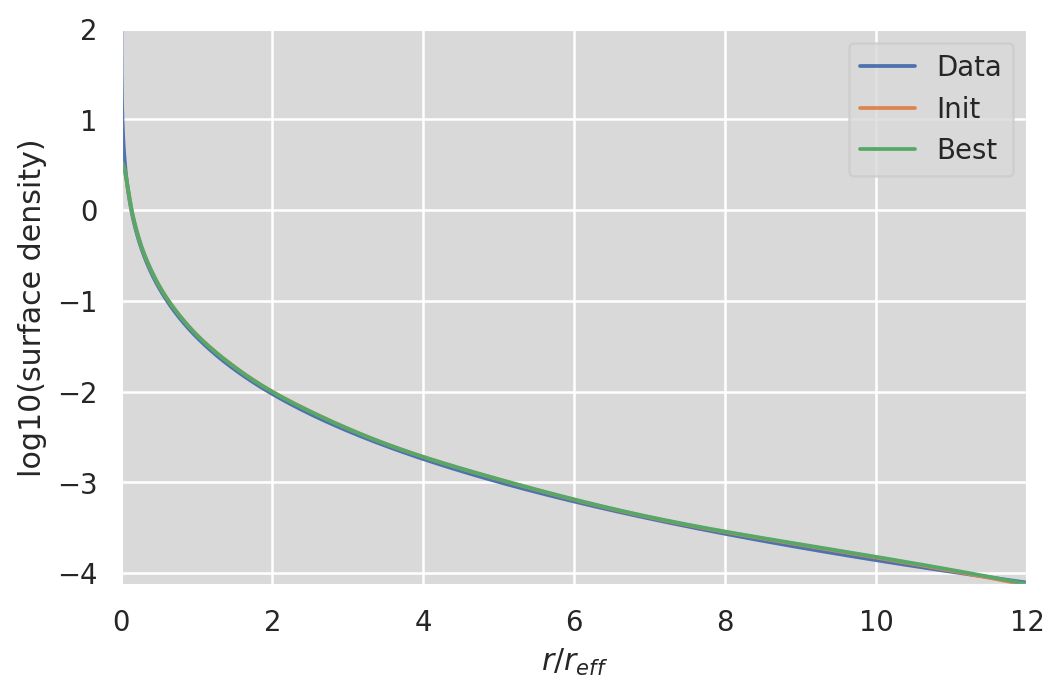

[185, 24000]
Init  chisq = -8.349310464471241
ws, re: (array([0.14267733, 0.17387113, 0.1851987 , 0.17001197, 0.13606987,
       0.09637739, 0.0609151 , 0.03487849]), array([6.69136902, 2.93173118, 1.49746205, 0.79706075, 0.43050679,
       0.23281908, 0.12469829, 0.06515609]))
         Current function value: -9.115532
         Iterations: 23
         Function evaluations: 1405
         Gradient evaluations: 82
-9.115531745910161 [-1.78363578 -1.37547058 -1.00280505 -0.67398635 -0.36261163 -0.01120145
  0.54219897  0.8287298   0.46974287  0.17819569 -0.09530232 -0.36227848
 -0.62843076 -0.89837814 -1.17853484]
n=5.1: (
    normalize(np.array([1.4385476871e-01, 1.7271653842e-01, 1.8342561335e-01, 1.6880344284e-01, 1.3590032251e-01, 9.7102753727e-02, 6.2092022761e-02, 3.6104537687e-02])),
    np.array([6.7410849907e+00, 2.9494624615e+00, 1.5072860892e+00, 8.0296696510e-01, 4.3423169189e-01, 2.3527145325e-01, 1.2636356070e-01, 6.6292615794e-02]),
),
[191, 24000]
Init  chisq = -8.39802452

         Current function value: -9.297676
         Iterations: 21
         Function evaluations: 1678
         Gradient evaluations: 98
-9.297676116512461 [-1.71409912 -1.41758706 -1.08988695 -0.78128243 -0.47798546 -0.12466264
  0.44247142  0.8504583   0.48726894  0.19743519 -0.07338435 -0.33666455
 -0.597441   -0.85957092 -1.12873687]
n=5.9: (
    normalize(np.array([1.5263279721e-01, 1.6527061363e-01, 1.7164249011e-01, 1.6030482138e-01, 1.3401191261e-01, 1.0134132908e-01, 6.9893309704e-02, 4.4902726281e-02])),
    np.array([7.0869325837e+00, 3.0709230996e+00, 1.5755608787e+00, 8.4453110174e-01, 4.6061221277e-01, 2.5267309268e-01, 1.3817487527e-01, 7.4346945689e-02]),
),
[224, 24000]
0.9360892302700337 0.9790761658433195
Init  chisq = -8.69960181874897
ws, re: (array([0.1526328 , 0.16527061, 0.17164249, 0.16030482, 0.13401191,
       0.10134133, 0.06989331, 0.04490273]), array([7.08693258, 3.0709231 , 1.57556088, 0.8445311 , 0.46061221,
       0.25267309, 0.13817488, 0.07434695]))
 

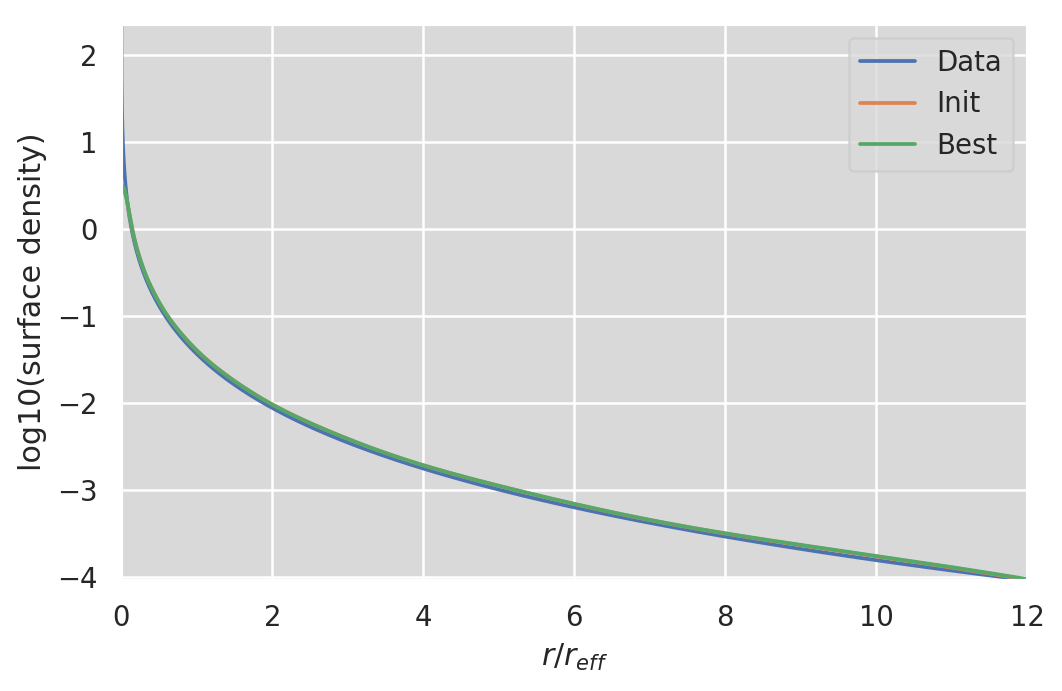

[228, 24000]
Init  chisq = -8.454632179609586
ws, re: (array([0.15371714, 0.164631  , 0.17052244, 0.15941948, 0.13371155,
       0.10163821, 0.07058963, 0.04577055]), array([7.12102143, 3.08139087, 1.58099255, 0.84766436, 0.46254286,
       0.25394296, 0.13905432, 0.07496688]))
         Current function value: -9.332344
         Iterations: 25
         Function evaluations: 1745
         Gradient evaluations: 102
-9.332343636601333 [-1.69345516 -1.42509835 -1.10866321 -0.80520977 -0.5039466  -0.1501196
  0.42035919  0.85546692  0.49074786  0.20089794 -0.06970401 -0.33253813
 -0.59250212 -0.85330111 -1.12048714]
n=6.15: (
    normalize(np.array([1.5532199382e-01, 1.6375229136e-01, 1.6895141846e-01, 1.5815510788e-01, 1.3325313722e-01, 1.0202071428e-01, 7.1550313816e-02, 4.6995023162e-02])),
    np.array([7.1691376391e+00, 3.0956215584e+00, 1.5881734934e+00, 8.5171831851e-01, 4.6500954888e-01, 2.5556294280e-01, 1.4018414187e-01, 7.5772716668e-02]),
),
[232, 24000]
Init  chisq = -8.5046184

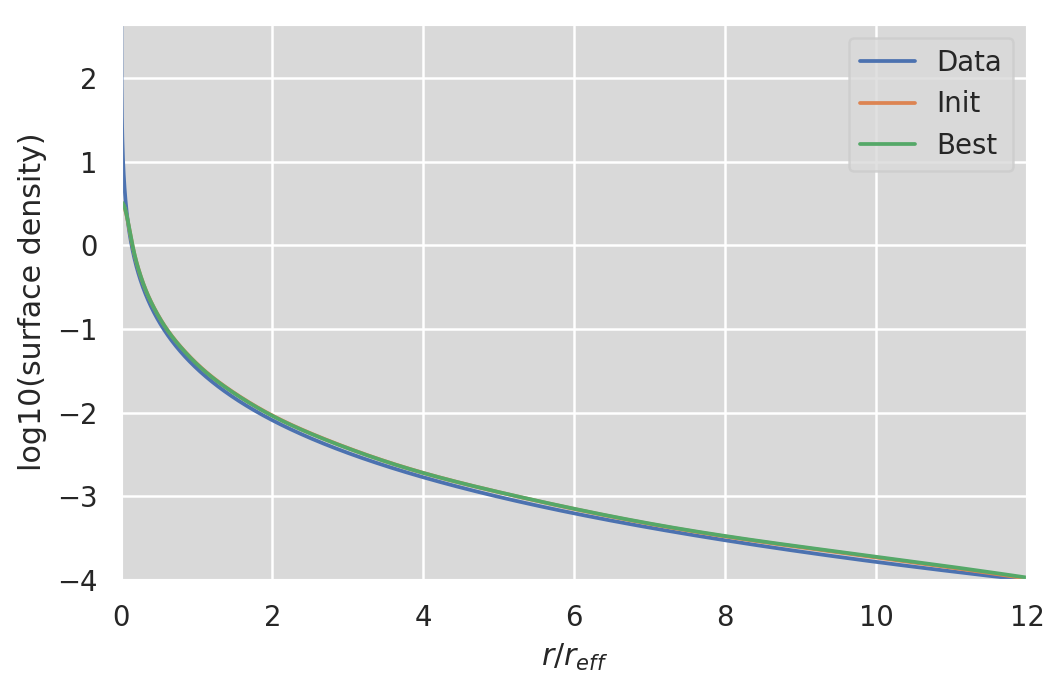

[239, 24000]
Init  chisq = -8.327499905122364
ws, re: (array([0.16386663, 0.16024544, 0.16209438, 0.15226567, 0.13064629,
       0.10310843, 0.07541083, 0.05236234]), array([7.38007134, 3.14602958, 1.60865178, 0.86106414, 0.46989856,
       0.25870387, 0.14258609, 0.07772669]))
         Current function value: -9.386949
         Iterations: 29
         Function evaluations: 1591
         Gradient evaluations: 93
-9.386949480522722 [-1.61243765 -1.43997786 -1.16115261 -0.87574106 -0.58205888 -0.22711888
  0.35383153  0.87037572  0.49814767  0.20578831 -0.06655961 -0.33034966
 -0.59008588 -0.84906339 -1.11248154]
n=7.25: (
    normalize(np.array([1.6625045286e-01, 1.5970370584e-01, 1.6073156436e-01, 1.5094576702e-01, 1.2989424725e-01, 1.0309375739e-01, 7.6017050931e-02, 5.3363454357e-02])),
    np.array([7.4195185262e+00, 3.1488187998e+00, 1.6061581655e+00, 8.5790735842e-01, 4.6735870589e-01, 2.5698875542e-01, 1.4155871583e-01, 7.7182431675e-02]),
),
[236, 24000]
Init  chisq = -8.3622762

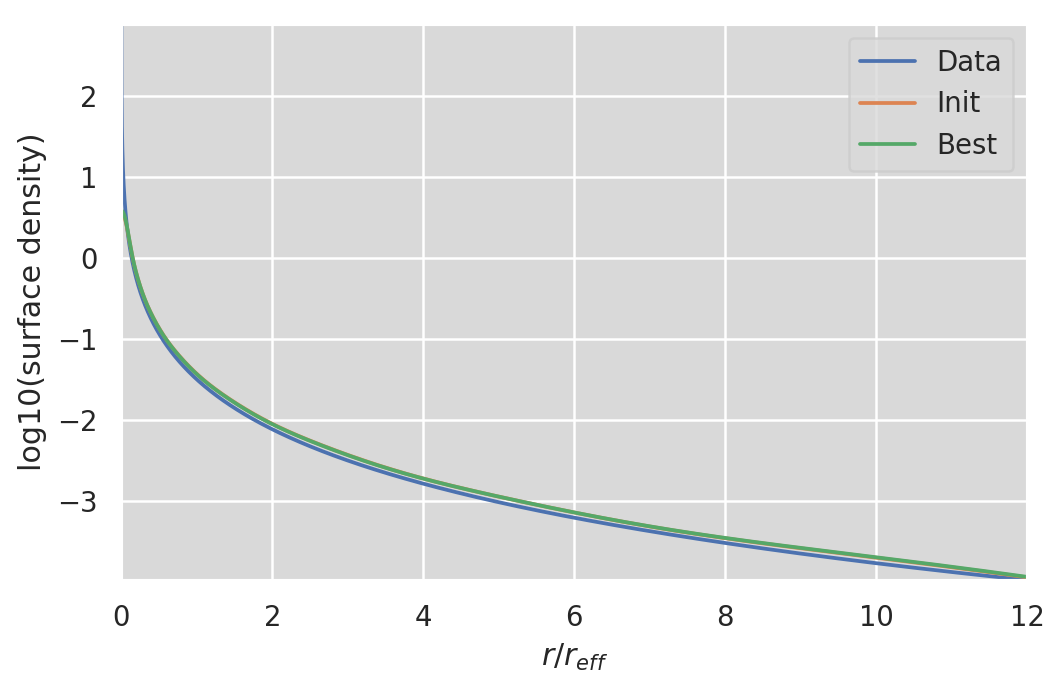

In [8]:
# Fit for n>1. It works well enough up to n=2
# For n>2, the steep cusp requires components to migrate in further and further, degrading the quality of the fit at R/Re > 4
# Since we aren't convinced that real galaxies are that cuspy, we skip fitting a small fraction of the interior profile
# The arbitrary fraction I picked scales as a sinusoid from 0 at n=1 to 0.5*0.12 at n=4 and caps at 0.12 at n=7.
# The sinusoidal function is a reasonable choice for its continuous derivatives
def funcrangefitn(radii, n):
    nbins = len(radii)
    facn = (np.sin((n-4)/6*np.pi)+1.)/2.
    # np.int(np.floor(nbins*(1-facn/3.)))
    ranges = [np.int(np.round(facn*nbins/100.)), nbins]
    print(ranges)
    return range(ranges[0], ranges[1])

# Close to np.round(10**np.linspace(np.log10(0.5005), np.log10(6.3), num=100), 4)

nvals = [
    (
        np.array([
            1., 1.025, 1.05, 1.075, 1.10, 1.135, 1.165, 1.2, 1.225, 1.25, 1.275,
            1.3, 1.333, 1.367, 1.4, 1.433, 1.467, 1.5, 1.55, 1.6, 1.65, 1.7,
            1.75, 1.8, 1.85, 1.9 , 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3,
            2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9,
            2.95, 3., 3.05, 3.1, 3.15, 3.2, 3.25, 3.3, 3.35, 3.4, 3.45, 3.5,
            3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4., 4.1, 4.2,
            4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5., 5.1, 5.2, 5.3, 5.4, 5.5,
            5.6, 5.7, 5.8, 5.9, 6., 6.15, 6.3, 6.45, 6.6, 6.75, 7, 7.25, 7.5,
            7.75, 8,
        ]),
        (
            normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01,
                                6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
            np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01,
                      2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
        ),
    )
]
fitweights(nvals, rmid, areasq, funcrangefit=funcrangefitn, plotnth=np.Inf, plotvals=[1., 1.2, 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 6., 7., 8.])

### 4-Component Sersic MGA

Unsurprisingly, 4 Gaussians is not enough to accurately approximate a Sersic profile as you'll see below, but it's useful as a starting point for free MG fits.

Init  chisq = -8.034436622248457
ws, re: (array([0.59933484, 0.35956993, 0.03777997, 0.00331526]), array([1.08885318, 0.92149653, 0.64439709, 0.379284  ]))
         Current function value: -11.866127
         Iterations: 73
         Function evaluations: 1191
         Gradient evaluations: 131
-11.86612675237935 [ 1.03949797  2.74177944  2.94245234  0.0252867  -0.05665531 -0.25646952
 -0.57025258]
n=0.53: (
    normalize(np.array([7.3875312820e-01, 2.4542769471e-01, 1.5026724116e-02, 7.9245297099e-04])),
    np.array([1.0599532357e+00, 8.7769714840e-01, 5.5402642897e-01, 2.6899699021e-01]),
),
Init  chisq = -8.58937138783239
ws, re: (array([0.73875313, 0.24542769, 0.01502672, 0.00079245]), array([1.05995324, 0.87769715, 0.55402643, 0.26899699]))
         Current function value: -12.063909
         Iterations: 50
         Function evaluations: 1254
         Gradient evaluations: 138
-12.063908737481464 [ 1.20455043  2.8321562   2.95494346  0.02134281 -0.05747228 -0.25775645
 -0.57124271

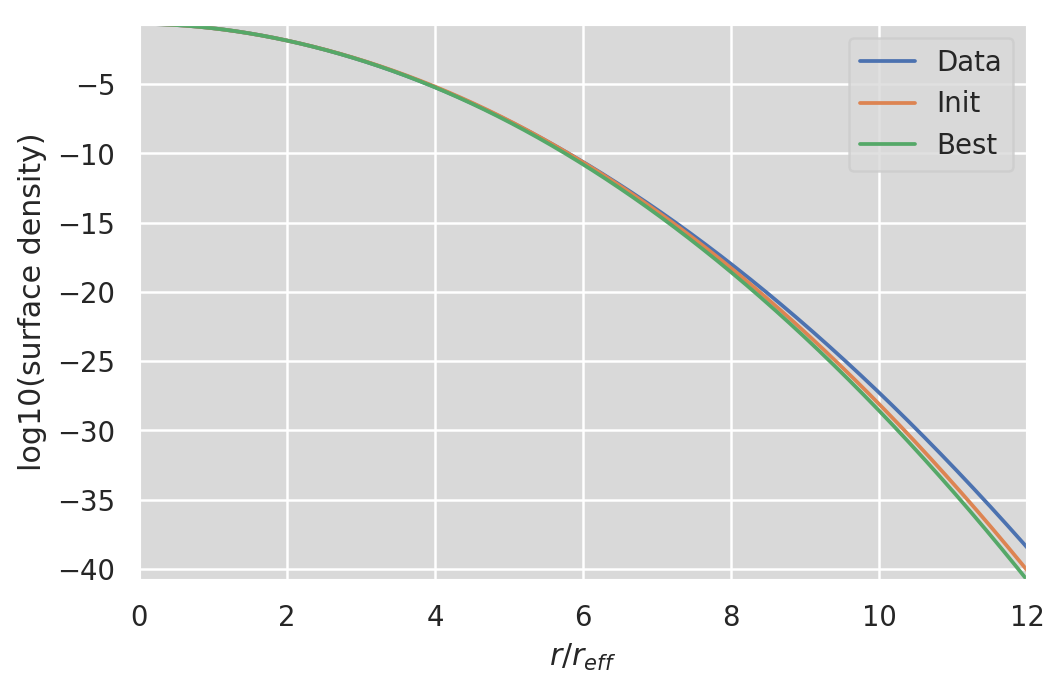

Init  chisq = -9.370920085839352
ws, re: (array([8.02462654e-01, 1.87483504e-01, 9.56087975e-03, 4.92962494e-04]), array([1.04076409, 0.87518613, 0.5517243 , 0.26844515]))
         Current function value: -12.407412
         Iterations: 34
         Function evaluations: 857
         Gradient evaluations: 94
-12.407412035467917 [ 1.4923208   2.96292641  2.96873454  0.01574368 -0.05786937 -0.25802255
 -0.57053272]
n=0.518: (
    normalize(np.array([8.1642635696e-01, 1.7455483203e-01, 8.5781654557e-03, 4.4064555255e-04])),
    np.array([1.0369162425e+00, 8.7524699659e-01, 5.5204878050e-01, 2.6882353098e-01]),
),
1.0000000147261765 1.000000014750097
Init  chisq = -9.367752837641909
ws, re: (array([8.16426357e-01, 1.74554832e-01, 8.57816546e-03, 4.40645553e-04]), array([1.03691624, 0.875247  , 0.55204878, 0.26882353]))
         Current function value: -12.526829
         Iterations: 34
         Function evaluations: 758
         Gradient evaluations: 83
-12.52682930655028 [ 1.59886643  3.00

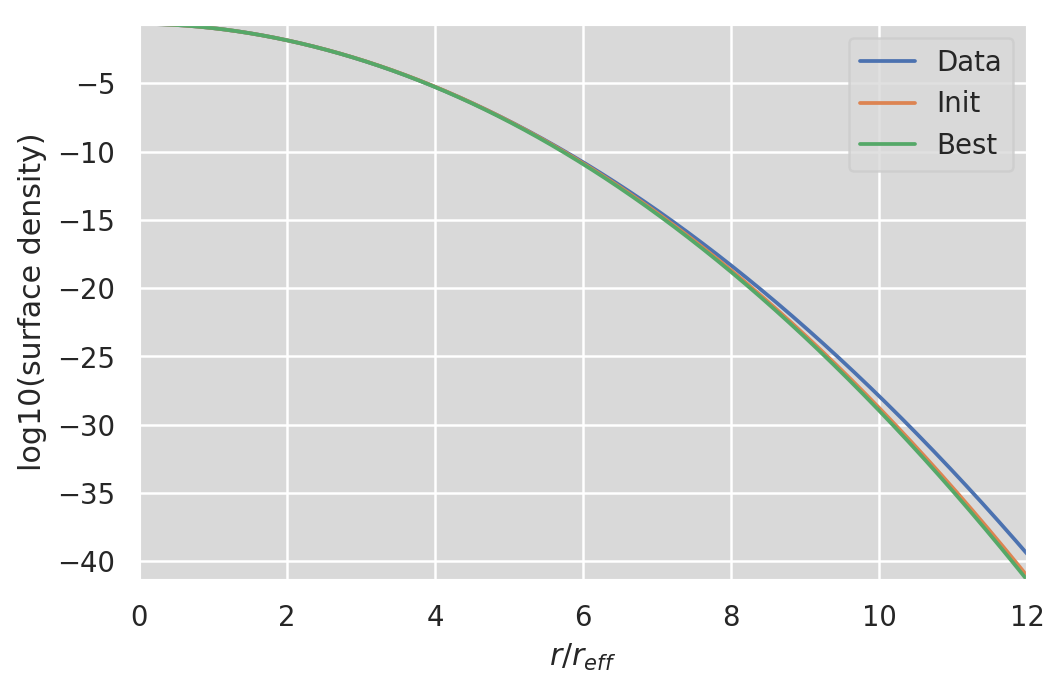

Init  chisq = -9.364410475842556
ws, re: (array([8.31859893e-01, 1.60202231e-01, 7.55112837e-03, 3.86747174e-04]), array([1.03298095, 0.87494024, 0.55167045, 0.26877691]))
         Current function value: -12.660420
         Iterations: 36
         Function evaluations: 1353
         Gradient evaluations: 149
-12.660419910937634 [ 1.72851801  3.05138722  2.9760985   0.01238439 -0.05850127 -0.25948261
 -0.5717555 ]
n=0.514: (
    normalize(np.array([8.4922275979e-01, 1.4396849873e-01, 6.4783989118e-03, 3.3034256095e-04])),
    np.array([1.0289265869e+00, 8.7397444646e-01, 5.5019594913e-01, 2.6806770434e-01]),
),
1.0000000146538368 1.0000000146806403
Init  chisq = -9.36125323190853
ws, re: (array([8.49222760e-01, 1.43968499e-01, 6.47839891e-03, 3.30342561e-04]), array([1.02892659, 0.87397445, 0.55019595, 0.2680677 ]))
         Current function value: -12.811894
         Iterations: 57
         Function evaluations: 1002
         Gradient evaluations: 110
-12.811893709911118 [ 1.87474001 

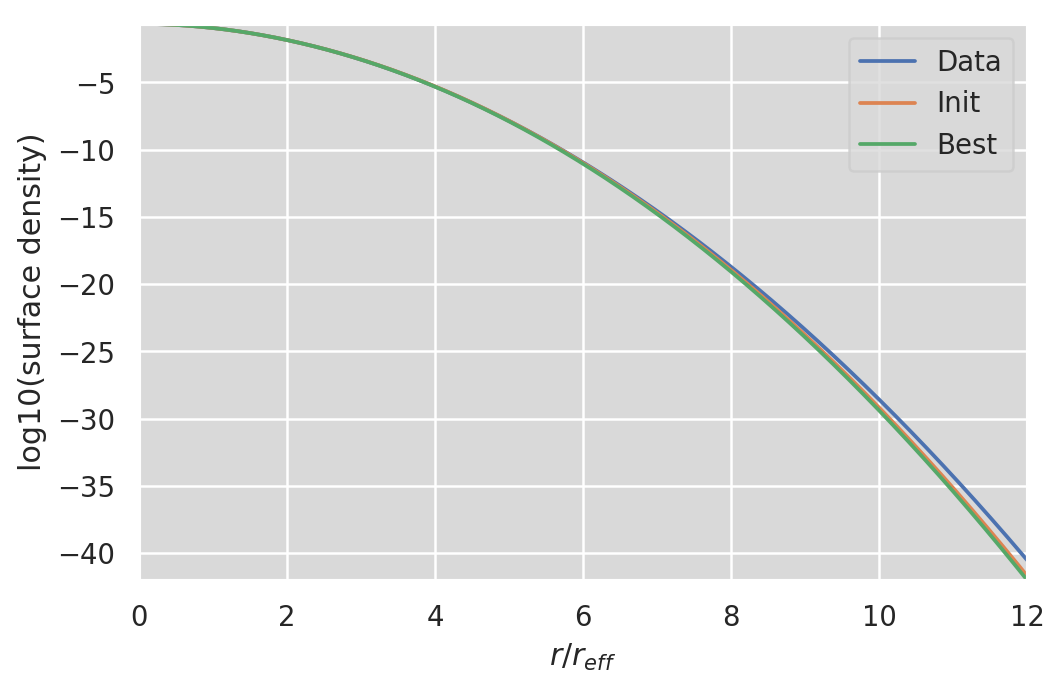

Init  chisq = -9.357965121281481
ws, re: (array([8.67005784e-01, 1.27249087e-01, 5.46729537e-03, 2.77833207e-04]), array([1.02489067, 0.87337269, 0.54922934, 0.26767358]))
         Current function value: -12.988654
         Iterations: 67
         Function evaluations: 1262
         Gradient evaluations: 139
-12.988653747865165 [ 2.042605    3.14286084  2.9810614   0.00897209 -0.05881506 -0.26027386
 -0.57198283]
n=0.51: (
    normalize(np.array([8.8519826027e-01, 1.1005198944e-01, 4.5203904184e-03, 2.2935986869e-04])),
    np.array([1.0208738812e+00, 8.7334319737e-01, 5.4919444425e-01, 2.6792742286e-01]),
),
Init  chisq = -9.95737971247538
ws, re: (array([8.85198260e-01, 1.10051989e-01, 4.52039042e-03, 2.29359869e-04]), array([1.02087388, 0.8733432 , 0.54919444, 0.26792742]))
         Current function value: -13.088964
         Iterations: 33
         Function evaluations: 840
         Gradient evaluations: 92
-13.088963863183265 [ 2.14731411  3.16914042  2.98162043  0.00808932 -0.05

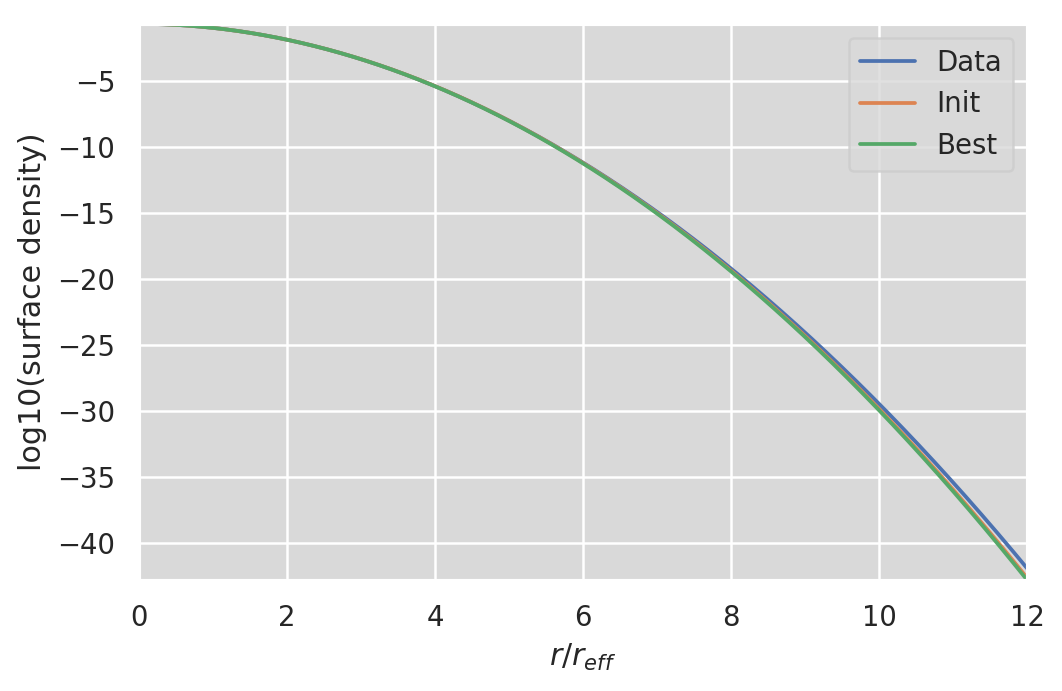

Init  chisq = -9.952638544961493
ws, re: (array([9.15365495e-01, 8.13674913e-02, 3.10912064e-03, 1.57893038e-04]), array([1.01473307, 0.87299462, 0.54864572, 0.26817754]))
         Current function value: -13.468749
         Iterations: 42
         Function evaluations: 1065
         Gradient evaluations: 117
-13.468749384961392 [ 2.52814063  3.23970514  2.98186417  0.00546699 -0.05900914 -0.26079277
 -0.57162108]
n=0.506: (
    normalize(np.array([9.2609118718e-01, 7.1122555100e-02, 2.6518153568e-03, 1.3444235955e-04])),
    np.array([1.0126677857e+00, 8.7295300140e-01, 5.4853864048e-01, 2.6815069027e-01]),
),
Init  chisq = -9.950781968885398
ws, re: (array([9.26091187e-01, 7.11225551e-02, 2.65181536e-03, 1.34442360e-04]), array([1.01266779, 0.872953  , 0.54853864, 0.26815069]))
         Current function value: -13.635924
         Iterations: 47
         Function evaluations: 1398
         Gradient evaluations: 154
-13.635924352403071 [ 2.69467951  3.26082406  2.98135279  0.00458933 -

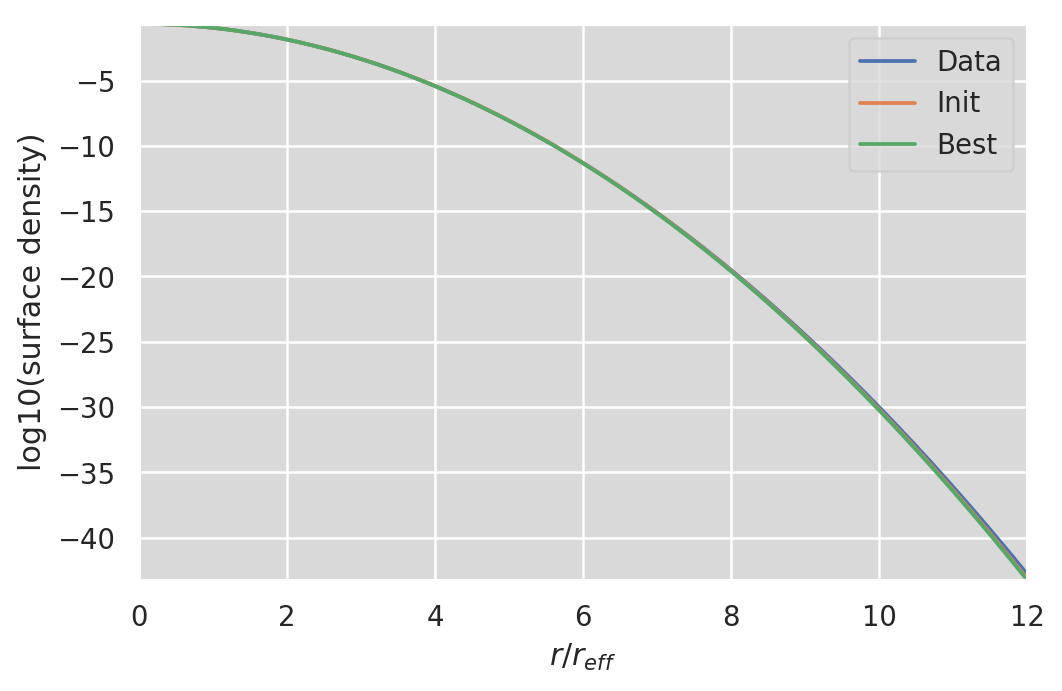

Init  chisq = -9.947259952264128
ws, re: (array([9.36482440e-01, 6.10352906e-02, 2.36023890e-03, 1.22030515e-04]), array([1.00922523, 0.89138101, 0.58192225, 0.28989137]))
         Current function value: -12.770931
         Iterations: 67
         Function evaluations: 1695
         Gradient evaluations: 187
-12.770931231080775 [ 3.69409011e+00  3.83793149e+00  1.33618113e+00  2.30348875e-03
 -8.44664025e-02 -3.81064763e-01 -3.44105003e-01]
n=0.503: (
    normalize(np.array([9.7573343876e-01, 2.3754925121e-02, 1.0649131340e-04, 4.0514480740e-04])),
    np.array([1.0053180699e+00, 8.2325352217e-01, 4.5278809229e-01, 4.1584859376e-01]),
),
Init  chisq = -9.945833811362206
ws, re: (array([9.75733439e-01, 2.37549251e-02, 4.05144807e-04, 1.06491313e-04]), array([1.00531807, 0.82325352, 0.41584859, 0.45278809]))
         Current function value: -14.247857
         Iterations: 43
         Function evaluations: 1191
         Gradient evaluations: 131
-14.247857203539875 [ 3.82339990e+00  3.46

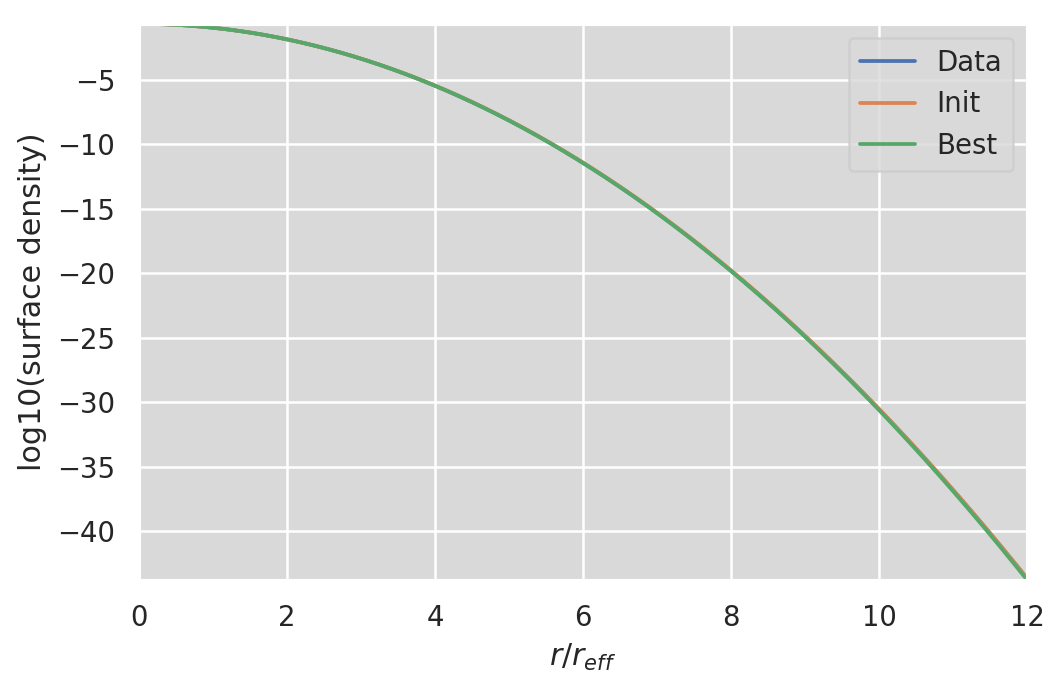

Init  chisq = -9.942575682482813
ws, re: (array([9.74986372e-01, 2.01610724e-02, 4.71176598e-03, 1.40790073e-04]), array([1.00234506, 0.95177375, 0.78803063, 0.40710862]))
         Current function value: -17.056607
         Iterations: 25
         Function evaluations: 1191
         Gradient evaluations: 131
-17.056606633384614 [ 3.67571550e+00  1.66051737e+00  4.07447015e+00  1.81365497e-05
 -5.08407650e-04 -1.72749597e-03 -5.99643331e-03]
n=0.5: (
    normalize(np.array([9.7529454617e-01, 2.0760176699e-02, 3.8793238890e-03, 6.5953240275e-05])),
    np.array([1.0000417618e+00, 9.9883003307e-01, 9.9603019413e-01, 9.8628758559e-01]),
),


In [9]:
# Despite my best efforts, free weights and sizes don't work for N=4 either:
nvals = [
    (
        np.array([
            0.53, 0.525, 0.52,
        ]),
        (
    normalize(np.array([5.9919829101e-01, 3.5948801370e-01, 3.7771361281e-02, 3.3145069862e-03])),
    np.array([1.0888531764e+00, 9.2149653125e-01, 6.4439708848e-01, 3.7928399702e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=3)
nvals = [
    (
        np.array([
            0.518, 0.516, 0.514, 0.512, 0.51,
        ]),
        (
    normalize(np.array([8.0246265385e-01, 1.8748350391e-01, 9.5608797516e-03, 4.9296249415e-04])),
    np.array([1.0407640924e+00, 8.7518613346e-01, 5.5172430276e-01, 2.6844514757e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=2)
nvals = [
    (
        np.array([
            0.509, 0.508, 0.507, 0.506, 0.505, 0.504, 0.503, 0.502, 0.501, 0.5
        ]),
        (
            normalize(np.array([8.8519826027e-01, 1.1005198944e-01, 4.5203904184e-03, 2.2935986869e-04])),
            np.array([1.0208738812e+00, 8.7334319737e-01, 5.4919444425e-01, 2.6792742286e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=3)

Init  chisq = -7.56952619808977
ws, re: (array([0.32466848, 0.4780321 , 0.17258587, 0.02471355]), array([1.70077926, 0.97809128, 0.51487137, 0.21966932]))
Optimization terminated successfully.
         Current function value: -8.077198
         Iterations: 15
         Function evaluations: 225
         Gradient evaluations: 25
-8.077198007238293 [-0.72152067  0.91231904  1.97189707  0.22369629 -0.01094158 -0.28573695
 -0.65251265]
n=0.975: (
    normalize(np.array([3.2705820815e-01, 4.8012679182e-01, 1.6925584733e-01, 2.3559152698e-02])),
    np.array([1.6737719728e+00, 9.7512079513e-01, 5.1792043407e-01, 2.2258062250e-01]),
),
Init  chisq = -7.577230483771114
ws, re: (array([0.32705821, 0.48012679, 0.16925585, 0.02355915]), array([1.67377197, 0.9751208 , 0.51792043, 0.22258062]))
         Current function value: -8.158426
         Iterations: 13
         Function evaluations: 614
         Gradient evaluations: 67
-8.158426052242126 [-0.70884739  0.941896    2.00195907  0.21648135 -0.0

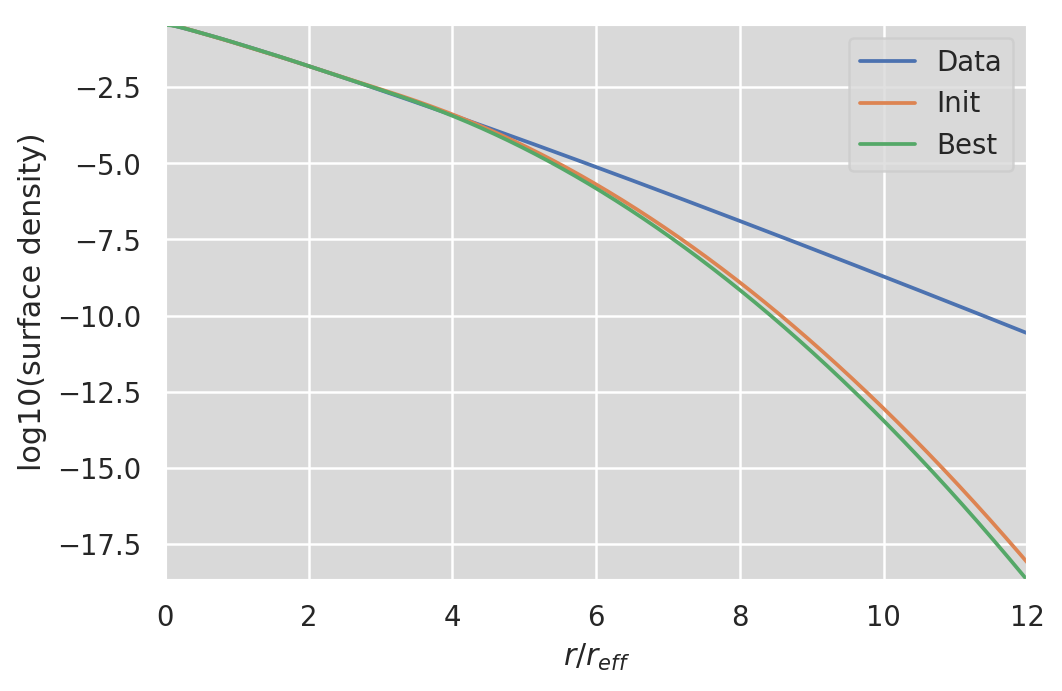

Init  chisq = -7.575560357283357
ws, re: (array([0.33693484, 0.48589217, 0.15728351, 0.01988947]), array([1.58924164, 0.96484912, 0.52702461, 0.23157178]))
         Current function value: -8.434707
         Iterations: 15
         Function evaluations: 866
         Gradient evaluations: 95
-8.43470713864832 [-0.6570849   1.04697347  2.10407363  0.19307307 -0.01730591 -0.27569863
 -0.62958892]
n=0.875: (
    normalize(np.array([3.4139475178e-01, 4.8749519173e-01, 1.5251013392e-01, 1.8599922570e-02])),
    np.array([1.5598149092e+00, 9.6093516491e-01, 5.3003111821e-01, 2.3464487823e-01]),
),
Init  chisq = -7.566896583249418
ws, re: (array([0.34139475, 0.48749519, 0.15251013, 0.01859992]), array([1.55981491, 0.96093516, 0.53003112, 0.23464488]))
         Current function value: -8.539921
         Iterations: 15
         Function evaluations: 280
         Gradient evaluations: 31
-8.539920768878831 [-0.63393289  1.08878675  2.14274894  0.18461091 -0.0191991  -0.27326176
 -0.62388252]
n=0.

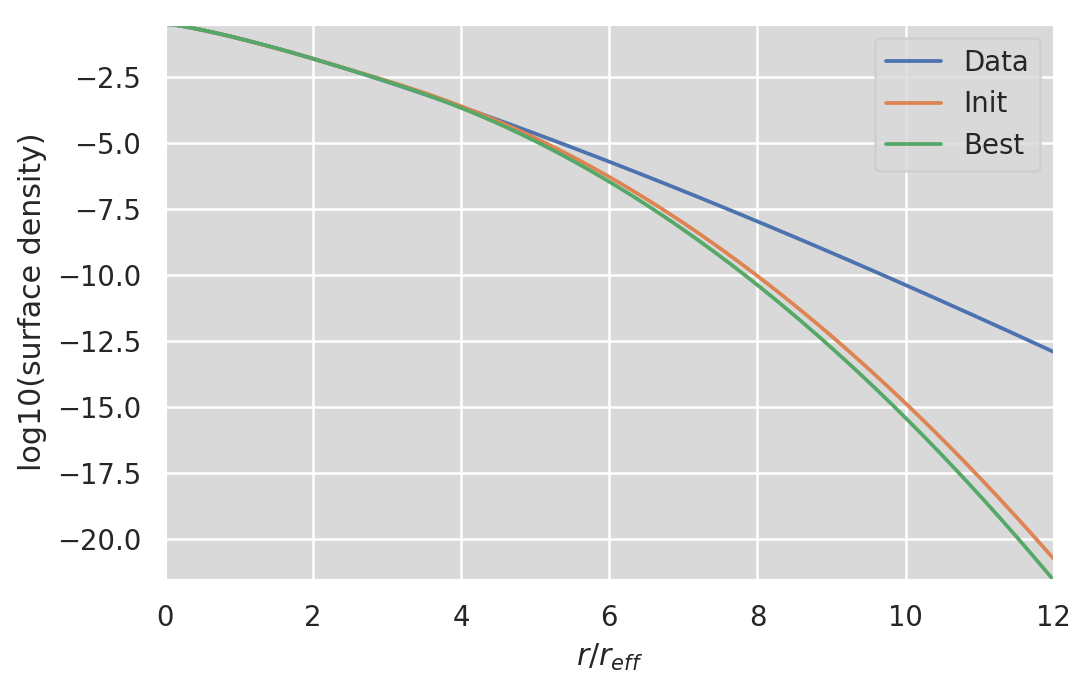

Init  chisq = -7.519539514930755
ws, re: (array([0.359994  , 0.49025639, 0.13519107, 0.01455854]), array([1.46737358, 0.94755131, 0.53887419, 0.24401511]))
         Current function value: -8.908522
         Iterations: 16
         Function evaluations: 649
         Gradient evaluations: 71
-8.908522327379139 [-0.53830852  1.24294686  2.27618166  0.15686658 -0.02571978 -0.2662196
 -0.60702851]
n=0.775: (
    normalize(np.array([3.6858115238e-01, 4.9002935491e-01, 1.2822402555e-01, 1.3165467156e-02])),
    np.array([1.4350485124e+00, 9.4249753902e-01, 5.4172689777e-01, 2.4715619082e-01]),
),
Init  chisq = -7.497618524142937
ws, re: (array([0.36858115, 0.49002935, 0.12822403, 0.01316547]), array([1.43504851, 0.94249754, 0.5417269 , 0.24715619]))
         Current function value: -9.053846
         Iterations: 20
         Function evaluations: 893
         Gradient evaluations: 98
-9.05384566806524 [-0.49450813  1.30696218  2.32747325  0.14671558 -0.02820137 -0.26399666
 -0.60157255]
n=0.7

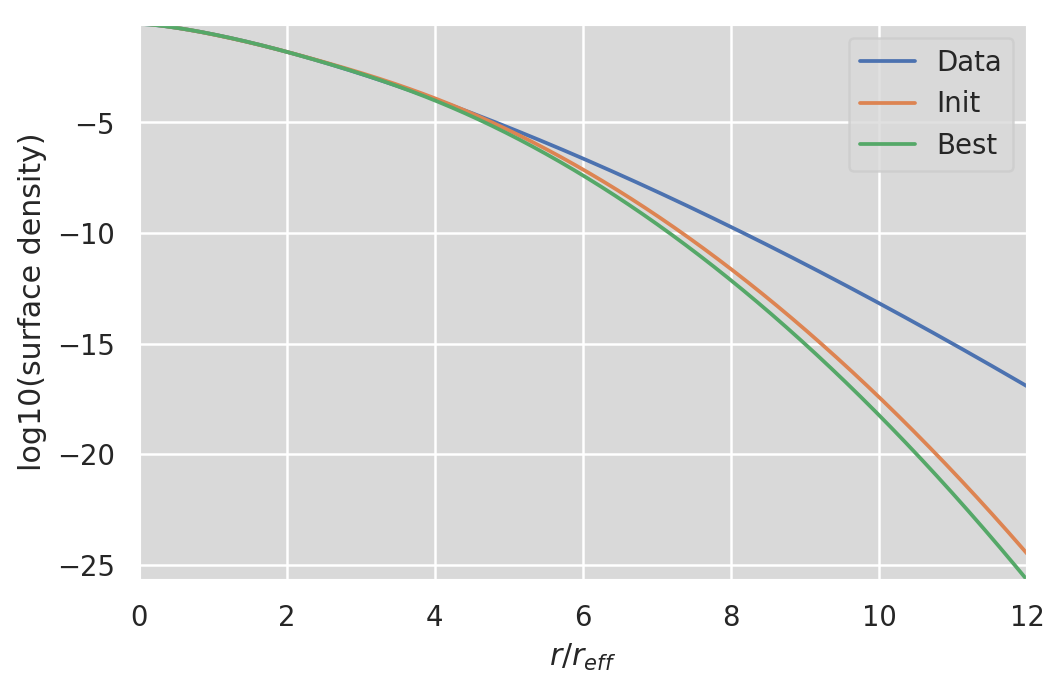

Init  chisq = -7.41754636570788
ws, re: (array([0.40619261, 0.48211835, 0.10275368, 0.00893535]), array([1.33287327, 0.9253884 , 0.54973719, 0.25638263]))
         Current function value: -9.590293
         Iterations: 25
         Function evaluations: 794
         Gradient evaluations: 87
-9.59029349398381 [-0.30356096  1.55850536  2.50653821  0.11289601 -0.03667722 -0.25797259
 -0.58620887]
n=0.675: (
    normalize(np.array([4.2468720925e-01, 4.7528820509e-01, 9.2482622270e-02, 7.5419633935e-03])),
    np.array([1.2968687054e+00, 9.1901538645e-01, 5.5211228246e-01, 2.5929320267e-01]),
),
Init  chisq = -7.386825411528941
ws, re: (array([0.42468721, 0.47528821, 0.09248262, 0.00754196]), array([1.29686871, 0.91901539, 0.55211228, 0.2592932 ]))
         Current function value: -9.816487
         Iterations: 32
         Function evaluations: 984
         Gradient evaluations: 108
-9.816487397345021 [-0.20911984  1.67138747  2.57560852  0.10027426 -0.03987404 -0.25632604
 -0.58166273]
n=0.

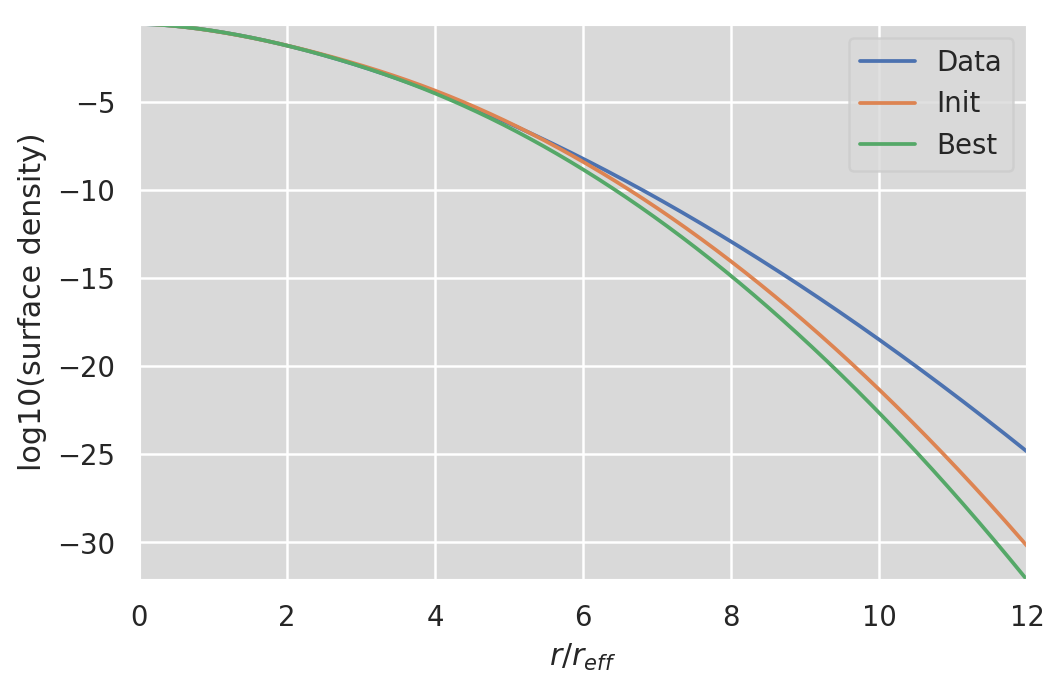

0.6 [1.18152162 0.89789169 0.5571245  0.26664192]
0.55 [1.09076081 0.88294585 0.55656225 0.26932096]
0.5 [1.    0.868 0.556 0.272]
Init  chisq = -7.506764435524934
ws, re: (array([0.5166862 , 0.4242236 , 0.05546332, 0.00362688]), array([1.16336946, 0.89490252, 0.55701205, 0.26717773]))
Optimization terminated successfully.
         Current function value: -10.408457
         Iterations: 11
         Function evaluations: 125
         Gradient evaluations: 25
-10.408456708462694 [0.15845908 2.029124   2.79352154]
n=0.59: (
    normalize(np.array([5.3953208499e-01, 4.0697128630e-01, 5.0411196453e-02, 3.0854322571e-03])),
    np.array([1.1633694600e+00, 8.9490252428e-01, 5.5701205446e-01, 2.6717773209e-01]),
),
Init  chisq = -7.456046884298334
ws, re: (array([0.53953208, 0.40697129, 0.0504112 , 0.00308543]), array([1.1452173 , 0.89191335, 0.5568996 , 0.26771354]))
Optimization terminated successfully.
         Current function value: -10.276589
         Iterations: 9
         Function eval

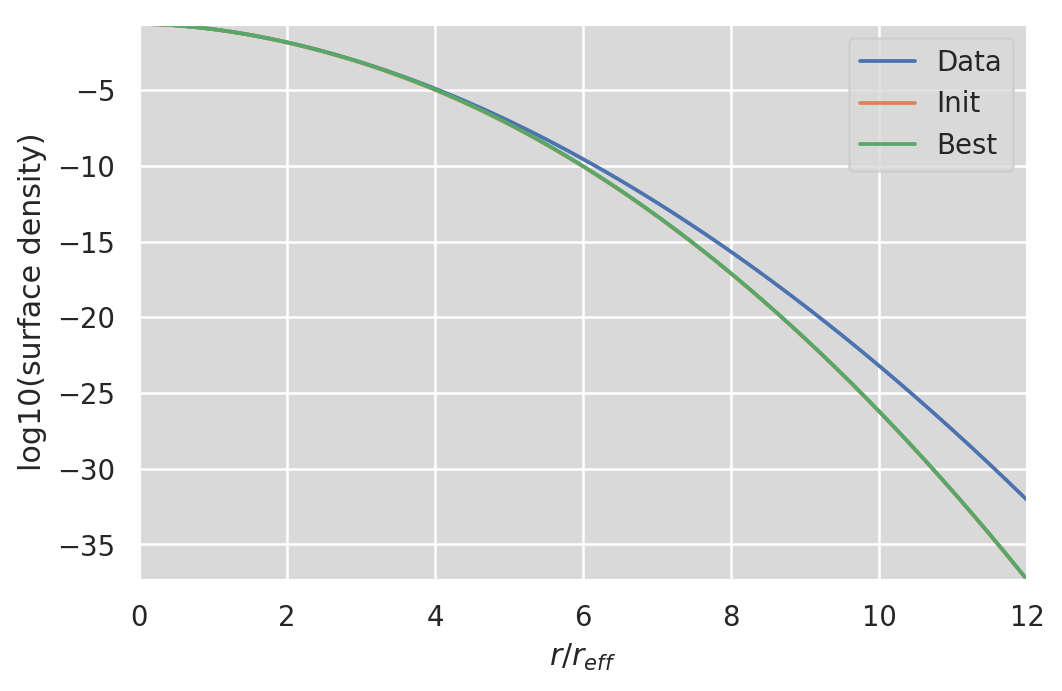

Init  chisq = -7.8280794721730285
ws, re: (array([0.66644386, 0.30326738, 0.02901733, 0.00127144]), array([1.08168473, 0.88145126, 0.55650603, 0.26958887]))
Optimization terminated successfully.
         Current function value: -9.995680
         Iterations: 12
         Function evaluations: 110
         Gradient evaluations: 22
-9.99567991326431 [0.79087008 2.34427711 3.18053915]
n=0.545: (
    normalize(np.array([6.8801812381e-01, 2.8467668137e-01, 2.6215589953e-02, 1.0896048655e-03])),
    np.array([1.0816847300e+00, 8.8145126214e-01, 5.5650602723e-01, 2.6958886605e-01]),
),
Init  chisq = -7.7944182765523315
ws, re: (array([0.68801812, 0.28467668, 0.02621559, 0.0010896 ]), array([1.07260865, 0.87995668, 0.5564498 , 0.26985677]))
         Current function value: -10.012424
         Iterations: 9
         Function evaluations: 283
         Gradient evaluations: 55
-10.012424265552902 [0.90206114 2.38641079 3.23678123]
n=0.54: (
    normalize(np.array([7.1137288409e-01, 2.6432043281e-0

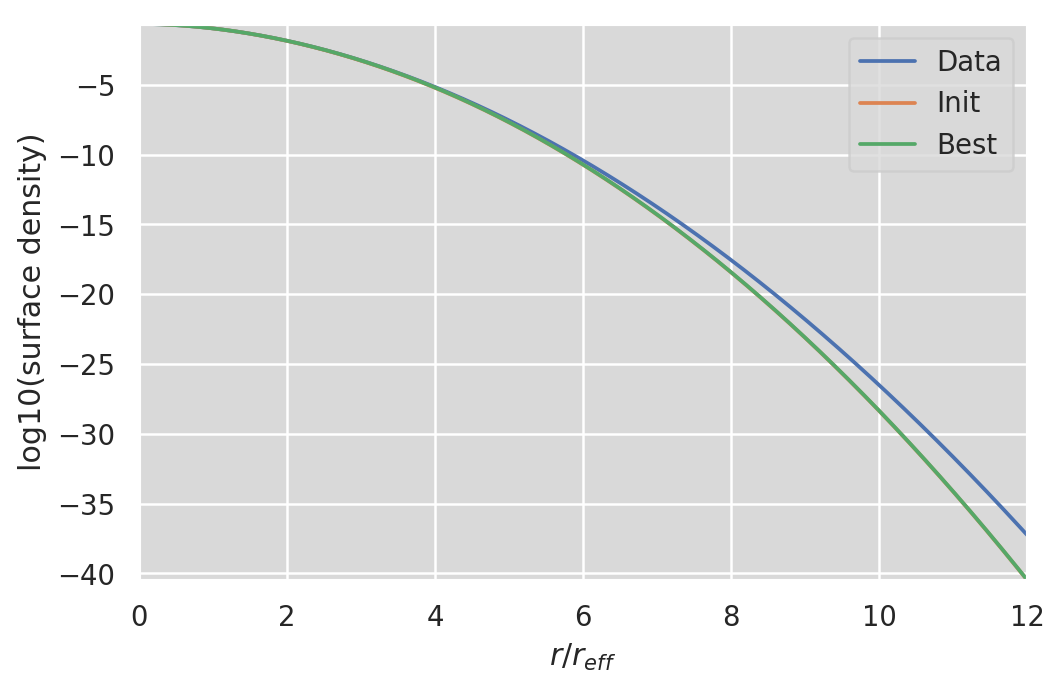

Init  chisq = -7.646393191122449
ws, re: (array([7.94554977e-01, 1.90208158e-01, 1.47594953e-02, 4.77368987e-04]), array([1.03630432, 0.87397834, 0.5562249 , 0.27092838]))
Optimization terminated successfully.
         Current function value: -10.315558
         Iterations: 11
         Function evaluations: 105
         Gradient evaluations: 21
-10.315558184280908 [1.56938599 2.57482776 3.50717793]
n=0.52: (
    normalize(np.array([8.2769605865e-01, 1.6010893375e-01, 1.1840026965e-02, 3.5498064219e-04])),
    np.array([1.0363043244e+00, 8.7397833873e-01, 5.5622490099e-01, 2.7092838491e-01]),
),
Init  chisq = -8.401882019528868
ws, re: (array([8.27696059e-01, 1.60108934e-01, 1.18400270e-02, 3.54980642e-04]), array([1.03267389, 0.8733805 , 0.55620241, 0.27103555]))
Optimization terminated successfully.
         Current function value: -10.380260
         Iterations: 7
         Function evaluations: 80
         Gradient evaluations: 16
-10.380259790179087 [1.67222248 2.59570062 3.53943965

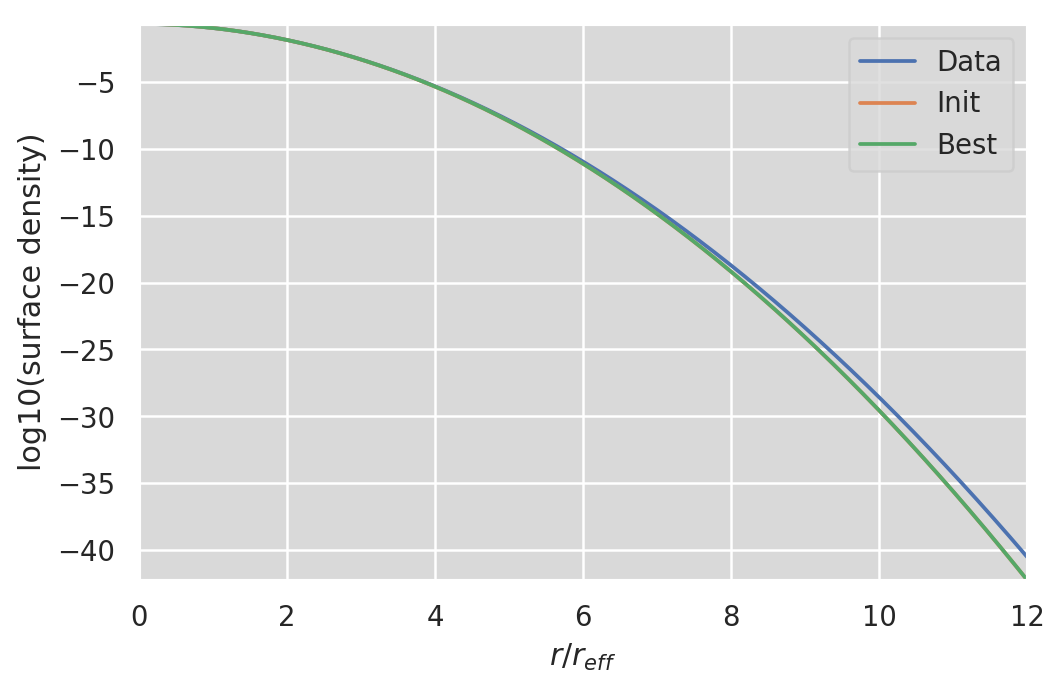

Init  chisq = -8.334527069228711
ws, re: (array([8.87972052e-01, 1.04710434e-01, 7.13104246e-03, 1.86471711e-04]), array([1.01815216, 0.87098917, 0.55611245, 0.27146419]))
Optimization terminated successfully.
         Current function value: -10.788006
         Iterations: 10
         Function evaluations: 90
         Gradient evaluations: 18
-10.788006397885551 [2.25004202 2.68359745 3.68167737]
n=0.51: (
    normalize(np.array([9.0465415940e-01, 8.9248645803e-02, 5.9474342283e-03, 1.4976056908e-04])),
    np.array([1.0181521622e+00, 8.7098916936e-01, 5.5611245050e-01, 2.7146419246e-01]),
),
Init  chisq = -8.916353704720438
ws, re: (array([9.04654159e-01, 8.92486458e-02, 5.94743423e-03, 1.49760569e-04]), array([1.01633695, 0.87069025, 0.55610121, 0.27151777]))
Optimization terminated successfully.
         Current function value: -10.867135
         Iterations: 13
         Function evaluations: 115
         Gradient evaluations: 23
-10.867135476547118 [2.35417227 2.69511588 3.7011722

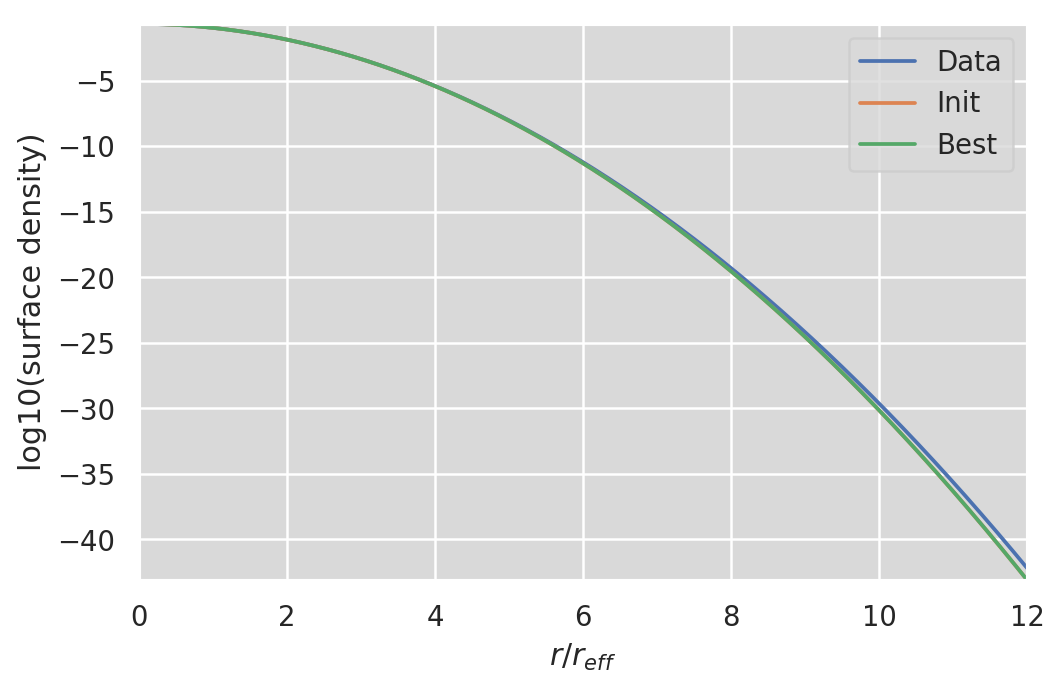

Init  chisq = -8.881630382188565
ws, re: (array([9.40249574e-01, 5.60936409e-02, 3.57376951e-03, 8.30159909e-05]), array([1.00907608, 0.86949458, 0.55605623, 0.2717321 ]))
Optimization terminated successfully.
         Current function value: -11.329080
         Iterations: 19
         Function evaluations: 275
         Gradient evaluations: 55
-11.32907967716297 [2.93707563 2.74247555 3.78371394]
n=0.505: (
    normalize(np.array([9.4964907955e-01, 4.7304034601e-02, 2.9791457766e-03, 6.7740074277e-05])),
    np.array([1.0090760811e+00, 8.6949458468e-01, 5.5605622525e-01, 2.7173209623e-01]),
),
Init  chisq = -8.872419815363463
ws, re: (array([9.49649080e-01, 4.73040346e-02, 2.97914578e-03, 6.77400743e-05]), array([1.00726086, 0.86919567, 0.55604498, 0.27178568]))
         Current function value: -11.510976
         Iterations: 13
         Function evaluations: 354
         Gradient evaluations: 69
-11.510975992135794 [3.15900799 2.75465164 3.80557106]
n=0.504: (
    normalize(np.array(

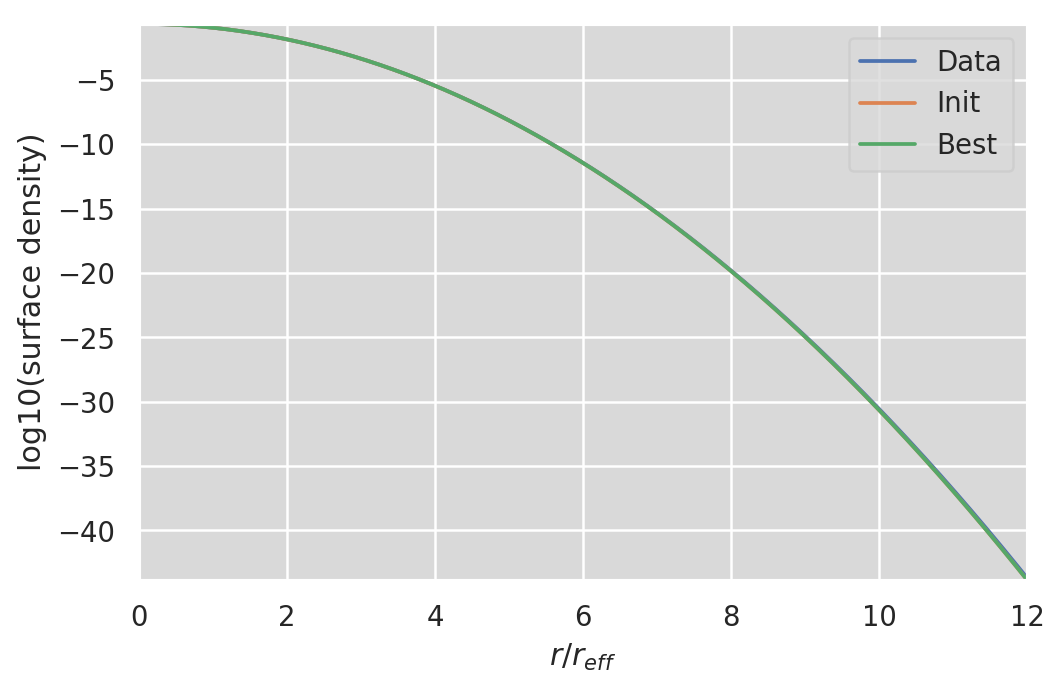

Init  chisq = -8.833303466127767
ws, re: (array([9.89457003e-01, 9.93407004e-03, 5.96542565e-04, 1.23847568e-05]), array([1.   , 0.868, 0.556, 0.272]))
Optimization terminated successfully.
         Current function value: -24.621656
         Iterations: 1
         Function evaluations: 20
         Gradient evaluations: 4
-24.62165647646808 [22.58978107  5.32230567  3.8842146 ]
n=0.5: (
    normalize(np.array([9.9999999985e-01, 1.5391030589e-10, 7.3617232424e-13, 1.5099033135e-14])),
    np.array([1.0000000000e+00, 8.6800000000e-01, 5.5600000000e-01, 2.7200000000e-01]),
),


In [10]:
# Fit for n < 1. Use a fixed radius for n<0.6
nvals = [
    (
        np.array([
            0.975, 0.95, 0.925, 0.9, 0.875, 0.85, 0.825, 0.8,
            0.775, 0.75, 0.725, 0.7, 0.675, 0.65, 0.625, 0.6,
        ]),
        (
    normalize(np.array([3.2466847784e-01, 4.7803210251e-01, 1.7258586760e-01, 2.4713552046e-02])),
    np.array([1.7007792632e+00, 9.7809127671e-01, 5.1487137336e-01, 2.1966932363e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], plotnth=4)

def radiuslogextrapmgfour(n):
    return np.log10(np.array([1.0, 0.868, 0.556, 0.272]) + 10*(n-0.5)*(
        np.array([1.1815216222e+00, 8.9789169364e-01, 5.5712450495e-01, 2.6664192455e-01]) -
        np.array([1.0, 0.868, 0.556, 0.272])))

for n in [0.6, 0.55, 0.5]:
    print(n, 10**radiuslogextrapmgfour(n))
    
nvals = [
    (
        np.array([
            0.59, 0.58, 0.57, 0.56, 0.55, 0.545, 0.54, 0.535, 0.53,
            0.525, 0.52, 0.518, 0.516, 0.514, 0.512, 0.51, 0.509,
            0.508, 0.507, 0.506, 0.505, 0.504, 0.503, 0.502, 0.501, 0.5
        ]),
        (
            normalize(
                np.array([5.1668620161e-01, 4.2422360341e-01, 5.5463315784e-02, 3.6268791954e-03])),
            np.array([1.1815216222e+00, 8.9789169364e-01, 5.5712450495e-01, 2.6664192455e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], funcrdivreslog=radiuslogextrapmgfour, plotnth=5)

[0, 24000]
0.9999999914677243 1.0000000256336785
Init  chisq = -8.000517405216014
ws, re: (array([0.32466848, 0.4780321 , 0.17258587, 0.02471355]), array([1.70077926, 0.97809128, 0.51487137, 0.21966932]))
         Current function value: -8.000517
         Iterations: 6
         Function evaluations: 496
         Gradient evaluations: 54
-8.000517405221363 [-0.73239907  0.88495522  1.94354295  0.23064793 -0.00962061 -0.28830122
 -0.65823056]
0.9999999914677243 1.0000000256336792
n=1.0: (
    normalize(np.array([3.2466848833e-01, 4.7803206711e-01, 1.7258588535e-01, 2.4713559210e-02])),
    np.array([1.7007791901e+00, 9.7809128350e-01, 5.1487140942e-01, 2.1966933602e-01]),
),


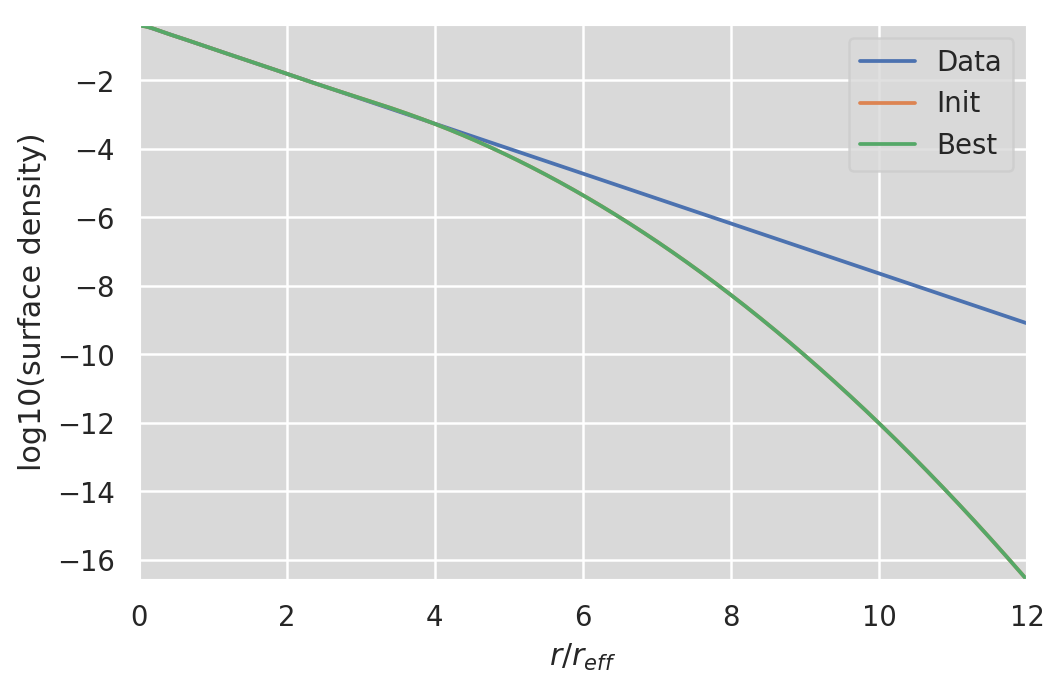

[0, 24000]
Init  chisq = -7.530298824108015
ws, re: (array([0.32466849, 0.47803207, 0.17258589, 0.02471356]), array([1.70077919, 0.97809128, 0.51487141, 0.21966934]))
         Current function value: -7.927960
         Iterations: 12
         Function evaluations: 804
         Gradient evaluations: 88
-7.9279595930089 [-0.7417069   0.85956674  1.91675568  0.23735186 -0.00839656 -0.29088243
 -0.66393327]
n=1.025: (
    normalize(np.array([3.2263100428e-01, 4.7589922000e-01, 1.7563655804e-01, 2.5833217683e-02])),
    np.array([1.7272366999e+00, 9.8085191356e-01, 5.1182037804e-01, 2.1680372209e-01]),
),
[0, 24000]
Init  chisq = -7.512880520474455
ws, re: (array([0.322631  , 0.47589922, 0.17563656, 0.02583322]), array([1.7272367 , 0.98085191, 0.51182038, 0.21680372]))
Optimization terminated successfully.
         Current function value: -7.859156
         Iterations: 17
         Function evaluations: 234
         Gradient evaluations: 26
-7.859155906649445 [-0.74963572  0.83594953  1.8914

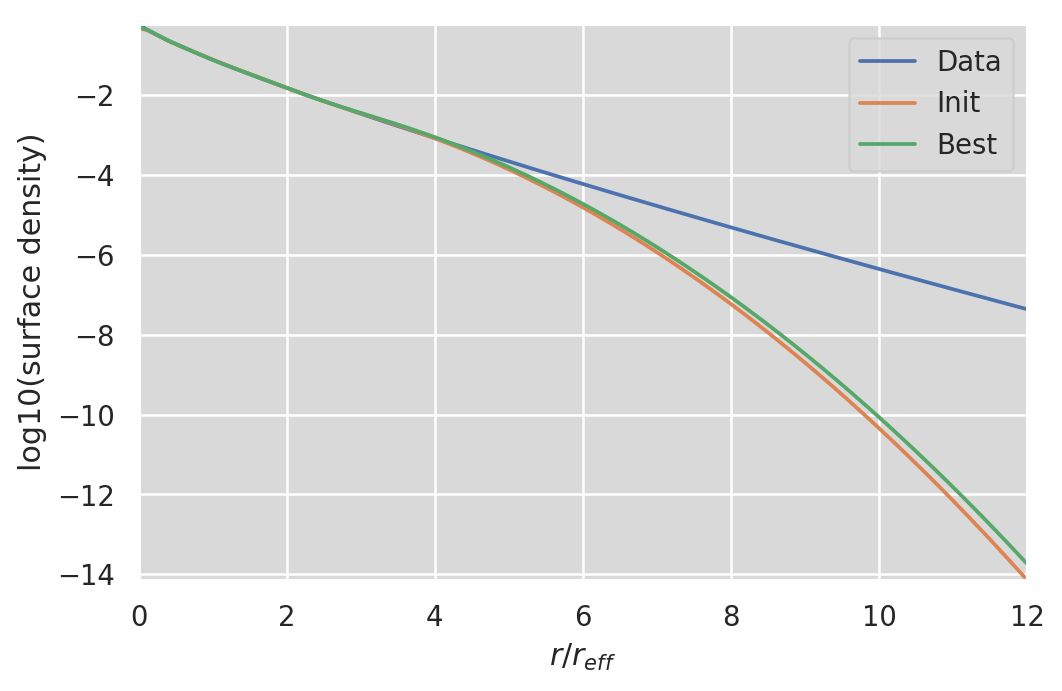

[1, 24000]
Init  chisq = -7.326129344130349
ws, re: (array([0.31519206, 0.46105962, 0.19101501, 0.03273331]), array([1.89847144, 0.99502367, 0.49057128, 0.19805003]))
         Current function value: -7.459697
         Iterations: 13
         Function evaluations: 694
         Gradient evaluations: 76
-7.459696578403017 [-7.77733683e-01  7.07926591e-01  1.74607614e+00  2.83551899e-01
 -1.56582054e-03 -3.11965596e-01 -7.08732994e-01]
n=1.225: (
    normalize(np.array([3.1480853466e-01, 4.5903912334e-01, 1.9255904102e-01, 3.3593300986e-02])),
    np.array([1.9211085247e+00, 9.9640105674e-01, 4.8756711263e-01, 1.9555413609e-01]),
),
[1, 24000]
Init  chisq = -7.294549248595064
ws, re: (array([0.31480853, 0.45903912, 0.19255904, 0.0335933 ]), array([1.92110852, 0.99640106, 0.48756711, 0.19555414]))
         Current function value: -7.411910
         Iterations: 12
         Function evaluations: 605
         Gradient evaluations: 66
-7.411909609774744 [-7.78957628e-01  6.93692713e-01  1.7289

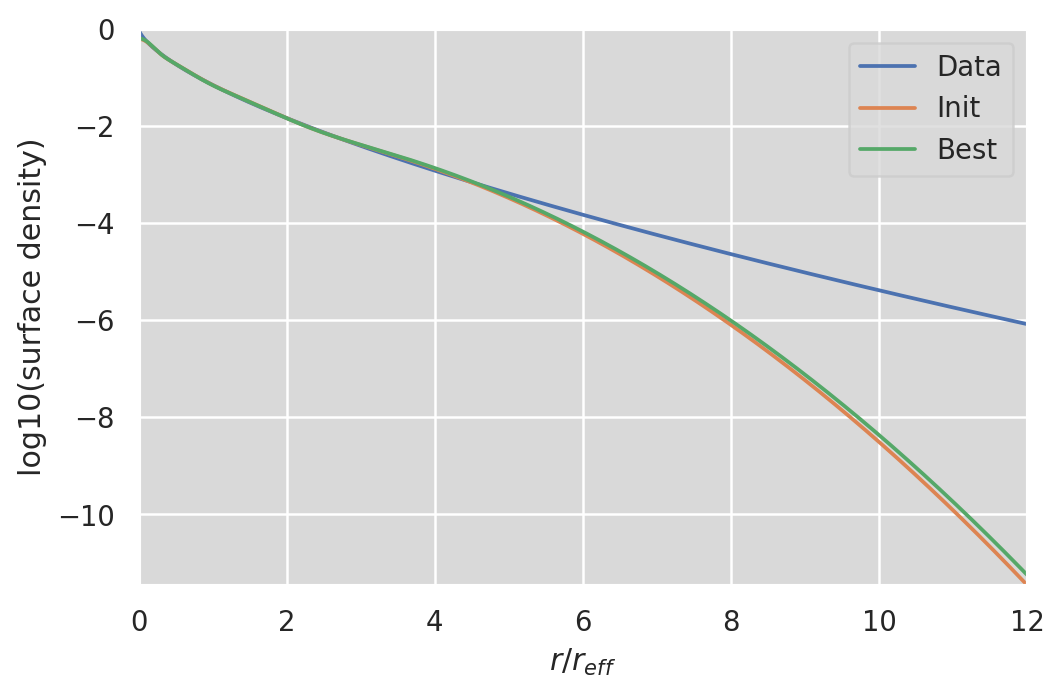

[5, 24000]
Init  chisq = -6.843696615553129
ws, re: (array([0.31644188, 0.43919489, 0.20304305, 0.04132018]), array([2.14415875, 1.00314071, 0.45529972, 0.1708039 ]))
Optimization terminated successfully.
         Current function value: -6.955368
         Iterations: 12
         Function evaluations: 162
         Gradient evaluations: 18
-6.9553679630885235 [-7.65333230e-01  5.70477214e-01  1.57042417e+00  3.38460383e-01
  1.27991712e-03 -3.47170611e-01 -7.77844730e-01]
n=1.55: (
    normalize(np.array([3.1748948574e-01, 4.3603773260e-01, 2.0404103045e-01, 4.2431751204e-02])),
    np.array([2.1800195227e+00, 1.0029514651e+00, 4.4960319476e-01, 1.6678433983e-01]),
),
[6, 24000]
Init  chisq = -6.801482968919745
ws, re: (array([0.31748949, 0.43603773, 0.20404103, 0.04243175]), array([2.18001952, 1.00295147, 0.44960319, 0.16678434]))
         Current function value: -6.895078
         Iterations: 10
         Function evaluations: 605
         Gradient evaluations: 66
-6.895077586996232 [-

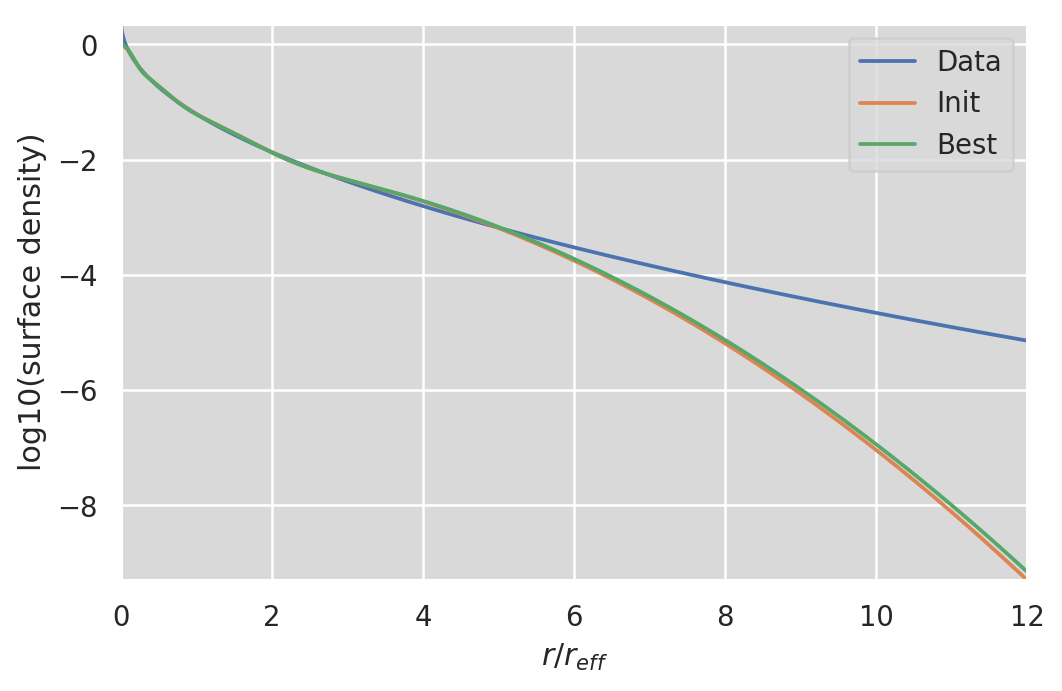

[18, 24000]
Init  chisq = -6.454298372113142
ws, re: (array([0.33128689, 0.412422  , 0.20667663, 0.04961448]), array([2.44655359, 0.98711505, 0.40106993, 0.13599711]))
Optimization terminated successfully.
         Current function value: -6.478988
         Iterations: 12
         Function evaluations: 162
         Gradient evaluations: 18
-6.478988353780478 [-0.69452737  0.46857225  1.41463736  0.39279989 -0.00690788 -0.40222213
 -0.87567975]
n=2.05: (
    normalize(np.array([3.3302669579e-01, 4.1021911004e-01, 2.0655781123e-01, 5.0196382943e-02])),
    np.array([2.4705855206e+00, 9.8421984046e-01, 3.9607539924e-01, 1.3314358517e-01]),
),
[19, 24000]
Init  chisq = -6.421441613401786
ws, re: (array([0.3330267 , 0.41021911, 0.20655781, 0.05019638]), array([2.47058552, 0.98421984, 0.3960754 , 0.13314359]))
Optimization terminated successfully.
         Current function value: -6.443364
         Iterations: 13
         Function evaluations: 171
         Gradient evaluations: 19
-6.4433635

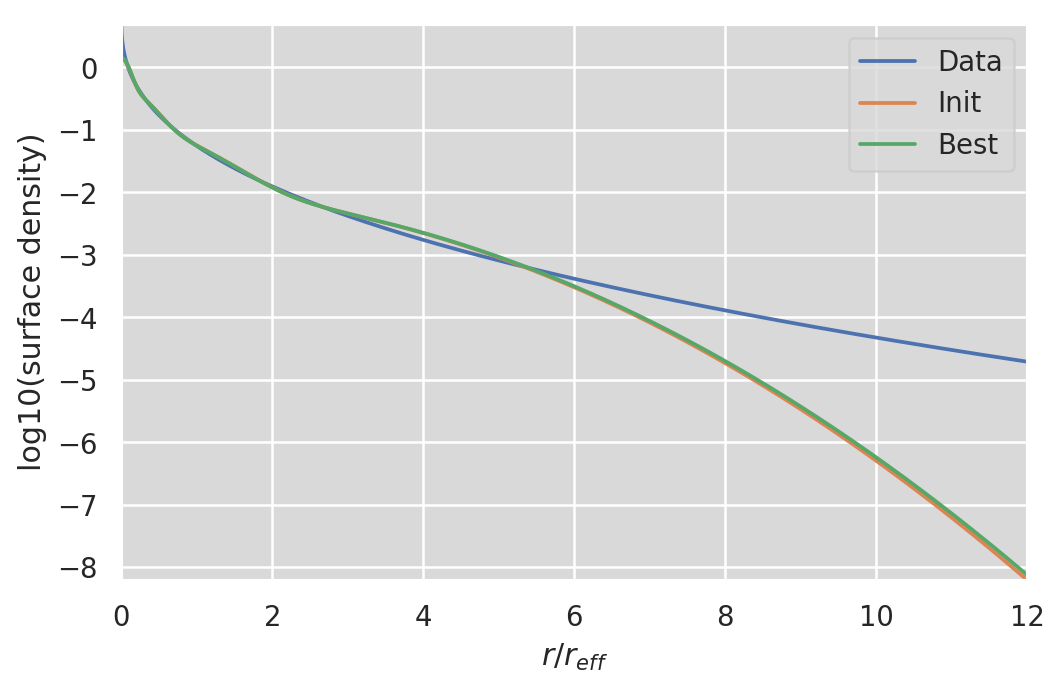

[37, 24000]
Init  chisq = -6.199611424598677
ws, re: (array([0.34743054, 0.39297759, 0.20471669, 0.05487518]), array([2.65199815, 0.95559218, 0.3567605 , 0.11252625]))
Optimization terminated successfully.
         Current function value: -6.208388
         Iterations: 10
         Function evaluations: 144
         Gradient evaluations: 16
-6.208387602925502 [-0.62467794  0.40880176  1.30584798  0.42644351 -0.02104356 -0.45197752
 -0.955335  ]
n=2.55: (
    normalize(np.array([3.4871827561e-01, 3.9129040446e-01, 2.0456573161e-01, 5.5425588318e-02])),
    np.array([2.6695834972e+00, 9.5270059951e-01, 3.5320145174e-01, 1.1083195658e-01]),
),
[40, 24000]
Init  chisq = -6.18450972937799
ws, re: (array([0.34871828, 0.3912904 , 0.20456573, 0.05542559]), array([2.6695835 , 0.9527006 , 0.35320145, 0.11083196]))
Optimization terminated successfully.
         Current function value: -6.192388
         Iterations: 9
         Function evaluations: 144
         Gradient evaluations: 16
-6.192387777

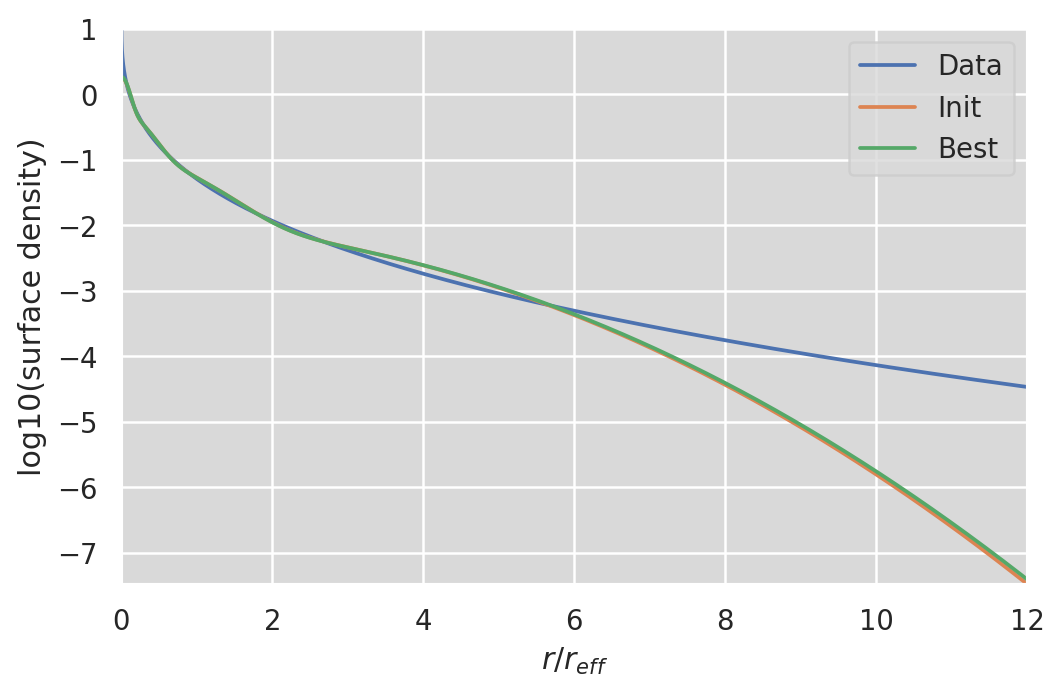

[63, 24000]
Init  chisq = -6.092016870142994
ws, re: (array([0.35433518, 0.37736731, 0.20582901, 0.0624685 ]), array([2.83361346, 0.94133631, 0.33284235, 0.10231204]))
Optimization terminated successfully.
         Current function value: -6.095927
         Iterations: 10
         Function evaluations: 144
         Gradient evaluations: 16
-6.0959265202716715 [-0.60037713  0.3316722   1.17778353  0.45542251 -0.02590906 -0.47894683
 -0.99105321]
n=3.05: (
    normalize(np.array([3.5425741621e-01, 3.7592950192e-01, 2.0628533347e-01, 6.3527748404e-02])),
    np.array([2.8537933042e+00, 9.4208685085e-01, 3.3193509656e-01, 1.0208144094e-01]),
),
[66, 24000]
Init  chisq = -6.0881026019250735
ws, re: (array([0.35425742, 0.3759295 , 0.20628533, 0.06352775]), array([2.8537933 , 0.94208685, 0.3319351 , 0.10208144]))
Optimization terminated successfully.
         Current function value: -6.091753
         Iterations: 11
         Function evaluations: 153
         Gradient evaluations: 17
-6.09175

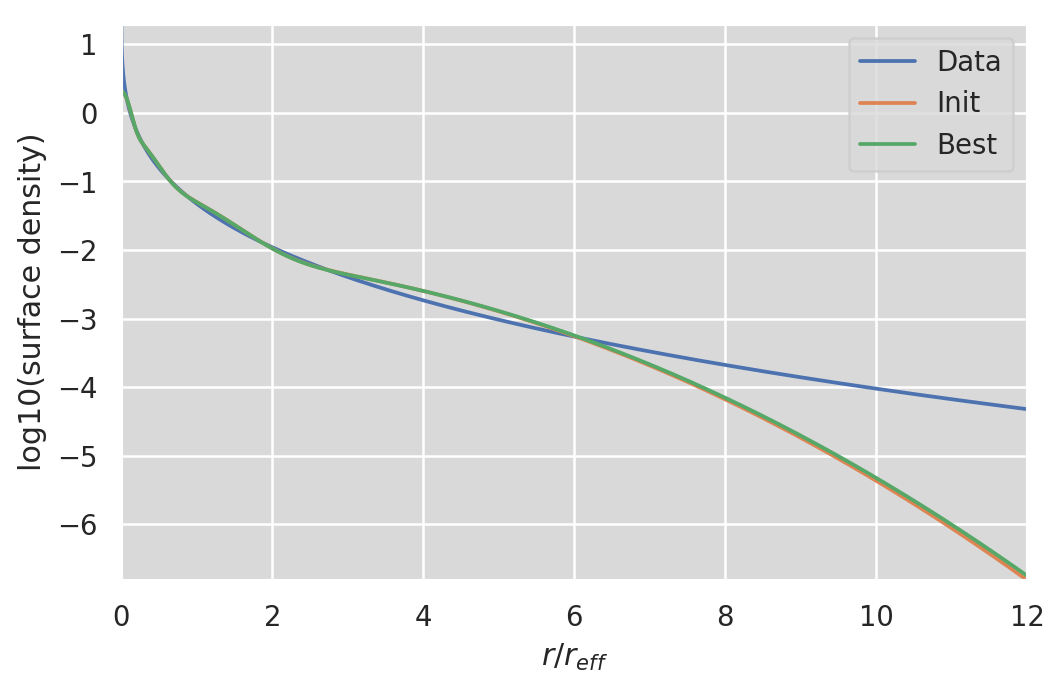

[92, 24000]
Init  chisq = -6.079378796332868
ws, re: (array([0.3506026 , 0.36392318, 0.21131413, 0.07416009]), array([3.04513807, 0.95950934, 0.33052313, 0.10311659]))
Optimization terminated successfully.
         Current function value: -6.081458
         Iterations: 11
         Function evaluations: 153
         Gradient evaluations: 17
-6.081457803143476 [-0.61956719  0.2324616   1.03269629  0.48684718 -0.01648865 -0.4800103
 -0.98476911]
n=3.55: (
    normalize(np.array([3.4987989294e-01, 3.6267281772e-01, 2.1197463864e-01, 7.5472650700e-02])),
    np.array([3.0679422536e+00, 9.6274517615e-01, 3.3112326760e-01, 1.0356926327e-01]),
),
[95, 24000]
Init  chisq = -6.081379433179568
ws, re: (array([0.34987989, 0.36267282, 0.21197464, 0.07547265]), array([3.06794225, 0.96274518, 0.33112327, 0.10356926]))
Optimization terminated successfully.
         Current function value: -6.083343
         Iterations: 11
         Function evaluations: 144
         Gradient evaluations: 16
-6.08334343

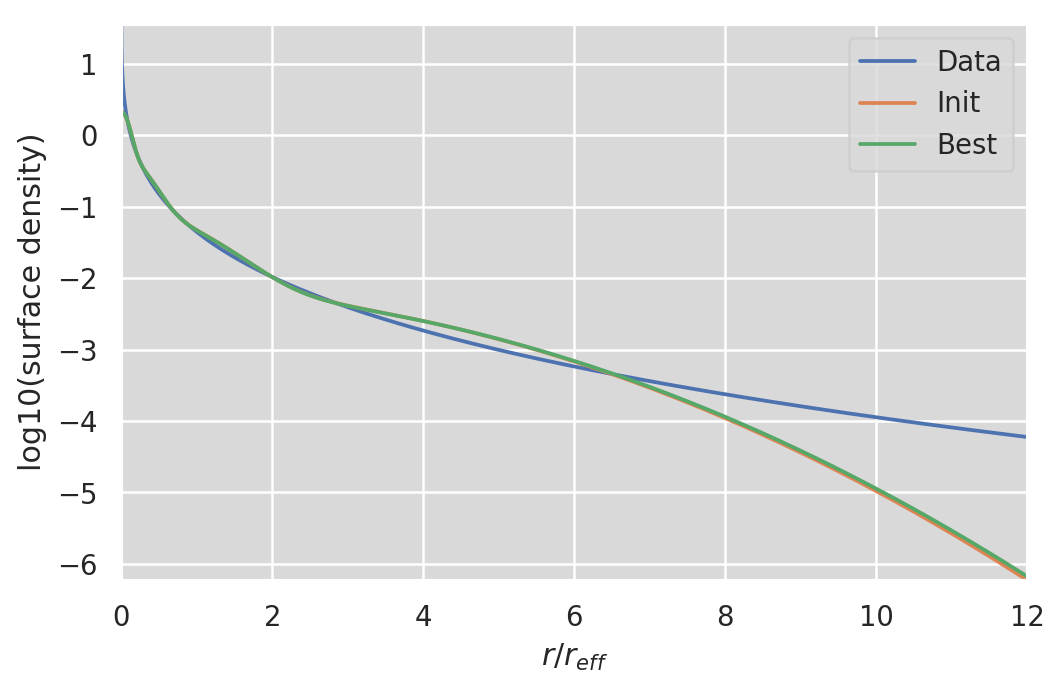

[126, 24000]
Init  chisq = -6.11938137335508
ws, re: (array([0.34184982, 0.35205844, 0.21817557, 0.08791617]), array([3.28415842, 1.00086524, 0.34144517, 0.10967508]))
Optimization terminated successfully.
         Current function value: -6.124167
         Iterations: 12
         Function evaluations: 153
         Gradient evaluations: 17
-6.124167135777596 [-0.66306586  0.12078384  0.88419638  0.52275762  0.00443349 -0.46308884
 -0.95384502]
n=4.1: (
    normalize(np.array([3.4005124441e-01, 3.4987797218e-01, 2.1943432111e-01, 9.0636462294e-02])),
    np.array([3.3324037854e+00, 1.0102607608e+00, 3.4427949461e-01, 1.1121285337e-01]),
),
[133, 24000]
Init  chisq = -6.133705054286801
ws, re: (array([0.34005124, 0.34987797, 0.21943432, 0.09063646]), array([3.33240379, 1.01026076, 0.34427949, 0.11121285]))
Optimization terminated successfully.
         Current function value: -6.138099
         Iterations: 13
         Function evaluations: 162
         Gradient evaluations: 18
-6.1380987

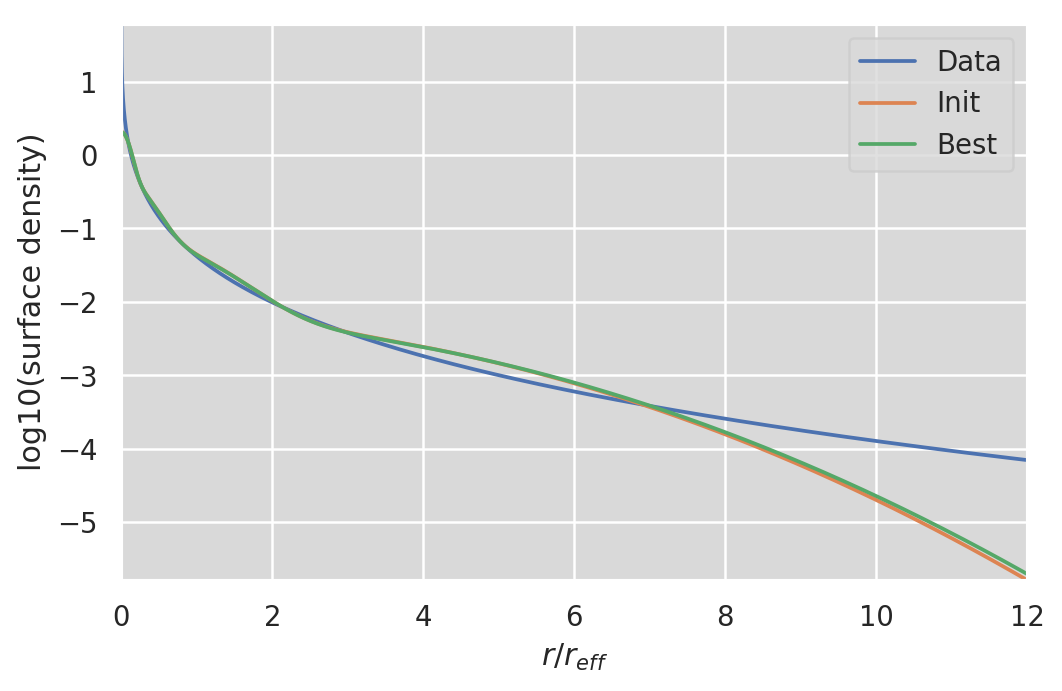

[157, 24000]
Init  chisq = -6.183649101550983
ws, re: (array([0.33249408, 0.34162359, 0.22429988, 0.10158245]), array([3.53067507, 1.05310837, 0.35840316, 0.11846251]))
Optimization terminated successfully.
         Current function value: -6.186732
         Iterations: 12
         Function evaluations: 162
         Gradient evaluations: 18
-6.186732236979678 [-0.70466334  0.03045442  0.77161869  0.55375991  0.02691354 -0.44123128
 -0.91979563]
n=4.6: (
    normalize(np.array([3.3077911837e-01, 3.3970522984e-01, 2.2534618004e-01, 1.0416947174e-01])),
    np.array([3.5789852986e+00, 1.0639311799e+00, 3.6205013836e-01, 1.2028303224e-01]),
),
[163, 24000]
Init  chisq = -6.197371892823368
ws, re: (array([0.33077912, 0.33970523, 0.22534618, 0.10416947]), array([3.5789853 , 1.06393118, 0.36205014, 0.12028303]))
Optimization terminated successfully.
         Current function value: -6.200223
         Iterations: 12
         Function evaluations: 162
         Gradient evaluations: 18
-6.200222

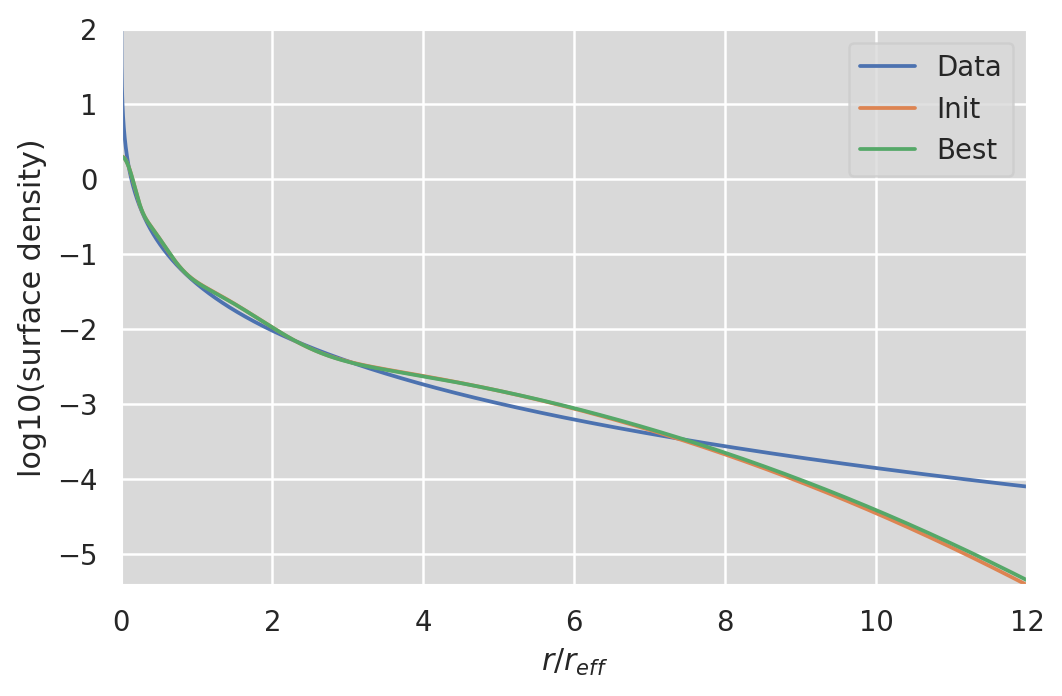

[185, 24000]
Init  chisq = -6.249630904817529
ws, re: (array([0.32469495, 0.33256656, 0.22889385, 0.11384465]), array([3.76509167, 1.10673301, 0.37668264, 0.12745437]))
Optimization terminated successfully.
         Current function value: -6.251657
         Iterations: 11
         Function evaluations: 162
         Gradient evaluations: 18
-6.251656691153456 [-0.73754772 -0.04308008  0.68278168  0.580627    0.04773573 -0.42041427
 -0.88947197]
n=5.1: (
    normalize(np.array([3.2354062177e-01, 3.3094533514e-01, 2.2954545295e-01, 1.1596859014e-01])),
    np.array([3.8073867607e+00, 1.1161838442e+00, 3.7982691135e-01, 1.2898167938e-01]),
),
[191, 24000]
Init  chisq = -6.264852754543693
ws, re: (array([0.32354062, 0.33094534, 0.22954545, 0.11596859]), array([3.80738676, 1.11618384, 0.37982691, 0.12898168]))
Optimization terminated successfully.
         Current function value: -6.266887
         Iterations: 11
         Function evaluations: 180
         Gradient evaluations: 20
-6.266887

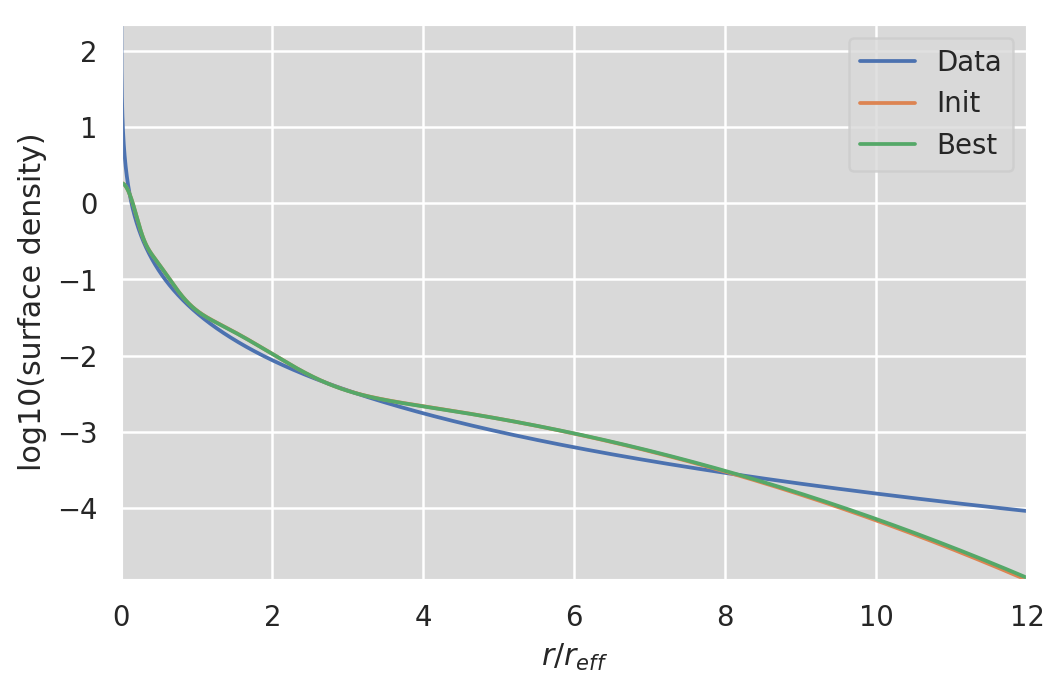

[228, 24000]
Init  chisq = -6.359497480107359
ws, re: (array([0.31633788, 0.3184192 , 0.23329982, 0.13194309]), array([4.14090572, 1.19140755, 0.40490227, 0.14097923]))
Optimization terminated successfully.
         Current function value: -6.361596
         Iterations: 13
         Function evaluations: 171
         Gradient evaluations: 19
-6.361595881971248 [-0.77223256 -0.14789453  0.55661637  0.62138923  0.07886177 -0.39034049
 -0.84766381]
n=6.15: (
    normalize(np.array([3.1599635761e-01, 3.1675771866e-01, 2.3344694903e-01, 1.3379897469e-01])),
    np.array([4.1820500797e+00, 1.1991175666e+00, 4.0706101419e-01, 1.4201564592e-01]),
),
[232, 24000]
Init  chisq = -6.370682050333252
ws, re: (array([0.31599636, 0.31675772, 0.23344695, 0.13379897]), array([4.18205008, 1.19911757, 0.40706101, 0.14201565]))
Optimization terminated successfully.
         Current function value: -6.372572
         Iterations: 13
         Function evaluations: 171
         Gradient evaluations: 19
-6.37257

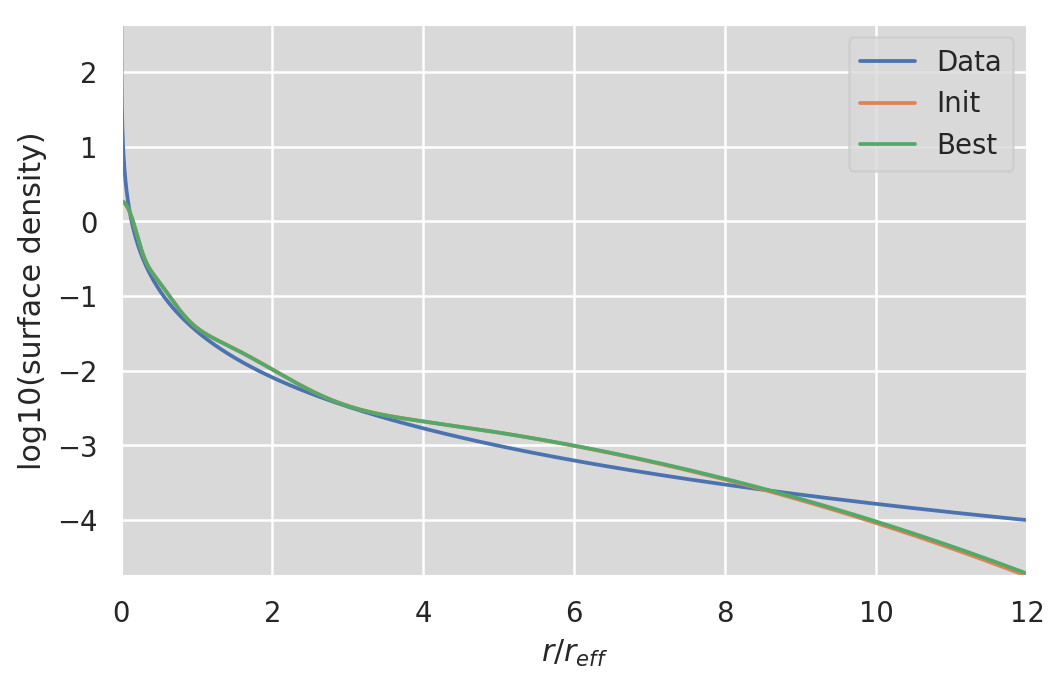

[239, 24000]
Init  chisq = -6.389015727121357
ws, re: (array([0.31673813, 0.30909602, 0.23288611, 0.14127973]), array([4.35290426, 1.22164221, 0.41056167, 0.14382226]))
Optimization terminated successfully.
         Current function value: -6.394317
         Iterations: 11
         Function evaluations: 153
         Gradient evaluations: 17
-6.394316753361686 [-0.76322719 -0.19770017  0.48919623  0.64135907  0.0860015  -0.38972407
 -0.84604537]
n=7.25: (
    normalize(np.array([3.1794601785e-01, 3.0742581612e-01, 2.3223839371e-01, 1.4238977233e-01])),
    np.array([4.3788399409e+00, 1.2189938031e+00, 4.0763919340e-01, 1.4254586811e-01]),
),
[236, 24000]
Init  chisq = -6.3804157162386215
ws, re: (array([0.31794602, 0.30742582, 0.23223839, 0.14238977]), array([4.37883994, 1.2189938 , 0.40763919, 0.14254587]))
Optimization terminated successfully.
         Current function value: -6.386779
         Iterations: 12
         Function evaluations: 162
         Gradient evaluations: 18
-6.3867

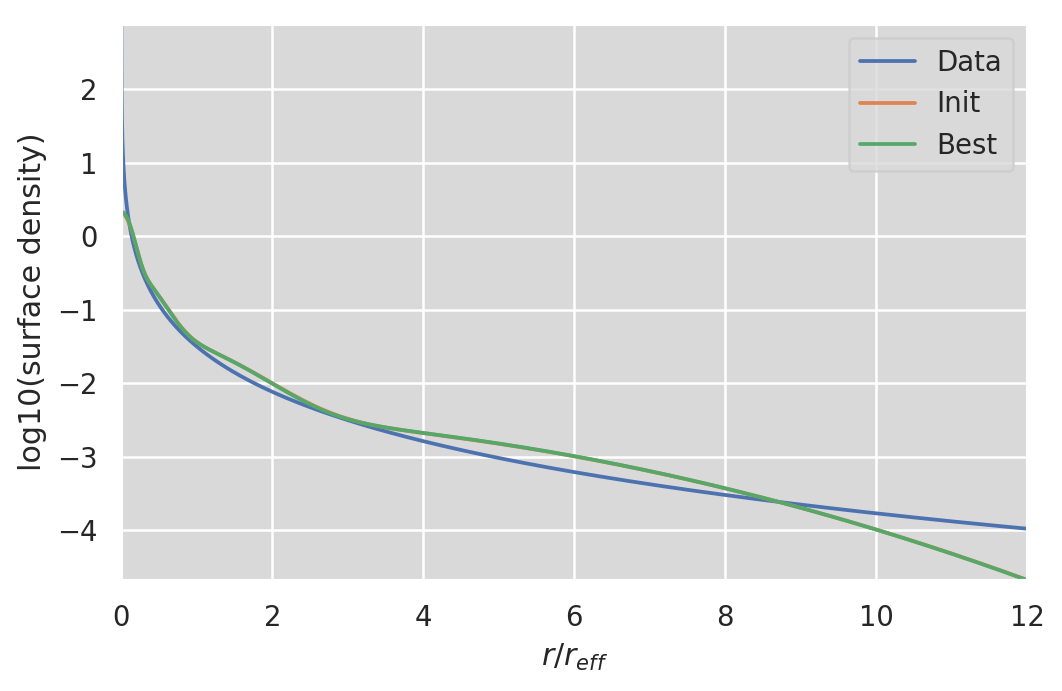

In [11]:
# Fit the softened Sersic from n=1 to n=8
nvals = [
    (
        np.array([
            1., 1.025, 1.05, 1.075, 1.10, 1.135, 1.165, 1.2, 1.225, 1.25, 1.275,
            1.3, 1.333, 1.367, 1.4, 1.433, 1.467, 1.5, 1.55, 1.6, 1.65, 1.7,
            1.75, 1.8, 1.85, 1.9 , 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3,
            2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9,
            2.95, 3., 3.05, 3.1, 3.15, 3.2, 3.25, 3.3, 3.35, 3.4, 3.45, 3.5,
            3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4., 4.1, 4.2,
            4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5., 5.1, 5.2, 5.3, 5.5, 5.5,
            5.6, 5.7, 5.8, 5.9, 6., 6.15, 6.3, 6.45, 6.6, 6.75, 7, 7.25, 7.5,
            7.75, 8,
        ]),
        (
            normalize(np.array([3.2466847784e-01, 4.7803210251e-01, 1.7258586760e-01, 2.4713552046e-02])),
            np.array([1.7007792632e+00, 9.7809127671e-01, 5.1487137336e-01, 2.1966932363e-01]),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], funcrangefit=funcrangefitn, plotnth=np.Inf, plotvals=[1., 1.2, 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 6., 7., 8.])

# To grep only the weights from the fit log:
# grep -C 2 normalize file.txt | grep [\(\)] | sed "s/n=//g"
# In reverse order add: | awk '{a[i++]=$0} END {for (j=i-1; j>=0;) { print a[j-3]; print a[j-2]; print a[j-1]; print a[j]; j-=4;}}'

## The graveyard of failed ideas

These are best-fit weights from the unsuccesful attempts - keeping both the weights and sizes free and either dropping components manually or keeping N=8 fixed and hoping for the best. We'll plot these up later along with the more successful fixed size below n=1 approach.

In [12]:
# Test out various spline weighting methods
# This first one is S-M-R-T I mean S-M-A-R-T
weightvarssmrtrev = {
    1.0: (
        normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01, 6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
        np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
    ),
    0.95: (
        normalize(np.array([8.1403269909e-02, 3.2580644822e-01, 3.4058504404e-01, 1.7513222856e-01, 5.9192552167e-02, 1.4829085839e-02, 2.7394820156e-03, 3.1188925295e-04])),
        np.array([2.0580646746e+00, 1.4290161052e+00, 9.7686981214e-01, 6.4569266618e-01, 4.0748443014e-01, 2.4091847021e-01, 1.2844509011e-01, 5.5475573206e-02]),
    ),
    0.9: (
        normalize(np.array([8.3272428552e-02, 3.3761909938e-01, 3.4261897732e-01, 1.6737529882e-01, 5.3685032163e-02, 1.2877296215e-02, 2.2983216755e-03, 2.5354586925e-04])),
        np.array([1.9527835416e+00, 1.3873099285e+00, 9.6414763955e-01, 6.4496927062e-01, 4.1081182437e-01, 2.4485938373e-01, 1.3161541508e-01, 5.7397686985e-02]),
    ),
    0.85: (
        normalize(np.array([8.8648139071e-02, 3.5515361752e-01, 3.4150494943e-01, 1.5534344140e-01, 4.6674515325e-02, 1.0649023584e-02, 1.8309459995e-03, 1.9536767345e-04])),
        np.array([1.8404078380e+00, 1.3380994716e+00, 9.4543542703e-01, 6.3983409725e-01, 4.1113219993e-01, 2.4697493906e-01, 1.3384622629e-01, 5.8963889270e-02]),
    ),
    0.8: (
        normalize(np.array([9.5687123517e-02, 3.7600373993e-01, 3.3791793777e-01, 1.4102874894e-01, 3.9315698812e-02, 8.4969058837e-03, 1.4050252856e-03, 1.4481985933e-04])),
        np.array([1.7282573092e+00, 1.2882067554e+00, 9.2633448695e-01, 6.3439449883e-01, 4.1120486913e-01, 2.4896361205e-01, 1.3607248303e-01, 6.0593077676e-02]),
    ),
    0.75: (
        normalize(np.array([1.0845562525e-01, 4.0294151495e-01, 3.2729844440e-01, 1.2246687144e-01, 3.1333936150e-02, 6.3893051250e-03, 1.0137209694e-03, 1.0058171985e-04])),
        np.array([1.6116987996e+00, 1.2333069456e+00, 9.0359039048e-01, 6.2645430811e-01, 4.0957694795e-01, 2.5288574221e-01, 1.3272691536e-01, 6.1993912159e-02]),
    ),
    0.7: (
        normalize(np.array([1.1584759935e-01, 4.4925832966e-01, 3.1925666847e-01, 9.4161947089e-02, 1.8473365773e-02, 2.7452558180e-03, 2.5683384766e-04, 0])),
        np.array([1.5085840400e+00, 1.1827064676e+00, 8.7020346704e-01, 5.9083650141e-01, 3.6842090584e-01, 2.0622530253e-01, 9.4309343285e-02, 6.3000000000e-02]),
    ),
    0.65: (
        normalize(np.array([2.6183027504e-01, 5.1131393105e-01, 1.8810590649e-01, 3.3865510527e-02, 4.4969433749e-03, 3.8743351832e-04, 0, 0])),
        np.array([1.3289631973e+00, 1.0385774455e+00, 7.3841834696e-01, 4.7109549871e-01, 2.6719483672e-01, 1.2384372936e-01, 3.0000000000e-02, -1]),
    ),
    0.60: (
        normalize(np.array([4.1546178873e-01, 4.7896375027e-01, 9.4459324448e-02, 1.0342408068e-02, 7.7272848509e-04, 0, 0, 0])),
        np.array([1.2056568803e+00, 9.5376794968e-01, 6.5169818599e-01, 3.7969948423e-01, 1.7909375620e-01, 4.0e-2, -1, -1]),
    ),
    #0.58: (
    #    normalize(np.array([4.5627440940e-01, 4.5801419853e-01, 7.7273178826e-02, 7.8676616590e-03, 5.7055159001e-04, 0, 0, 0])),
    #    np.array([1.1683467566e+00, 9.4363227290e-01, 6.5093086112e-01, 3.8085301923e-01, 1.8069824796e-01, -1, -1, -1]),
    #),
    0.56: (
        normalize(np.array([5.1383520859e-01, 4.2259270295e-01, 5.7812648759e-02, 5.3832054183e-03, 3.7623428159e-04, 0, 0, 0])),
        np.array([1.1295299365e+00, 9.3257427802e-01, 6.4722357532e-01, 3.7870305436e-01, 1.8038588490e-01, -1, -1, -1]),
    ),
    0.55: (
        normalize(np.array([5.5214529709e-01, 3.9529450455e-01, 4.7928536367e-02, 4.3319689703e-03, 2.9969302520e-04, 0, 0, 0])),
        np.array([1.1094018518e+00, 9.2705543556e-01, 6.4619989426e-01, 3.7926137736e-01, 1.8130968040e-01, -1, -1, -1]),
    ),
    0.54: (
        normalize(np.array([5.9919829101e-01, 3.5948801370e-01, 3.7771361281e-02, 3.3145069862e-03, 2.2782702383e-04, 0, 0, 0])),
        np.array([1.0888531764e+00, 9.2149653125e-01, 6.4439708848e-01, 3.7928399702e-01, 1.8209937478e-01, -1, -1, -1]),
    ),
    0.535: (
        normalize(np.array([6.3126439025e-01, 3.3392767586e-01, 3.1879935445e-02, 2.7407850764e-03, 1.8721337590e-04, 0, 0, 0])),
        np.array([1.0779584267e+00, 9.1705503997e-01, 6.4002041507e-01, 3.7627159296e-01, 1.8081161389e-01, -1, -1, -1]),
    ),
    0.515: (
        normalize(np.array([8.4097559276e-01, 1.5169627279e-01, 6.9714772900e-03, 3.5665715873e-04, 0, 0, 0, 0])),
        np.array([1.0309116597e+00, 8.7408078966e-01, 5.5036185175e-01, 2.6808638784e-01, 1.60e-01, -1, -1, -1]),
    ),
    0.507: (
        normalize(np.array([9.4662548327e-01, 5.2171305034e-02, 1.2032116992e-03, 0, 0, 0, 0, 0])),
        np.array([1.0122615136e+00, 8.2195507899e-01, 4.2112943705e-01, 1.5e-1, -1, -1, -1, -1]),
    ),
    0.501: (
        normalize(np.array([9.9645469317e-01, 3.5453068336e-03, 0, 0, 0, 0, 0, 0])),
        np.array([1.0012334877e+00, 7.1605157116e-01, 3.2e-1, -1, -1, -1, -1, -1]),
    ),
}
weightvarssmrt = {key: weightvarssmrtrev[key] for key in list(weightvarssmrtrev.keys())[::-1]}

weightvarslinrev = {
    1.0: (
        normalize(np.array([7.7900190678e-02, 3.1264016273e-01, 3.3937178782e-01, 1.8392530470e-01, 6.5418042323e-02, 1.7095071454e-02, 3.2661231097e-03, 3.8331719642e-04])),
        np.array([2.1704566125e+00, 1.4767913255e+00, 9.9494464239e-01, 6.5054022453e-01, 4.0699848261e-01, 2.3877605265e-01, 1.2631552536e-01, 5.4058147753e-02])
    ),
    0.995: (
        normalize(np.array([7.8446183932e-02, 3.1406434947e-01, 3.3932384870e-01, 1.8296223981e-01, 6.4764639051e-02, 1.6854415782e-02, 3.2090104756e-03, 3.7531277364e-04])),
        np.array([2.1583165776e+00, 1.4713798133e+00, 9.9276532523e-01, 6.4986444561e-01, 4.0693622906e-01, 2.3891710322e-01, 1.2647686885e-01, 5.4168977602e-02]),
    ),
    0.99: (
        normalize(np.array([7.8748882011e-02, 3.1527662000e-01, 3.3948179457e-01, 1.8216089349e-01, 6.4173199336e-02, 1.6633815653e-02, 3.1566703056e-03, 3.6812463680e-04])),
        np.array([2.1471476039e+00, 1.4667048040e+00, 9.9104503426e-01, 6.4944861490e-01, 4.0703634466e-01, 2.3916382111e-01, 1.2670689594e-01, 5.4317404722e-02]),
    ),
    0.985: (
        normalize(np.array([7.8994186452e-02, 3.1641620349e-01, 3.3968469926e-01, 1.8140525885e-01, 6.3605998603e-02, 1.6424599579e-02, 3.1076505756e-03, 3.6140318626e-04])),
        np.array([2.1362142657e+00, 1.4622314919e+00, 9.8948045158e-01, 6.4914027013e-01, 4.0722153691e-01, 2.3947910549e-01, 1.2698412679e-01, 5.4487684484e-02]),
    ),
    0.98: (
        normalize(np.array([7.8389101272e-02, 3.1638765311e-01, 3.4043547772e-01, 1.8156010509e-01, 6.3463387972e-02, 1.6329208096e-02, 3.0783508966e-03, 3.5671584639e-04])),
        np.array([2.1282781338e+00, 1.4604809912e+00, 9.9010354726e-01, 6.5040118063e-01, 4.0839544944e-01, 2.4033837843e-01, 1.2751651151e-01, 5.4759268657e-02]),
    ),
    0.975: (
        normalize(np.array([7.8492259575e-02, 3.1733990238e-01, 3.4064424822e-01, 1.8096336632e-01, 6.3017149586e-02, 1.6156519811e-02, 3.0357224100e-03, 3.5083170430e-04])),
        np.array([2.1178361862e+00, 1.4564466460e+00, 9.8896894906e-01, 6.5051832346e-01, 4.0890150279e-01, 2.4083944712e-01, 1.2788064118e-01, 5.4971854773e-02]),
    ),
    0.97: (
        normalize(np.array([7.8803523011e-02, 3.1858245887e-01, 3.4085154814e-01, 1.8013538246e-01, 6.2376851464e-02, 1.5922265126e-02, 2.9838701624e-03, 3.4410076591e-04])),
        np.array([2.1066586105e+00, 1.4517852082e+00, 9.8724682936e-01, 6.5003217856e-01, 4.0891261440e-01, 2.4105316221e-01, 1.2812638619e-01, 5.5135777007e-02]),
    ),
    0.965: (
        normalize(np.array([7.9652906813e-02, 3.2064939074e-01, 3.4068122966e-01, 1.7869038231e-01, 6.1466919163e-02, 1.5610725907e-02, 2.9134649523e-03, 3.3498045458e-04])),
        np.array([2.0937412212e+00, 1.4454149529e+00, 9.8410731982e-01, 6.4852336195e-01, 4.0824832753e-01, 2.4081266904e-01, 1.2808520606e-01, 5.5176596936e-02]),
    ),
    0.96: (
        normalize(np.array([8.0576453325e-02, 3.2290280030e-01, 3.4043969613e-01, 1.7709543098e-01, 6.0518663358e-02, 1.5295811356e-02, 2.8452778659e-03, 3.2586667691e-04])),
        np.array([2.0807024304e+00, 1.4388256059e+00, 9.8071976898e-01, 6.4685562505e-01, 4.0752304916e-01, 2.4056824190e-01, 1.2805531444e-01, 5.5198631668e-02]),
    ),
    0.955: (
        normalize(np.array([8.1040966768e-02, 3.2441065469e-01, 3.4047060583e-01, 1.7607117085e-01, 5.9838132967e-02, 1.5058095207e-02, 2.7915913744e-03, 3.1878231861e-04])),
        np.array([2.0692003931e+00, 1.4337627137e+00, 9.7867808047e-01, 6.4620077939e-01, 4.0746271722e-01, 2.4072384138e-01, 1.2824200177e-01, 5.5335703966e-02]),
    ),
    0.95: (
        normalize(np.array([8.1450263763e-02, 3.2585428363e-01, 3.4053884485e-01, 1.7509555332e-01, 5.9182670718e-02, 1.4827402200e-02, 2.7392015200e-03, 3.1177999432e-04])),
        np.array([2.0579132805e+00, 1.4288880244e+00, 9.7678450884e-01, 6.4564909129e-01, 4.0746517450e-01, 2.4090898319e-01, 1.2843833062e-01, 5.5469238331e-02]),
    ),
    0.945: (
        normalize(np.array([8.0838455136e-02, 3.2567038291e-01, 3.4122816179e-01, 1.7534334294e-01, 5.9123091044e-02, 1.4767026054e-02, 2.7206010931e-03, 3.0893902196e-04])),
        np.array([2.0497666873e+00, 1.4271898496e+00, 9.7773166817e-01, 6.4732448277e-01, 4.0900680557e-01, 2.4205144694e-01, 1.2917105921e-01, 5.5858036130e-02]),
    ),
    0.94: (
        normalize(np.array([8.1026477351e-02, 3.2706329786e-01, 3.4151639944e-01, 1.7442331104e-01, 5.8463968941e-02, 1.4536816076e-02, 2.6680176172e-03, 3.0171168430e-04])),
        np.array([2.0392493702e+00, 1.4227973744e+00, 9.7605089889e-01, 6.4682602711e-01, 4.0901861837e-01, 2.4223611781e-01, 1.2935204729e-01, 5.5949712693e-02]),
    ),
    0.935: (
        normalize(np.array([8.2608793996e-02, 3.3016404617e-01, 3.4076708635e-01, 1.7218633093e-01, 5.7242376406e-02, 1.4152019485e-02, 2.5875593775e-03, 2.9178728688e-04])),
        np.array([2.0244694038e+00, 1.4145791883e+00, 9.7135282044e-01, 6.4417273119e-01, 4.0759862723e-01, 2.4155666697e-01, 1.2909300116e-01, 5.5910480934e-02]),
    ),
    0.93: (
        normalize(np.array([8.3195200740e-02, 3.3186613072e-01, 3.4067638530e-01, 1.7101447113e-01, 5.6519105162e-02, 1.3909585516e-02, 2.5342509203e-03, 2.8487050914e-04])),
        np.array([2.0127911244e+00, 1.4093031664e+00, 9.6914649332e-01, 6.4340574832e-01, 4.0746787463e-01, 2.4166861403e-01, 1.2925452558e-01, 5.6035845282e-02]),
    ),
    0.925: (
        normalize(np.array([8.3674366070e-02, 3.3343562431e-01, 3.4065668849e-01, 1.6994391231e-01, 5.5845486169e-02, 1.3681528262e-02, 2.4840295930e-03, 2.7836479423e-04])),
        np.array([2.0014717439e+00, 1.4043554573e+00, 9.6720954231e-01, 6.4283853473e-01, 4.0746985897e-01, 2.4185994865e-01, 1.2946278551e-01, 5.6177545404e-02]),
    ),
    0.92: (
        normalize(np.array([8.4165170299e-02, 3.3507866152e-01, 3.4065328789e-01, 1.6882186325e-01, 5.5135004238e-02, 1.3442598166e-02, 2.4317766077e-03, 2.7163802453e-04])),
        np.array([1.9901688387e+00, 1.3993713671e+00, 9.6518979512e-01, 6.4215937706e-01, 4.0736856138e-01, 2.4197991939e-01, 1.2962814970e-01, 5.6303836333e-02]),
    ),
    0.915: (
        normalize(np.array([8.4685608679e-02, 3.3672835499e-01, 3.4059929447e-01, 1.6769223015e-01, 5.4437392947e-02, 1.3210544167e-02, 2.3813860072e-03, 2.6518858475e-04])),
        np.array([1.9788118069e+00, 1.3943611333e+00, 9.6319000742e-01, 6.4152969589e-01, 4.0731950121e-01, 2.4214060131e-01, 1.2982060137e-01, 5.6443069751e-02]),
    ),
    0.91: (
        normalize(np.array([8.4639795367e-02, 3.3751957246e-01, 3.4094265997e-01, 1.6721122181e-01, 5.4031664252e-02, 1.3051095694e-02, 2.3436897899e-03, 2.6030065902e-04])),
        np.array([1.9689949080e+00, 1.3909543026e+00, 9.6264069091e-01, 6.4202882897e-01, 4.0801749857e-01, 2.4272153789e-01, 1.3023886593e-01, 5.6700605787e-02]),
    ),
    0.905: (
        normalize(np.array([8.4882545997e-02, 3.3878250060e-01, 3.4107015969e-01, 1.6636706402e-01, 5.3473424762e-02, 1.2866379497e-02, 2.3030523605e-03, 2.5487306717e-04])),
        np.array([1.9584251136e+00, 1.3867269131e+00, 9.6135347483e-01, 6.4197487051e-01, 4.0840315874e-01, 2.4318356990e-01, 1.3059144846e-01, 5.6891288900e-02]),
    ),
    0.9: (
        normalize(np.array([8.5703533382e-02, 3.4065334348e-01, 3.4071270247e-01, 1.6506861300e-01, 5.2737930095e-02, 1.2623183173e-02, 2.2521101669e-03, 2.4858423528e-04])),
        np.array([1.9463115926e+00, 1.3811188552e+00, 9.5902935245e-01, 6.4120347915e-01, 4.0826152697e-01, 2.4327469001e-01, 1.3077386669e-01, 5.7023439004e-02]),
    ),
    0.895: (
        normalize(np.array([8.5458154254e-02, 3.4153725291e-01, 3.4124730054e-01, 1.6453481556e-01, 5.2292052730e-02, 1.2469800331e-02, 2.2166215828e-03, 2.4400209405e-04])),
        np.array([1.9371074385e+00, 1.3780162566e+00, 9.5852602244e-01, 6.4165221702e-01, 4.0896715012e-01, 2.4393075545e-01, 1.3122716473e-01, 5.7305327980e-02]),
    ),
    0.89: (
        normalize(np.array([8.6398784406e-02, 3.4354757875e-01, 3.4081871559e-01, 1.6310825490e-01, 5.1494849325e-02, 1.2226535299e-02, 2.1673987021e-03, 2.3788303682e-04])),
        np.array([1.9247374598e+00, 1.3721958904e+00, 9.5601456385e-01, 6.4070862543e-01, 4.0874741589e-01, 2.4404815862e-01, 1.3142123383e-01, 5.7439206885e-02]),
    ),
    0.885: (
        normalize(np.array([8.8084974452e-02, 3.4687678583e-01, 3.3974234955e-01, 1.6072365430e-01, 5.0357826877e-02, 1.1888425292e-02, 2.0968676722e-03, 2.2911603232e-04])),
        np.array([1.9107495015e+00, 1.3643739615e+00, 9.5155870963e-01, 6.3829809118e-01, 4.0754280841e-01, 2.4344962793e-01, 1.3115645104e-01, 5.7368724912e-02]),
    ),
    0.88: (
        normalize(np.array([8.8899905864e-02, 3.4930941617e-01, 3.3957451456e-01, 1.5902835784e-01, 4.9358164198e-02, 1.1574903093e-02, 2.0334713070e-03, 2.2126697580e-04])),
        np.array([1.8990323184e+00, 1.3586626362e+00, 9.4861408841e-01, 6.3663635565e-01, 4.0661138462e-01, 2.4301837033e-01, 1.3101853050e-01, 5.7351171024e-02]),
    ),
    0.875: (
        normalize(np.array([8.9719526602e-02, 3.5142926885e-01, 3.3921099318e-01, 1.5755096538e-01, 4.8559828433e-02, 1.1330575413e-02, 1.9836112558e-03, 2.1523089106e-04])),
        np.array([1.8873053597e+00, 1.3531714076e+00, 9.4618475353e-01, 6.3567468065e-01, 4.0634035820e-01, 2.4305266056e-01, 1.3115573412e-01, 5.7474898327e-02]),
    ),
    0.87: (
        normalize(np.array([9.0173794580e-02, 3.5305626695e-01, 3.3914329330e-01, 1.5644596456e-01, 4.7908336833e-02, 1.1122835888e-02, 1.9397900348e-03, 2.0971785200e-04])),
        np.array([1.8764623457e+00, 1.3486015892e+00, 9.4458175513e-01, 6.3533351247e-01, 4.0647054491e-01, 2.4331649981e-01, 1.3139635997e-01, 5.7635706855e-02]),
    ),
    0.865: (
        normalize(np.array([8.6135308911e-02, 3.4858939943e-01, 3.4264283849e-01, 1.5992557051e-01, 4.9119505662e-02, 1.1392673784e-02, 1.9814855129e-03, 2.1321770362e-04])),
        np.array([1.8758334412e+00, 1.3547119339e+00, 9.5267476966e-01, 6.4264507752e-01, 4.1193154065e-01, 2.4691539506e-01, 1.3345768182e-01, 5.8584360956e-02]),
    ),
    0.86: (
        normalize(np.array([9.1893982144e-02, 3.5743875849e-01, 3.3828758883e-01, 1.5339871037e-01, 4.6304149921e-02, 1.0638030221e-02, 1.8410136879e-03, 1.9776634136e-04])),
        np.array([1.8530985676e+00, 1.3376427022e+00, 9.3973559093e-01, 6.3340721094e-01, 4.0590116707e-01, 2.4333669448e-01, 1.3162266643e-01, 5.7855812756e-02]),
    ),
    0.855: (
        normalize(np.array([9.2992277469e-02, 3.5990991331e-01, 3.3765530445e-01, 1.5165710017e-01, 4.5423400347e-02, 1.0380318861e-02, 1.7900320433e-03, 1.9165335213e-04])),
        np.array([1.8409946339e+00, 1.3317269709e+00, 9.3692247592e-01, 6.3212525545e-01, 4.0539697018e-01, 2.4322591877e-01, 1.3167801519e-01, 5.7938070264e-02]),
    ),
    0.85: (
        normalize(np.array([9.3551835240e-02, 3.6171683549e-01, 3.3744731541e-01, 1.5042598438e-01, 4.4748981349e-02, 1.0174434506e-02, 1.7480670208e-03, 1.8654660696e-04])),
        np.array([1.8300927975e+00, 1.3270479040e+00, 9.3522659525e-01, 6.3172135114e-01, 4.0549331641e-01, 2.4347813221e-01, 1.3192705300e-01, 5.8109063390e-02]),
    ),
    0.845: (
        normalize(np.array([9.4731750777e-02, 3.6430995164e-01, 3.3671645683e-01, 1.4860049245e-01, 4.3850047871e-02, 9.9143886126e-03, 1.6965107346e-03, 1.8040108880e-04])),
        np.array([1.8179649453e+00, 1.3210617641e+00, 9.3233135201e-01, 6.3036021469e-01, 4.0491744109e-01, 2.4330219140e-01, 1.3193142574e-01, 5.8170286599e-02]),
    ),
    0.84: (
        normalize(np.array([9.5122647908e-02, 3.6533678581e-01, 3.3650928403e-01, 1.4793759852e-01, 4.3467857962e-02, 9.7821189569e-03, 1.6671110371e-03, 1.7659578290e-04])),
        np.array([1.8073505429e+00, 1.3171197157e+00, 9.3177524383e-01, 6.3114866788e-01, 4.0590965353e-01, 2.4408859743e-01, 1.3246051055e-01, 5.8456787024e-02]),
    ),
    0.835: (
        normalize(np.array([9.5834782385e-02, 3.6784648875e-01, 3.3617520517e-01, 1.4619396832e-01, 4.2608433822e-02, 9.5481482517e-03, 1.6218085387e-03, 1.7116476116e-04])),
        np.array([1.7963746527e+00, 1.3119553355e+00, 9.2929714792e-01, 6.2999245689e-01, 4.0554924245e-01, 2.4412492521e-01, 1.3258996701e-01, 5.8571667602e-02]),
    ),
    0.83: (
        normalize(np.array([9.3706282998e-02, 3.6637423180e-01, 3.3834636264e-01, 1.4744646464e-01, 4.2804929506e-02, 9.5404052669e-03, 1.6118076187e-03, 1.6951553096e-04])),
        np.array([1.7907364945e+00, 1.3129369052e+00, 9.3280845738e-01, 6.3356034322e-01, 4.0822237963e-01, 2.4587028939e-01, 1.3362304702e-01, 5.9102911016e-02]),
    ),
    0.825: (
        normalize(np.array([9.2297001446e-02, 3.6600259905e-01, 3.3965641123e-01, 1.4787374741e-01, 4.2861561834e-02, 9.5321025595e-03, 1.6078065254e-03, 1.6876994152e-04])),
        np.array([1.7836886015e+00, 1.3122326759e+00, 9.3479476154e-01, 6.3631626251e-01, 4.1077176020e-01, 2.4777027641e-01, 1.3485972685e-01, 5.9731274619e-02]),
    ),
    0.82: (
        normalize(np.array([9.3180282626e-02, 3.6811763616e-01, 3.3933878373e-01, 1.4640937999e-01, 4.1985647417e-02, 9.2541190957e-03, 1.5524119878e-03, 1.6173899923e-04])),
        np.array([1.7721042746e+00, 1.3070260264e+00, 9.3269249807e-01, 6.3532651585e-01, 4.1011161742e-01, 2.4738161812e-01, 1.3467701941e-01, 5.9650583683e-02]),
    ),
    0.815: (
        normalize(np.array([9.2986075986e-02, 3.6919597096e-01, 3.3957384478e-01, 1.4574471404e-01, 4.1643377952e-02, 9.1611137100e-03, 1.5347666747e-03, 1.6013589318e-04])),
        np.array([1.7626653685e+00, 1.3038273322e+00, 9.3249831233e-01, 6.3641114918e-01, 4.1155769995e-01, 2.4866489868e-01, 1.3561269169e-01, 6.0234252436e-02]),
    ),
    0.81: (
        normalize(np.array([9.3496877139e-02, 3.7079293837e-01, 3.3957644974e-01, 1.4461870966e-01, 4.0937308901e-02, 8.9361642321e-03, 1.4873009162e-03, 1.5425104311e-04])),
        np.array([1.7517805029e+00, 1.2994513277e+00, 9.3122215357e-01, 6.3615002551e-01, 4.1150826647e-01, 2.4866762093e-01, 1.3563143012e-01, 6.0257185067e-02]),
    ),
    0.805: (
        normalize(np.array([9.4984175915e-02, 3.7382216017e-01, 3.3840867268e-01, 1.4250803643e-01, 4.0003714523e-02, 8.6838919522e-03, 1.4403409377e-03, 1.4900740270e-04])),
        np.array([1.7392869304e+00, 1.2930701017e+00, 9.2809677491e-01, 6.3472324524e-01, 4.1093966321e-01, 2.4853669358e-01, 1.3569676159e-01, 6.0362472446e-02]),
    ),
    0.8: (
        normalize(np.array([9.6836231121e-02, 3.7727681530e-01, 3.3682465858e-01, 1.4006704302e-01, 3.9017221139e-02, 8.4382063067e-03, 1.3958748554e-03, 1.4394968957e-04])),
        np.array([1.7263009193e+00, 1.2860935640e+00, 9.2442985663e-01, 6.3297037972e-01, 4.1032016071e-01, 2.4846492746e-01, 1.3580925809e-01, 6.0469131878e-02]),
    ),
    0.795: (
        normalize(np.array([9.6701851660e-02, 3.7775593288e-01, 3.3721708716e-01, 1.3976531441e-01, 3.8716800257e-02, 8.3292769666e-03, 1.3729452437e-03, 1.4079142677e-04])),
        np.array([1.7165705709e+00, 1.2831981659e+00, 9.2490568253e-01, 6.3448077191e-01, 4.1175214370e-01, 2.4955174559e-01, 1.3652280891e-01, 6.0815609139e-02]),
    ),
    0.79: (
        normalize(np.array([9.6935742693e-02, 3.8045640176e-01, 3.3722974477e-01, 1.3803394867e-01, 3.7810059483e-02, 8.0746496081e-03, 1.3236059537e-03, 1.3584706299e-04])),
        np.array([1.7065860305e+00, 1.2787605978e+00, 9.2284976810e-01, 6.3336961499e-01, 4.1113759178e-01, 2.4928138733e-01, 1.3650620880e-01, 6.0972080268e-02]),
    ),
    0.785: (
        normalize(np.array([9.8498746886e-02, 3.8397960921e-01, 3.3599209206e-01, 1.3557464608e-01, 3.6753358837e-02, 7.7979178628e-03, 1.2737371447e-03, 1.2989192005e-04])),
        np.array([1.6943194094e+00, 1.2723379825e+00, 9.1935853572e-01, 6.3139622447e-01, 4.1009020341e-01, 2.4881406498e-01, 1.3633519253e-01, 6.0914160065e-02]),
    ),
    0.78: (
        normalize(np.array([9.7821878405e-02, 3.8379400176e-01, 3.3679316026e-01, 1.3578414590e-01, 3.6676404160e-02, 7.7432750138e-03, 1.2593888443e-03, 1.2774566208e-04])),
        np.array([1.6854023618e+00, 1.2704105395e+00, 9.2093649291e-01, 6.3399037683e-01, 4.1236890687e-01, 2.5041696980e-01, 1.3732200474e-01, 6.1389492454e-02]),
    ),
    0.775: (
        normalize(np.array([1.0085612617e-01, 3.8937597206e-01, 3.3402467920e-01, 1.3186996130e-01, 3.5171840923e-02, 7.3846843034e-03, 1.1958130782e-03, 1.2092296433e-04])),
        np.array([1.6711170558e+00, 1.2614102360e+00, 9.1478180751e-01, 6.2982178360e-01, 4.0987334369e-01, 2.4909551333e-01, 1.3668994631e-01, 6.1202392107e-02]),
    ),
    0.77: (
        normalize(np.array([1.0561164616e-01, 3.9432164079e-01, 3.2950201626e-01, 1.2824303600e-01, 3.3974147657e-02, 7.0893418712e-03, 1.1425345644e-03, 1.1563669175e-04])),
        np.array([1.6542660376e+00, 1.2508896293e+00, 9.0869515378e-01, 6.2670916526e-01, 4.0832326551e-01, 2.4828112562e-01, 1.3638748080e-01, 6.1174564404e-02]),
    ),
    0.765: (
        normalize(np.array([1.0356477902e-01, 3.9373390958e-01, 3.3172951533e-01, 1.2882909079e-01, 3.3872408453e-02, 7.0278507492e-03, 1.1289414713e-03, 1.1350460368e-04])),
        np.array([1.6474329143e+00, 1.2507804749e+00, 9.1137921434e-01, 6.2961070542e-01, 4.1056892504e-01, 2.4990318044e-01, 1.3739842554e-01, 6.1686401767e-02]),
    ),
    0.76: (
        normalize(np.array([1.0645891953e-01, 3.9790545178e-01, 3.2879949786e-01, 1.2590321348e-01, 3.2909050804e-02, 6.8186084872e-03, 1.0953246246e-03, 1.0993343910e-04])),
        np.array([1.6337355608e+00, 1.2429618207e+00, 9.0713841819e-01, 6.2773067633e-01, 4.1012586135e-01, 2.5010775541e-01, 1.3775887552e-01, 6.1986363244e-02]),
    ),
    0.755: (
        normalize(np.array([1.1165850374e-01, 4.0436610200e-01, 3.2389888747e-01, 1.2122762703e-01, 3.1291071025e-02, 6.4283046031e-03, 1.0266843152e-03, 1.0281982391e-04])),
        np.array([1.6172771202e+00, 1.2318818288e+00, 8.9941757207e-01, 6.2251999495e-01, 4.0679578857e-01, 2.4806595746e-01, 1.3670966135e-01, 6.1560345274e-02]),
    ),
    0.75: (
        normalize(np.array([1.1814600743e-01, 4.1250195292e-01, 3.1797300530e-01, 1.1529044862e-01, 2.9135074884e-02, 5.9212684740e-03, 9.3900666303e-04, 9.3235710220e-05])),
        np.array([1.5998572704e+00, 1.2191174793e+00, 8.8927075077e-01, 6.1449033889e-01, 4.0101199477e-01, 2.4443134582e-01, 1.3465365850e-01, 6.0605648890e-02]),
    ),
    0.745: (
        normalize(np.array([1.1220380065e-01, 4.0879299668e-01, 3.2389516490e-01, 1.1823883585e-01, 2.9771745251e-02, 6.0414430167e-03, 9.6049324377e-04, 9.5520400903e-05])),
        np.array([1.5974477477e+00, 1.2243329845e+00, 8.9722086673e-01, 6.2170854804e-01, 4.0655297986e-01, 2.4842485027e-01, 1.3726235224e-01, 6.1955367300e-02]),
    ),
    0.74: (
        normalize(np.array([1.0889321001e-01, 4.0682854520e-01, 3.2697244650e-01, 1.1993211972e-01, 3.0204361829e-02, 6.1072944966e-03, 9.6639292841e-04, 9.5629307263e-05])),
        np.array([1.5917384390e+00, 1.2258961440e+00, 9.0225800890e-01, 6.2737817919e-01, 4.1122927710e-01, 2.5160891993e-01, 1.3914638347e-01, 6.2855471404e-02]),
    ),
    0.735: (
        normalize(np.array([1.1059812198e-01, 4.1173500978e-01, 3.2541817231e-01, 1.1671848026e-01, 2.8799618698e-02, 5.7423239070e-03, 8.9987822051e-04, 8.8394840593e-05])),
        np.array([1.5802113148e+00, 1.2195354207e+00, 8.9797199025e-01, 6.2373147834e-01, 4.0816955796e-01, 2.4944619049e-01, 1.3786899064e-01, 6.2318660498e-02]),
    ),
    0.73: (
        normalize(np.array([1.0752992118e-01, 4.0995297373e-01, 3.2840263257e-01, 1.1822869594e-01, 2.9114420408e-02, 5.7807099738e-03, 9.0232262678e-04, 8.8323567377e-05])),
        np.array([1.5739483568e+00, 1.2206058678e+00, 9.0265800120e-01, 6.2904653840e-01, 4.1250680451e-01, 2.5242779324e-01, 1.3969035455e-01, 6.3226806799e-02]),
    ),
    0.725: (
        normalize(np.array([1.1724715070e-01, 4.1703470264e-01, 3.1925553681e-01, 1.1261889175e-01, 2.7494773760e-02, 5.4249787086e-03, 8.4190333184e-04, 8.2062305080e-05])),
        np.array([1.5528381162e+00, 1.2056768135e+00, 8.9290373420e-01, 6.2319598472e-01, 4.0903309515e-01, 2.5037933312e-01, 1.3859794849e-01, 6.2788228313e-02]),
    ),
    0.72: (
        normalize(np.array([1.1480505853e-01, 4.1910670741e-01, 3.2105449407e-01, 1.1174507134e-01, 2.7042127952e-02, 5.3364568378e-03, 8.2958466412e-04, 8.0499187063e-05])),
        np.array([1.5461383952e+00, 1.2046239181e+00, 8.9376979342e-01, 6.2446781488e-01, 4.1062102819e-01, 2.5200099947e-01, 1.3977738002e-01, 6.3400552105e-02]),
    ),
    0.715: (
        normalize(np.array([1.1913759597e-01, 4.2199448941e-01, 3.1686310296e-01, 1.0950159467e-01, 2.6432143660e-02, 5.1918842924e-03, 8.0186441486e-04, 7.7324621190e-05])),
        np.array([1.5316480903e+00, 1.1968723096e+00, 8.9081859415e-01, 6.2430759694e-01, 4.1132030866e-01, 2.5260980269e-01, 1.4014972277e-01, 6.3635264754e-02]),
    ),
    0.71: (
        normalize(np.array([1.2301766942e-01, 4.2820896393e-01, 3.1287069411e-01, 1.0528500320e-01, 2.4968196974e-02, 4.8354291996e-03, 7.4181036586e-04, 7.2232802591e-05])),
        np.array([1.5183545428e+00, 1.1885630512e+00, 8.8479628683e-01, 6.1959695114e-01, 4.0776068481e-01, 2.5016169561e-01, 1.3900549496e-01, 6.3386651622e-02]),
    ),
    0.705: (
        normalize(np.array([1.1886006954e-01, 4.2499223904e-01, 3.1709538718e-01, 1.0759839326e-01, 2.5601787660e-02, 5.0056392285e-03, 7.7234369868e-04, 7.4140385326e-05])),
        np.array([1.5124200602e+00, 1.1909233935e+00, 8.9156263955e-01, 6.2727144441e-01, 4.1473984317e-01, 2.5572401186e-01, 1.4235320956e-01, 6.4805197004e-02]),
    ),
    0.7: (
        normalize(np.array([1.1646435020e-01, 4.2739124945e-01, 3.1922751878e-01, 1.0653680383e-01, 2.4816881868e-02, 4.7669777519e-03, 7.2686739303e-04, 6.9350722705e-05])),
        np.array([1.5052384522e+00, 1.1895849021e+00, 8.9211604870e-01, 6.2729710480e-01, 4.1395531956e-01, 2.5476146085e-01, 1.4180217436e-01, 6.4647551382e-02]),
    ),
    0.695: (
        normalize(np.array([1.2076486484e-01, 4.3023678247e-01, 3.1458863276e-01, 1.0441083045e-01, 2.4479913142e-02, 4.7298126230e-03, 7.2047513089e-04, 6.8688591910e-05])),
        np.array([1.4911963653e+00, 1.1821964262e+00, 8.8974702402e-01, 6.2845456631e-01, 4.1662660699e-01, 2.5721844957e-01, 1.4339831189e-01, 6.5541865144e-02]),
    ),
    0.69: (
        normalize(np.array([1.3370275577e-01, 4.4333808357e-01, 3.0162427747e-01, 9.4924949088e-02, 2.1603363948e-02, 4.1194724570e-03, 6.2736993586e-04, 5.9727764463e-05])),
        np.array([1.4706442737e+00, 1.1645040148e+00, 8.7345015979e-01, 6.1438878319e-01, 4.0606497740e-01, 2.5050182785e-01, 1.3987649033e-01, 6.3973681257e-02]),
    ),
    0.685: (
        normalize(np.array([1.4475669191e-01, 4.4998283778e-01, 2.9073404439e-01, 8.9558126281e-02, 2.0413810149e-02, 3.9058975922e-03, 5.9242093508e-04, 5.6170968999e-05])),
        np.array([1.4523694996e+00, 1.1511061295e+00, 8.6425746374e-01, 6.0947149707e-01, 4.0414630986e-01, 2.4979987587e-01, 1.3955541299e-01, 6.3889998948e-02]),
    ),
    0.68: (
        normalize(np.array([1.5135298180e-01, 4.5561124322e-01, 2.8431935229e-01, 8.5329040228e-02, 1.9155659270e-02, 3.6325150210e-03, 5.4763699943e-04, 5.1571165466e-05])),
        np.array([1.4382655084e+00, 1.1420373387e+00, 8.5791225496e-01, 6.0483631462e-01, 4.0090423760e-01, 2.4775856520e-01, 1.3843647123e-01, 6.3410095798e-02]),
    ),
    0.675: (
        normalize(np.array([1.5815734405e-01, 4.6224715644e-01, 2.7792358163e-01, 8.0369279922e-02, 1.7509702882e-02, 3.2598261942e-03, 4.8739230734e-04, 4.5716577938e-05])),
        np.array([1.4244504780e+00, 1.1328129503e+00, 8.5024704865e-01, 5.9746993907e-01, 3.9456949250e-01, 2.4334081839e-01, 1.3595208520e-01, 6.2371587062e-02]),
    ),
    0.67: (
        normalize(np.array([1.5669123798e-01, 4.6191371491e-01, 2.7848418315e-01, 8.1054706650e-02, 1.7922729259e-02, 3.3792997502e-03, 5.0673585309e-04, 4.7392447440e-05])),
        np.array([1.4161043348e+00, 1.1320174713e+00, 8.5443799944e-01, 6.0442800413e-01, 4.0192196089e-01, 2.4912214160e-01, 1.3955315128e-01, 6.4113201571e-02]),
    ),
    0.665: (
        normalize(np.array([1.6029394514e-01, 4.6560413158e-01, 2.7480330078e-01, 7.8469939247e-02, 1.7127428265e-02, 3.1850378132e-03, 4.7246793586e-04, 4.3749225933e-05])),
        np.array([1.4045397100e+00, 1.1263290047e+00, 8.5176579080e-01, 6.0294156609e-01, 4.0075980161e-01, 2.4806856288e-01, 1.3888896103e-01, 6.3778967964e-02]),
    ),
    0.66: (
        normalize(np.array([1.7495836805e-01, 4.7534109054e-01, 2.6102004180e-01, 7.0510818366e-02, 1.4951464412e-02, 2.7677139481e-03, 4.1226717645e-04, 3.8235707351e-05])),
        np.array([1.3867724247e+00, 1.1112226979e+00, 8.3709524056e-01, 5.8962362730e-01, 3.9091719053e-01, 2.4221228746e-01, 1.3588840170e-01, 6.2558069060e-02]),
    ),
    0.655: (
        normalize(np.array([1.8766812192e-01, 4.8135804450e-01, 2.4908006190e-01, 6.5104345546e-02, 1.3791485910e-02, 2.5770768931e-03, 3.8518073847e-04, 3.5682594341e-05])),
        np.array([1.3708458689e+00, 1.0990480345e+00, 8.2715391196e-01, 5.8296331500e-01, 3.8776358262e-01, 2.4108486299e-01, 1.3554294495e-01, 6.2495947057e-02]),
    ),
    0.65: (
        normalize(np.array([1.8904227379e-01, 4.8301238206e-01, 2.4758578905e-01, 6.4170961711e-02, 1.3408699996e-02, 2.4059721654e-03, 3.4293697420e-04, 3.0984249648e-05])),
        np.array([1.3611523811e+00, 1.0961942930e+00, 8.2803881014e-01, 5.8453553420e-01, 3.8748850016e-01, 2.3862558896e-01, 1.3304789179e-01, 6.1208927233e-02]),
    ),
    0.645: (
        normalize(np.array([1.7562561222e-01, 4.8140200997e-01, 2.5940621535e-01, 6.7207503046e-02, 1.3555064535e-02, 2.4193972614e-03, 3.5200419818e-04, 3.2193417439e-05])),
        np.array([1.3588750576e+00, 1.1040545756e+00, 8.4020028233e-01, 5.9361612695e-01, 3.9286963910e-01, 2.4317688974e-01, 1.3659170400e-01, 6.3163704103e-02]),
    ),
    0.64: (
        normalize(np.array([1.8361782533e-01, 4.7763548067e-01, 2.5210474898e-01, 6.8362623268e-02, 1.4970657458e-02, 2.8356199883e-03, 4.3232708650e-04, 4.0717214946e-05])),
        np.array([1.3451562707e+00, 1.0981021589e+00, 8.4399903395e-01, 6.0791852711e-01, 4.1132427036e-01, 2.5902070436e-01, 1.4762918606e-01, 6.8897509695e-02]),
    ),
    0.635: (
        normalize(np.array([2.0005758689e-01, 4.8931672805e-01, 2.3660018029e-01, 5.8995604244e-02, 1.2351636499e-02, 2.3044625462e-03, 3.4257920264e-04, 3.1222270929e-05])),
        np.array([1.3288308689e+00, 1.0831551962e+00, 8.2627450627e-01, 5.8898613059e-01, 3.9587199430e-01, 2.4817298783e-01, 1.4047300986e-01, 6.5180692745e-02]),
    ),
    0.63: (
        normalize(np.array([2.0944952182e-01, 4.9248247874e-01, 2.2867083136e-01, 5.5558532653e-02, 1.1449409063e-02, 2.0721851062e-03, 2.9116465766e-04, 2.5876603852e-05])),
        np.array([1.3157695420e+00, 1.0752946874e+00, 8.2103533120e-01, 5.8492796113e-01, 3.9188230429e-01, 2.4354327968e-01, 1.3627403340e-01, 6.2798080276e-02]),
    ),
    0.625: (
        normalize(np.array([2.2741791941e-01, 4.8999399115e-01, 2.1226530573e-01, 5.4095020415e-02, 1.3209836568e-02, 2.6099173419e-03, 3.7518616918e-04, 3.2823215881e-05])),
        np.array([1.2995000814e+00, 1.0638585462e+00, 8.1843999086e-01, 6.0000944516e-01, 4.1678619575e-01, 2.6382359156e-01, 1.4864247125e-01, 6.8737843402e-02]),
    ),
    0.62: (
        normalize(np.array([2.2422639120e-01, 4.8539303256e-01, 2.1385696357e-01, 5.8778369625e-02, 1.4576111163e-02, 2.7492279588e-03, 3.8599544195e-04, 3.3908482469e-05])),
        np.array([1.2916009028e+00, 1.0657623621e+00, 8.3091529303e-01, 6.1894825069e-01, 4.3013981845e-01, 2.7103385323e-01, 1.5263101984e-01, 7.1099389623e-02]),
    ),
    0.615: (
        normalize(np.array([2.3108093338e-01, 4.7810545177e-01, 2.1008481168e-01, 6.2632650496e-02, 1.4997701850e-02, 2.6867509909e-03, 3.7822783638e-04, 3.3471988915e-05])),
        np.array([1.2798298794e+00, 1.0624749020e+00, 8.3910507419e-01, 6.3168835071e-01, 4.3615409083e-01, 2.7381844881e-01, 1.5505013054e-01, 7.2322125174e-02]),
    ),
    0.61: (
        normalize(np.array([2.4604796254e-01, 4.7815448567e-01, 1.9517392496e-01, 6.1286437591e-02, 1.6000558642e-02, 2.9009197390e-03, 4.0005739938e-04, 3.5653467776e-05])),
        np.array([1.2659442814e+00, 1.0531009082e+00, 8.3644923299e-01, 6.4219947336e-01, 4.5008602954e-01, 2.8351110386e-01, 1.6059943274e-01, 7.5235853648e-02]),
    ),
    0.605: (
        normalize(np.array([2.6281236766e-01, 4.9132045688e-01, 1.7626348173e-01, 4.9874698510e-02, 1.6214652743e-02, 3.0537201464e-03, 4.2313135345e-04, 3.7490972470e-05])),
        np.array([1.2525271923e+00, 1.0402720620e+00, 8.1694834458e-01, 6.3834068326e-01, 4.6073083728e-01, 2.9250348756e-01, 1.6634022849e-01, 7.8052916563e-02]),
    ),
    0.6: (
        normalize(np.array([2.8393316813e-01, 4.8792278362e-01, 1.5744314284e-01, 5.1133192474e-02, 1.6289617552e-02, 2.8644997963e-03, 3.8127307631e-04, 3.2322507218e-05])),
        np.array([1.2378199346e+00, 1.0292297064e+00, 8.1370700944e-01, 6.4879515676e-01, 4.6372874806e-01, 2.9155881505e-01, 1.6443448874e-01, 7.6673924623e-02]),
    ),
    0.595: (
        normalize(np.array([3.0199462531e-01, 4.8138051293e-01, 1.4890473808e-01, 5.0018652463e-02, 1.4702487053e-02, 2.6108116737e-03, 3.5755850769e-04, 3.0613989431e-05])),
        np.array([1.2243148198e+00, 1.0212079714e+00, 8.1239070462e-01, 6.4635569363e-01, 4.6000865059e-01, 2.9112882266e-01, 1.6538067515e-01, 7.6923900568e-02]),
    ),
    0.59: (
        normalize(np.array([3.2871789270e-01, 4.9048875688e-01, 1.3004477925e-01, 3.6191910085e-02, 1.2229285345e-02, 2.0336728328e-03, 2.7075560802e-04, 2.2947295738e-05])),
        np.array([1.2100052095e+00, 1.0053333777e+00, 7.8121312037e-01, 6.2301326025e-01, 4.4449148841e-01, 2.7753546360e-01, 1.5710520808e-01, 7.3640656307e-02]),
    ),
    0.585: (
        normalize(np.array([3.4013581408e-01, 4.8977345468e-01, 1.2779397935e-01, 2.9647016961e-02, 1.0522460269e-02, 1.8607598317e-03, 2.4590408702e-04, 2.0610738068e-05])),
        np.array([1.1991207906e+00, 1.0004004691e+00, 7.7360121855e-01, 6.0678805355e-01, 4.4003326059e-01, 2.7696320140e-01, 1.5664925173e-01, 7.3249625392e-02]),
    ),
    0.58: (
        normalize(np.array([3.3385313948e-01, 4.8836746715e-01, 1.3389047802e-01, 3.3002223537e-02, 9.0758135360e-03, 1.5807542299e-03, 2.1235426889e-04, 1.7769780516e-05])),
        np.array([1.1919119646e+00, 1.0047669468e+00, 7.8874796642e-01, 6.0897784130e-01, 4.3155184414e-01, 2.7206498486e-01, 1.5441399214e-01, 7.2117212556e-02]),
    ),
    0.575: (
        normalize(np.array([3.2602366368e-01, 4.9585761227e-01, 1.4252613452e-01, 2.8233104752e-02, 6.0251995917e-03, 1.1463979887e-03, 1.7232594512e-04, 1.5561245690e-05])),
        np.array([1.1848487123e+00, 1.0078896616e+00, 7.8835181902e-01, 5.7947359997e-01, 4.0344939331e-01, 2.6013780070e-01, 1.5121460789e-01, 7.2423723616e-02]),
    ),
    0.57: (
        normalize(np.array([3.0855602769e-01, 5.0977893694e-01, 1.4983882748e-01, 2.6326402831e-02, 4.6275387777e-03, 7.6884538229e-04, 9.6574225018e-05, 6.8466740416e-06])),
        np.array([1.1795319553e+00, 1.0134584355e+00, 7.9348478801e-01, 5.6713593082e-01, 3.8003814616e-01, 2.3610690140e-01, 1.3063611458e-01, 5.9726480610e-02]),
    ),
    0.565: (
        normalize(np.array([3.2983648855e-01, 5.0874911883e-01, 1.3638838720e-01, 2.1407639185e-02, 3.5531033708e-04, 2.8243308132e-03, 4.0578197212e-04, 3.2943117025e-05])),
        np.array([1.1666008941e+00, 1.0047760418e+00, 7.8049162863e-01, 5.4205819960e-01, 3.6014812541e-01, 3.4288927925e-01, 1.9728679278e-01, 9.3252446339e-02]),
    ),
    0.56: (
        normalize(np.array([3.9655821838e-01, 4.8201384245e-01, 1.0384715374e-01, 1.5085718848e-02, 2.1782638592e-03, 8.4615203855e-05, 2.1497558451e-04, 1.7211930637e-05])),
        np.array([1.1468670458e+00, 9.8136880184e-01, 7.4830927350e-01, 5.1191262993e-01, 3.2297658600e-01, 2.2273117852e-01, 1.7424212510e-01, 7.9693945263e-02]),
    ),
    0.555: (
        normalize(np.array([4.1196974546e-01, 4.7484977471e-01, 9.6816290168e-02, 1.2431662955e-02, 2.0102243670e-03, 1.6779962389e-03, 2.2625408069e-04, 1.8052022619e-05])),
        np.array([1.1359446966e+00, 9.7800420829e-01, 7.4897283425e-01, 5.2308456314e-01, 4.4528922686e-01, 3.1288105225e-01, 1.8058600005e-01, 8.4471863141e-02]),
    ),
    0.55: (
        normalize(np.array([4.1121792013e-01, 4.6991195001e-01, 1.0001786726e-01, 3.2717868717e-03, 1.2723756532e-02, 2.5145020013e-03, 3.1517174128e-04, 2.7045460025e-05])),
        np.array([1.1269468595e+00, 9.8212341020e-01, 7.7042883854e-01, 5.5694720876e-01, 5.4423680890e-01, 3.5276591319e-01, 2.0293403978e-01, 9.9290272210e-02]),
    ),
    0.545: (
        normalize(np.array([4.2002838114e-01, 4.5839697243e-01, 9.6621403879e-02, 5.0410780842e-03, 1.5567377745e-02, 3.7993322579e-03, 5.0281205634e-04, 4.2642408650e-05])),
        np.array([1.1167184521e+00, 9.8306858569e-01, 7.9480562565e-01, 6.0818352078e-01, 5.9866433030e-01, 4.0230218210e-01, 2.3683070211e-01, 1.1496778060e-01]),
    ),
    0.54: (
        normalize(np.array([4.0441549209e-01, 4.6348318374e-01, 1.0925467614e-01, 1.0873077018e-02, 6.5959220509e-03, 4.3125622395e-03, 9.7968435501e-04, 8.5402367630e-05])),
        np.array([1.1084816664e+00, 9.9143989678e-01, 8.1112330368e-01, 6.1387506641e-01, 6.0445738286e-01, 4.5693552120e-01, 2.9130795523e-01, 1.4260301829e-01]),
    ),
    0.535: (
        normalize(np.array([4.2775030688e-01, 4.8458151722e-01, 1.0963061420e-03, 7.6847055994e-02, 4.8936103335e-04, 8.2722677487e-03, 8.9484143450e-04, 6.8343548463e-05])),
        np.array([1.0979895357e+00, 9.7954053649e-01, 7.7724854439e-01, 7.5839596795e-01, 6.5937117150e-01, 4.9907625936e-01, 2.9179423421e-01, 1.4090696154e-01]),
    ),
    0.53: (
        normalize(np.array([4.6107178342e-01, 4.6089339478e-01, 6.8832203189e-02, 6.2555852186e-03, 2.0824989186e-04, 2.0513657397e-03, 6.3662280643e-04, 5.0794953729e-05])),
        np.array([1.0848974972e+00, 9.7553237685e-01, 7.6418366421e-01, 5.3961631242e-01, 5.3394538568e-01, 4.4393026459e-01, 2.8290944854e-01, 1.3693210857e-01]),
    ),
    0.525: (
        normalize(np.array([3.9431394793e-01, 4.8104874804e-01, 1.1027464394e-01, 4.1356054835e-04, 9.2374887254e-03, 3.4447603456e-03, 1.1794894490e-03, 8.7361020486e-05])),
        np.array([1.0772622264e+00, 9.9931347530e-01, 8.3640807252e-01, 7.2761377902e-01, 5.9644494405e-01, 5.4673552091e-01, 3.4124605778e-01, 1.6583790204e-01]),
    ),
    0.52: (
        normalize(np.array([4.5759471564e-01, 3.8574671880e-01, 1.3472168895e-01, 1.1402330390e-02, 6.9236428750e-04, 8.8333978234e-03, 9.4519503110e-04, 6.3589068518e-05])),
        np.array([1.0594218074e+00, 1.0034708866e+00, 8.7938407336e-01, 7.3975830049e-01, 6.8581740463e-01, 5.7592255948e-01, 3.4101979773e-01, 1.6310855531e-01]),
    ),
    0.515: (
        normalize(np.array([3.8164114824e-01, 4.6060781616e-01, 1.4286375466e-01, 1.0268909355e-02, 1.6057685658e-04, 3.6732550151e-03, 7.3177970279e-04, 5.2760013845e-05])),
        np.array([1.0497206631e+00, 1.0118579668e+00, 8.9207182177e-01, 6.7907487156e-01, 6.2254971298e-01, 5.5480724208e-01, 3.4831360398e-01, 1.6880476680e-01]),
    ),
    0.51: (
        normalize(np.array([4.3264815660e-04, 4.5035401475e-01, 1.5000233020e-01, 3.6347091893e-01, 2.4067315231e-02, 1.0176229430e-02, 1.4054656989e-03, 9.1077601888e-05])),
        np.array([1.1262811428e+00, 1.0418956199e+00, 9.8607040420e-01, 9.8345954249e-01, 8.1138123326e-01, 6.9727025294e-01, 4.3994277657e-01, 2.1571009938e-01]),
    ),
    0.505: (
        normalize(np.array([4.8008570267e-01, 1.6509099731e-01, 9.6198776306e-03, 3.3530709402e-01, 9.2358831290e-03, 1.8609628767e-04, 4.4957707680e-04, 2.4771870771e-05])),
        np.array([1.0219944166e+00, 1.0215800163e+00, 1.0107068690e+00, 9.7019203892e-01, 7.0999950053e-01, 5.3672238445e-01, 3.9844360267e-01, 1.8944260866e-01]),
    ),
}
weightvarslin = {key: weightvarslinrev[key] for key in list(weightvarslinrev.keys())[::-1]}

weightvarsfour = {
    0.501: (
        normalize(
            np.array([3.0863624599e-02, 9.6698554926e-01, 2.0876374049e-03, 6.3188739808e-05])),
        np.array([1.0582261499e+00, 9.9908249243e-01, 6.9794133272e-01, 3.4363601091e-01]),
    ),
    0.502: (
        normalize(
            np.array([9.6986520639e-01, 2.9051690140e-02, 1.0313349371e-03, 5.1768530601e-05])),
        np.array([1.0044750563e+00, 8.8333412053e-01, 5.6730348502e-01, 2.7855023474e-01]),
    ),
    0.503: (
        normalize(
            np.array([9.6663360930e-01, 3.2291226131e-02, 1.0251075194e-03, 5.0057046508e-05])),
        np.array([1.0060109682e+00, 8.5803207218e-01, 5.2091577228e-01, 2.5068999391e-01]),
    ),
    0.504: (
        normalize(
            np.array([9.3782655310e-01, 5.9751152653e-02, 2.3038221168e-03, 1.1847212943e-04])),
        np.array([1.0091468596e+00, 8.8973297054e-01, 5.7908539287e-01, 2.8762619066e-01]),
    ),
    0.505: (
        normalize(
            np.array([9.3687021012e-01, 6.0800888286e-02, 2.2166254259e-03, 1.1227616760e-04])),
        np.array([1.0106127581e+00, 8.7344216010e-01, 5.4931339272e-01, 2.6870164808e-01]),
    ),
    0.506: (
        normalize(
            np.array([9.2597333387e-01, 7.1232999097e-02, 2.6589403106e-03, 1.3472672057e-04])),
        np.array([1.0126752665e+00, 8.7310959600e-01, 5.4882245100e-01, 2.6823613520e-01]),
    ),
    0.507: (
        normalize(
            np.array([9.1554985721e-01, 8.1194358740e-02, 3.0986413161e-03, 1.5714273446e-04])),
        np.array([1.0147206302e+00, 8.7278337486e-01, 5.4824359399e-01, 2.6786084980e-01]),
    ),
    0.508: (
        normalize(
            np.array([9.0616540757e-01, 9.0149971621e-02, 3.5071531983e-03, 1.7746760850e-04])),
        np.array([1.0167046231e+00, 8.7186719900e-01, 5.4665117006e-01, 2.6662178448e-01]),
    ),
    0.509: (
        normalize(
            np.array([8.9543703899e-01, 1.0034414179e-01, 4.0152913881e-03, 2.0352783282e-04])),
        np.array([1.0187991671e+00, 8.7273128686e-01, 5.4817006829e-01, 2.6742400016e-01]),
    ),
    0.51: (
        normalize(
            np.array([8.8574942772e-01, 1.0953458700e-01, 4.4883448864e-03, 2.2764039322e-04])),
        np.array([1.0208323322e+00, 8.7286364069e-01, 5.4840559492e-01, 2.6743676094e-01]),
    ),
    0.512: (
        normalize(
            np.array([8.6687345295e-01, 1.2737255869e-01, 5.4755836701e-03, 2.7840469308e-04])),
        np.array([1.0249013232e+00, 8.7347317296e-01, 5.4941147516e-01, 2.6781871229e-01]),
    ),
    0.514: (
        normalize(
            np.array([8.4921850532e-01, 1.4397036390e-01, 6.4803623938e-03, 3.3076838792e-04])),
        np.array([1.0289267642e+00, 8.7398112604e-01, 5.5025767465e-01, 2.6815148204e-01]),
    ),
    0.516: (
        normalize(
            np.array([8.3292475475e-01, 1.5921662505e-01, 7.4759500707e-03, 3.8267012793e-04])),
        np.array([1.0328891780e+00, 8.7424501930e-01, 5.5054447174e-01, 2.6808800667e-01]),
    ),
    0.518: (
        normalize(
            np.array([8.1760650194e-01, 1.7347256965e-01, 8.4853516952e-03, 4.3557671841e-04])),
        np.array([1.0368118329e+00, 8.7450751940e-01, 5.5081495397e-01, 2.6805724188e-01]),
    ),
    0.52: (
        normalize(
            np.array([8.0260949535e-01, 1.8734597446e-01, 9.5519969149e-03, 4.9253326846e-04])),
        np.array([1.0407484250e+00, 8.7510850489e-01, 5.5161911442e-01, 2.6840017241e-01]),
    ),
    0.525: (
        normalize(
            np.array([7.6918372892e-01, 2.1799313320e-01, 1.2190345945e-02, 6.3279193997e-04])),
        np.array([1.0503882433e+00, 8.7610640013e-01, 5.5224446497e-01, 2.6811058813e-01]),
    ),
    0.53: (
        normalize(
            np.array([7.3903256588e-01, 2.4517680807e-01, 1.5000101155e-02, 7.9052489454e-04])),
        np.array([1.0599222828e+00, 8.7755544774e-01, 5.5381443323e-01, 2.6882984575e-01]),
    ),
    0.535: (
        normalize(
            np.array([7.1245041820e-01, 2.6879542088e-01, 1.7804390597e-02, 9.4977032839e-04])),
        np.array([1.0692769719e+00, 8.7882073589e-01, 5.5448667992e-01, 2.6879162124e-01]),
    ),
    0.54: (
        normalize(
            np.array([6.8910377709e-01, 2.8917497722e-01, 2.0605999339e-02, 1.1152463499e-03])),
        np.array([1.0784205358e+00, 8.7989610034e-01, 5.5482191652e-01, 2.6876023122e-01]),
    ),
    0.545: (
        normalize(
            np.array([6.6720837424e-01, 3.0797368122e-01, 2.3525794485e-02, 1.2921500495e-03])),
        np.array([1.0875487587e+00, 8.8139044560e-01, 5.5552351963e-01, 2.6887585087e-01]),
    ),
    0.55: (
        normalize(
            np.array([6.4700111789e-01, 3.2497693959e-01, 2.6541826785e-02, 1.4801157371e-03])),
        np.array([1.0966006747e+00, 8.8306695833e-01, 5.5643115403e-01, 2.6909276055e-01]),
    ),
    0.56: (
        normalize(
            np.array([6.1233707090e-01, 3.5334938855e-01, 3.2446042735e-02, 1.8674978139e-03])),
        np.array([1.1142839069e+00, 8.8601645621e-01, 5.5714105706e-01, 2.6893091868e-01]),
    ),
    0.57: (
        normalize(
            np.array([5.8312098141e-01, 3.7628924961e-01, 3.8315412318e-02, 2.2743566691e-03])),
        np.array([1.1315482800e+00, 8.8892998393e-01, 5.5740600617e-01, 2.6845887125e-01]),
    ),
    0.58: (
        normalize(
            np.array([5.5787810882e-01, 3.9529622841e-01, 4.4120221449e-02, 2.7054413212e-03])),
        np.array([1.1485058199e+00, 8.9190582301e-01, 5.5744997568e-01, 2.6794230473e-01]),
    ),
    0.59: (
        normalize(
            np.array([5.3576515671e-01, 4.1118556733e-01, 4.9889803500e-02, 3.1594724566e-03])),
        np.array([1.1651956549e+00, 8.9498703499e-01, 5.5746598338e-01, 2.6740203978e-01]),
    ),
    0.6: (
        normalize(
            np.array([5.1668620161e-01, 4.2422360341e-01, 5.5463315784e-02, 3.6268791954e-03])),
        np.array([1.1815216222e+00, 8.9789169364e-01, 5.5712450495e-01, 2.6664192455e-01]),
    ),
    0.625: (
        normalize(
            np.array([4.7758685902e-01, 4.4871014896e-01, 6.8837799255e-02, 4.8651927687e-03])),
        np.array([1.2213388674e+00, 9.0522947018e-01, 5.5593716167e-01, 2.6448724702e-01]),
    ),
    0.65: (
        normalize(
            np.array([4.4790973196e-01, 4.6472790091e-01, 8.1183680488e-02, 6.1786866405e-03])),
        np.array([1.2597206861e+00, 9.1227538845e-01, 5.5420949557e-01, 2.6202170433e-01]),
    ),
    0.675: (
        normalize(
            np.array([4.2468720925e-01, 4.7528820509e-01, 9.2482622270e-02, 7.5419633935e-03])),
        np.array([1.2968687054e+00, 9.1901538645e-01, 5.5211228246e-01, 2.5929320267e-01]),
    ),
    0.7: (
        normalize(
            np.array([4.0619261279e-01, 4.8211835269e-01, 1.0275368140e-01, 8.9353531141e-03])),
        np.array([1.3328732728e+00, 9.2538839592e-01, 5.4973718519e-01, 2.5638262685e-01]),
    ),
    0.725: (
        normalize(
            np.array([3.9117459271e-01, 4.8639603270e-01, 1.1208423379e-01, 1.0345140795e-02])),
        np.array([1.3678589145e+00, 9.3142767823e-01, 5.4718845799e-01, 2.5336660763e-01]),
    ),
    0.75: (
        normalize(
            np.array([3.7883214393e-01, 4.8886181980e-01, 1.2054759480e-01, 1.1758441469e-02])),
        np.array([1.4018952939e+00, 9.3712739357e-01, 5.4450683796e-01, 2.5028075100e-01]),
    ),
    0.775: (
        normalize(
            np.array([3.6858115238e-01, 4.9002935491e-01, 1.2822402555e-01, 1.3165467156e-02])),
        np.array([1.4350485124e+00, 9.4249753902e-01, 5.4172689777e-01, 2.4715619082e-01]),
    ),
    0.8: (
        normalize(
            np.array([3.5999400190e-01, 4.9025638794e-01, 1.3519106673e-01, 1.4558543438e-02])),
        np.array([1.4673735837e+00, 9.4755130911e-01, 5.3887419185e-01, 2.4401511404e-01]),
    ),
    0.825: (
        normalize(
            np.array([3.5275638884e-01, 4.8979354452e-01, 1.4151859016e-01, 1.5931476486e-02])),
        np.array([1.4989145047e+00, 9.5229840735e-01, 5.3596493005e-01, 2.4087532891e-01]),
    ),
    0.85: (
        normalize(
            np.array([3.4661930227e-01, 4.8882885283e-01, 1.4727213167e-01, 1.7279713237e-02])),
        np.array([1.5297163559e+00, 9.5675535334e-01, 5.3301353941e-01, 2.3774833319e-01]),
    ),
    0.875: (
        normalize(
            np.array([3.4139475178e-01, 4.8749519173e-01, 1.5251013392e-01, 1.8599922570e-02])),
        np.array([1.5598149092e+00, 9.6093516491e-01, 5.3003111821e-01, 2.3464487823e-01]),
    ),
    0.9: (
        normalize(
            np.array([3.3693483823e-01, 4.8589217444e-01, 1.5728351471e-01, 1.9889472624e-02])),
        np.array([1.5892416384e+00, 9.6484911931e-01, 5.2702460930e-01, 2.3157178352e-01]),
    ),
    0.925: (
        normalize(
            np.array([3.3311881357e-01, 4.8409461947e-01, 1.6163971512e-01, 2.1146851843e-02])),
        np.array([1.6180273453e+00, 9.6851160006e-01, 5.2400218926e-01, 2.2853547559e-01]),
    ),
    0.95: (
        normalize(
            np.array([3.2985357508e-01, 4.8215861242e-01, 1.6561775424e-01, 2.2370058269e-02])),
        np.array([1.6461952712e+00, 9.7193082380e-01, 5.2096478580e-01, 2.2553624276e-01]),
    ),
    0.975: (
        normalize(
            np.array([3.2705820815e-01, 4.8012679182e-01, 1.6925584733e-01, 2.3559152698e-02])),
        np.array([1.6737719728e+00, 9.7512079513e-01, 5.1792043407e-01, 2.2258062250e-01]),
    ),
    1.0: (
        normalize(
            np.array([3.2466847784e-01, 4.7803210251e-01, 1.7258586760e-01, 2.4713552046e-02])),
        np.array([1.7007792632e+00, 9.7809127671e-01, 5.1487137336e-01, 2.1966932363e-01]),
    ),
}

## Verifying the smoothness of the interpolation of the weights/sizes

This section verifies that the first presented attempt worked reasonably well, whereas the alternatives immediately above do not. Actually, the free weights/size splines are not pathological, but the size control points create curves with too many inflection points that turn out to 

Note that the gradual increase in the masked region for n>2.5 introducess a kink in the curves right at n=2.5; a smoother parameterization of the fit exclusion region could avoid this.

Lastly, it's worth noting that not every control point was used for the final set in MultiProFit; some were excluded to improve the smoothness of the final splines.

In [13]:
import multiprofit.objects as mpfobj
import multiprofit.fitutils as mpfutil
import multiprofit.multigaussianapproxprofile as mpfmga

# Plot the resulting splines, demonstrating the superiority of the final adopted approach

profilesersic = mpfutil.getcomponents('sersic', {'': np.array([1])}, {'nser': [0.5], 're': [1.0], 'ang': [0], 'axrat': [1]},
                                      isfluxesfracs=False)[0]
paramssersic = profilesersic.getparameters(fixed=False)
# Plot N=8 first
order = 8
for weightvars in weightvarssmrt, weightvarslin, None, weightvarsfour, None:
    print(order)
    mgsersic = mpfmga.MultiGaussianApproximationProfile(
        [mpfobj.FluxParameter('', '', 1.0, '', None)], parameters=paramssersic, weightvars=weightvars, order=order)
    changeorder = weightvars is None and order == 8
    if weightvars is None:
        weightvars = mpfmga.MultiGaussianApproximationProfile.weights['sersic'][order]
    nsers = np.linspace(np.log10(0.5), np.log10(6.3), 10000)
    weightsplines = mgsersic.weightsplines
    sigmasplines = mgsersic.sigmasplines
    weightsums = [np.sum(np.array([weightsplines[i](nserlog) for i in range(order)])) for nserlog in nsers]
    plt.plot(nsers, np.log10(weightsums), 'k-', linewidth=3)
    for i in range(order):
        plt.plot(nsers, np.log10(weightsplines[i](nsers)), linewidth=2)
        plt.plot(weightsplines[i]._data[0], np.log10(weightsplines[i]._data[1]), 'kx', markersize=0.8)
    plt.ylim(-7.5, 0)

    plt.xlabel('log10(n)')
    plt.ylabel('log10(weight)')
    plt.show()

    for i in range(order):
        plt.plot(nsers, np.log10(sigmasplines[i](nsers)), linewidth=2)
        plt.plot(sigmasplines[i]._data[0], np.log10(sigmasplines[i]._data[1]), 'kx', markersize=0.8)
    plt.xlabel('log10(n)')
    plt.ylabel('log10(r)')
    plt.show()

    weightvalues = np.array(list(weightvars.values()))
    for idxn, nser in enumerate(list(weightvars.keys())):
        if idxn % 10 == 1:
            nser = np.log10(nser)
            x = np.array([weightsplines[i](nser) for i in range(order) if weightvalues[idxn][0][i] > 0])
            y = np.array([sigmasplines[i](nser) for i in range(order) if weightvalues[idxn][0][i] > 0])
            plt.plot(np.log10(x), np.log10(y), 'k-', linewidth=1)
    
    for i in range(order):
        plt.plot(np.log10(weightsplines[i](nsers)), np.log10(sigmasplines[i](nsers)), linewidth=2)
        plt.plot(np.log10(weightsplines[i]._data[1]), np.log10(sigmasplines[i]._data[1]), 'kx', markersize=0.8)

    plt.xlim([-5.2, 0])
    plt.show()
    if changeorder:
        order = 4

KeyError: 'sigma_x'

In [ ]:
def radiusfixed(n=1):
    return np.log10(np.array([1, 0.5, 1.5, 0.25, 2.5, 0.125, 0.0625, 5]))

nvals = [
    (
        np.array([
            1.0
        ]),
        (
            normalize(np.array([
                0.46, 0.18, 0.27, 1.7e-2, 1e-2, 5e-3, 1e-6, 1e-12
            ])),
            radiusfixed(),
        ),
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], funcrdivreslog=radiusfixed, sort=False)

nvals = [
    (
        np.array(list(reversed([
            0.501, 0.502, 0.503, 0.504, 0.505, 0.506, 0.507, 0.508, 0.509, 0.51, 0.512,
            0.514, 0.516, 0.518, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.56,
            0.57, 0.58, 0.59, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8,
            0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975,
        ]))),
        (
            normalize(np.array([
                4.6326306880e-01, 1.7780850485e-01, 2.6868971315e-01, 1.6894641090e-02,
                6.8405081968e-02, 4.9380026986e-03, 9.8745465974e-07, 9.8743235810e-13
            ])),
            radiusfixed(),
        )
    )
]
fitweights(nvals, rmid, areasq, methods=['BFGS'], funcrdivreslog=radiusfixed, plotnth=5)

nvals = [
    (
        np.array([
    1.025, 1.05, 1.075, 1.1,
    1.135, 1.165, 1.2, 1.225, 1.25, 1.275, 1.3, 1.333, 1.367, 1.4, 1.433, 1.467,
    1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.8452, 1.893, 1.942, 2.0, 2.044, 2.1,
    2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8,
    2.85, 2.9, 2.95, 3.0, 3.05, 3.1, 3.15, 3.2, 3.25, 3.3, 3.35, 3.4, 3.45, 3.5,
    3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4.0, 4.1, 4.2, 4.3, 4.4,
    4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9,
    6.0, 6.15, 6.3, 6.45, 6.6, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0
        ]),
        (
            normalize(np.array([
                4.6326306880e-01, 1.7780850485e-01, 2.6868971315e-01, 1.6894641090e-02,
                6.8405081968e-02, 4.9380026986e-03, 9.8745465974e-07, 9.8743235810e-13
            ])),
            radiusfixed(),
        ),
    )
]
#fitweights(nvals, rmid, areasq, methods=['BFGS'], funcrdivreslog=radiusfixed, plotnth=5)

### How well does the interpolation work far away from the spline control points?

This is TBD. At the least, the COSMOS analysis shows that it's not terribly bad. On the other hand, you could argue that the Sersic profile isn't physically motivated anyways, so it's not worth worrying too much about reproducing it to arbitrarily small tolerances, except insofar as adding more components minimizes the amplitude of the wiggles in the MGA profile.